<a href="https://colab.research.google.com/github/RohanSubramani/Miscellaneous/blob/main/RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import time
import copy
import datetime as dt

# Data

## Real Data

In [ ]:
tickers = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
master_data = yf.download(tickers, start='2022-04-14', end = '2023-01-01')
master_data = master_data['Adj Close']
# master_data

[*********************100%***********************]  30 of 30 completed


## Synthetic Data

In [ ]:
easy_data_list_1 = [i+70 for i in range(60)]
easy_data_list_2 = [easy_data_list_1[-1]-2*(i-60) for i in range(60,120)]
easy_data_list_3 = [easy_data_list_2[-1]+2*(i-120) for i in range(120,180)]

easy_data_list = easy_data_list_1 + easy_data_list_2 + easy_data_list_3
easy_data = np.array(easy_data_list)
master_data2 = pd.DataFrame(easy_data)
# selected_stock = np.random.choice(master_data2.columns)
# data = (master_data2[selected_stock].values)
# plt.plot(range(len(data)),data)
# plt.show()

In [ ]:
easy_data_list_4 = [i+70 for i in range(100)]
easy_data_list_5 = [easy_data_list_4[-1]-3*(i-100) for i in range(100,140)]
easy_data_list_6 = [easy_data_list_5[-1]+3*(i-140) for i in range(140,180)]

easy_data_list2 = easy_data_list_4 + easy_data_list_5 + easy_data_list_6
easy_data2 = np.array(easy_data_list2)
master_data3 = pd.DataFrame(easy_data2)
# selected_stock = np.random.choice(master_data3.columns)
# data = (master_data3[selected_stock].values)
# plt.plot(range(len(data)),data)
# plt.show()

In [ ]:
easiest_data_list = [i+1 for i in range(180)]
easiest_data = np.array(easiest_data_list)
master_data4 = pd.DataFrame(easiest_data)
# selected_stock = np.random.choice(master_data4.columns)
# data = (master_data4[selected_stock].values)
# plt.plot(range(len(data)),data)
# plt.show()

In [ ]:
easiest_data_list2 = [180-i for i in range(180)]
easiest_data2 = np.array(easiest_data_list2)
master_data5 = pd.DataFrame(easiest_data2)
# selected_stock = np.random.choice(master_data5.columns)
# data = (master_data5[selected_stock].values)
# plt.plot(range(len(data)),data)
# plt.show()

In [ ]:
master_data6 = pd.DataFrame({"Rising":easiest_data,"Falling":easiest_data2})
# master_data6

# Environment

In [ ]:
class Market:
  """
  state:
  Should it be prices or returns??

  action:
  0:empty, don't open/close. 
  1:open a position
  2:keep a position

  """

  def __init__(self, prices, window_state, trading_cost):

    self.prices = prices

    self.window_state = window_state
    self.n_action = 3
    self.action_labels = ['sell', 'buy', 'hold']
    self.holding = False
    self.t0 = window_state - 1
    self.trading_cost = trading_cost
    self.t = self.t0
    self.t_max = len(self.prices) - 1


  def get_reward(self, action):
    holding_reward = self.prices[self.t + 1] - self.prices[self.t]
    buying_reward = holding_reward - (self.trading_cost/100*self.prices[self.t])
    if action == 0:
      if self.holding:
        return -1*holding_reward
      else:
        return -1*buying_reward
    if action == 1:
      return buying_reward
    if action == 2:
      return holding_reward


  def get_state(self):
    t = self.t
    state = (self.prices[t - self.window_state + 1: t + 1]/self.prices[0]).copy()
    return state

  def get_valid_actions(self):
    if self.holding:
      return [0, 2]
    else:
      return [0, 1]

  def take_action(self, action):
    if action == 0:
      reward = 0 #self.get_reward(action) # 0
      self.holding = False

    elif action == 1:
      reward = self.get_reward(action)
      self.holding = True

    elif action == 2:
      reward = self.get_reward(action)

    self.t += 1
    return self.get_state(), reward, self.get_valid_actions(), self.t == self.t_max

# Exploration Strategy

In [ ]:
def epsilon_greedy_policy(state_action_values, epsilon, possible_actions,debug=False):
  possible_state_action_values = state_action_values[possible_actions]
  rand = torch.rand(1)
  if debug:
    print(f"rand = {rand}, epsilon = {epsilon}")
  if rand < epsilon:
    action_index = torch.randint(0,2,(1,))
    action = possible_actions[action_index]
    if debug:
      print(f"action_index = {action_index}, possible_actions = {possible_actions}, action = {action}")
  else:
    action_index = torch.argmax(possible_state_action_values)
    action = possible_actions[action_index]
  return action

# Generic test

In [ ]:
def rand_float_test(model_class,model_cfg,input_shape,batch_size=1):
  if torch.cuda.is_available():
      device = torch.device("cuda")
  else:
      device = torch.device("cpu")

  model = model_class(model_cfg).to(device)
  random_input = torch.randn(input_shape).to(device)
  # masks = get_masks(torch.randint(0, 2, (batch_size,), dtype=torch.bool)).to(device)
  print(f"Input shape: {random_input.shape}")
  # output = model(random_input,masks)
  output = model(random_input)
  print(f"Output shape: {output.shape}")
  return output

# MLP

In [ ]:
from dataclasses import dataclass
@dataclass
class mlp_config:
  input_size: int = 40
  hidden_sizes: tuple = (50,30)
  output_size: int = 3
  
cfg = mlp_config()
print(cfg)

mlp_config(input_size=40, hidden_sizes=(50, 30), output_size=3)


In [ ]:
class MLP(nn.Module):
  def __init__(self,cfg):
    super(MLP,self).__init__()
    input_size,hidden_sizes,output_size = cfg.input_size,cfg.hidden_sizes,cfg.output_size
    self.layers = nn.ModuleList()
    
    prev_size = input_size
    for hidden_size in hidden_sizes:
      layer = nn.Linear(prev_size,hidden_size)
      nn.init.xavier_uniform_(layer.weight)
      self.layers.append(layer)
      self.layers.append(nn.ReLU())
      prev_size = hidden_size
    
    layer = nn.Linear(prev_size,output_size)
    nn.init.xavier_uniform_(layer.weight)
    self.layers.append(layer)
    print(self)
  
  # def forward(self,x,mask):
  def forward(self,x):
    for layer in self.layers:
      try:
        x = layer(x)
      except RuntimeError:
        x = layer(x.double())
      #   print(x.dtype)
      #   print(x)
    # masked_output = x.masked_fill(~mask, float('-inf'))
    # return masked_output
    return x

In [ ]:
batch_size=1
window_size=39
output = rand_float_test(MLP,mlp_config(input_size=window_size),[window_size],batch_size)
print(output)

# print(epsilon_greedy_policy(output, 0, [1,2]))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=3, bias=True)
  )
)
Input shape: torch.Size([39])
Output shape: torch.Size([3])
tensor([-0.9568, -0.5607, -0.0495], device='cuda:0', grad_fn=<AddBackward0>)


# GRU
I didn't actually get around to many experiments with GRU's.

In [ ]:
from dataclasses import dataclass
@dataclass
class gru_config:
  # TODO: Replace with GRU hyperparamaters
  input_size: int = 1 # 40 is sequence length?
  hidden_size: int = 20
  output_size: int = 3
  num_layers: int = 2
  
cfg = gru_config()
print(cfg)

gru_config(input_size=1, hidden_size=20, output_size=3, num_layers=2)


In [ ]:
class GRU(nn.Module):
  def __init__(self,cfg):
    super(GRU,self).__init__()
    self.gru = torch.nn.GRU(input_size=cfg.input_size, hidden_size=cfg.hidden_size, num_layers=cfg.num_layers)
    self.linear = nn.Linear(cfg.hidden_size,cfg.output_size)
    nn.init.xavier_uniform_(self.linear.weight)
    
  # def forward(self,input_data,mask):
  def forward(self,input_data):
    # input_data: [sequence_length,batch,features], which is [40,batch,1] for us?
    output, hidden = self.gru(input_data)
    final_hidden = hidden[-1]
    action_scores = self.linear(final_hidden)
    # masked_output = action_scores.masked_fill(~mask, float('-inf'))
    # return masked_output
    return action_scores

In [ ]:
batch_size=1
window_size=40
output = rand_float_test(GRU,gru_config(),[window_size,1],batch_size)
print(output)

Input shape: torch.Size([40, 1])
Output shape: torch.Size([3])
tensor([-0.1819,  0.3182,  0.3006], device='cuda:0', grad_fn=<AddBackward0>)


# Training Algorithms

In [ ]:
def qlearn_train3(model_class, model_cfg, master_data, alpha, discount_rate, num_episodes, load_model=None,
                 epsilon = 0.05,wd=3e-3,proper=True,debug=False,visualize_final=True,visualize_intermediate=5):
  # if torch.cuda.is_available():
  #     device = torch.device("cuda")
  # else:
  #     device = torch.device("cpu")
  device = torch.device("cpu")

  if load_model is None:
    model = model_class(model_cfg).to(device)
  else:
    model = load_model.to(device)

  mse_loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=alpha, weight_decay=wd)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes)
  
  episode_rewards = []
  episode_losses = []
  # for episode in tqdm(range(num_episodes)):

  small_mixture = (proper and len(master_data.columns) < 5)

  if small_mixture:
    for selected_stock in master_data.columns:
      data = (master_data[selected_stock].values)
      plt.plot(range(len(data)),data)
      plt.title(selected_stock)
      plt.show()

  # data = generate_data(day = 180)
  selected_stock = np.random.choice(master_data.columns)
  data = (master_data[selected_stock].values)

  if not small_mixture:
    plt.plot(range(len(data)),data)
    plt.title(selected_stock)
    plt.show()

  min_price = min(data)

  eps_decay_factor = 2**((np.log2(.001/epsilon))/num_episodes) # Will end up at .001 after all episodes

  progress_bar = tqdm(range(num_episodes))
  for episode in progress_bar:
    episode_holdings = [min_price - 10]
    action_counts = [0,0,0]
    loss_deltas = []
    losses = []
    if episode == 1 or episode == num_episodes-1:
      print(f"\nepisode_rewards[-1] = {episode_rewards[-1]}\n")
    # 
    if proper:
      # data = generate_data(day = 180)
      selected_stock = np.random.choice(master_data.columns)
      data = (master_data[selected_stock].values)
    # data = np.exp(np.random.normal([0.001], 0.01, size=(181,1)))*500
    test = Market(prices=data, window_state=40, trading_cost=3.3)
    min_price = min(data)
    state = test.get_state()
    state = np.diff(state) / (state)[:-1]
    state = torch.tensor(state,dtype=torch.float32,device=device)
    if model_class is GRU:
      state = state.unsqueeze(0)
    totalreward = 0
    terminal = False
    possible_actions = [0, 1]
    while not terminal:
      q_hats = model(state) # Different from previous q_hats_next because the model has been updated
      action = epsilon_greedy_policy(q_hats, epsilon, possible_actions,debug)
      action_counts[action] += 1
      state_, reward, next_possible_actions, terminal = test.take_action(action)
      episode_holdings.append(min_price - 10 + test.holding*5) # 0 if not holding, a value visible in the graph if holding
      state_ = np.diff(state_) / (state_)[:-1]
      totalreward += reward

      if terminal:
        loss = mse_loss_fn(q_hats[action], torch.tensor(reward,dtype=torch.float32,device=device))
        loss.backward()
        if episode > 10 and episode%(num_episodes//100 + 1)==0:
          # loss_deltas = torch.detach.numpy(loss_deltas)
          progress_bar.set_description(f"Mean 10 total rewards = {np.mean(episode_rewards[-10:]):.2f}, Grad norm: {grad_norm:.2f},"\
                                      +f" mean_loss_delta (want +) = {sum(loss_deltas)/len(loss_deltas):.4f}, action_counts: {action_counts}")
        optimizer.step()
        optimizer.zero_grad()
        episode_losses.append(sum(losses)) # One loss per episode, not losses in this episode
        break

      state_ = torch.tensor(state_,dtype=torch.float32,device=device)
      if model_class is GRU:
        state_ = state_.unsqueeze(0)
      q_hats_next = model(torch.tensor(state_))

      for a in [0,1,2]:
        if a not in next_possible_actions:
          q_hats_next[a] = -1e7 # So it won't be the max value and can't be chosen 

      q_star = torch.tensor(reward + discount_rate*(torch.max(q_hats_next)),device=device)

      if debug:
        print(f"\nTime: {test.t}\tq_hats: {q_hats}\tPossible actions: {possible_actions}\tAction: {action}")
        print(f"Reward: {reward}\tq_hats_next: {q_hats_next}\tNext possible actions: {next_possible_actions}")
        # plt.plot(range(test.window_state-1),state)
        # plt.show()
        # time.sleep(.01)

      loss = mse_loss_fn(q_hats[action], q_star)
      losses.append(loss)
      loss.backward()
      grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      if episode < num_episodes-1: # In last episode, rewards are the evaluation of the final model
        optimizer.step()
      optimizer.zero_grad()

      # Check that update reduces loss
      q_hats_post = model(state)
      action_post = epsilon_greedy_policy(q_hats_post, epsilon, possible_actions)
      loss_post = mse_loss_fn(q_hats_post[action], q_star)
      loss_deltas.append(loss - loss_post)

      if debug:
        print(f"qhat: {q_hats[action]:.3f}, qhat_post: {q_hats_post[action]:.3f}, q_star: {q_star:.3f}, loss: {loss:.3f}, loss_post: {loss_post:.3f}")

      state = state_
      possible_actions = next_possible_actions
    episode_rewards.append(totalreward)
    scheduler.step()
    epsilon *= eps_decay_factor # Will end up at .001 after all episodes
    if visualize_intermediate:
      if episode % (num_episodes // visualize_intermediate) == 0 and (num_episodes- episode)>5:
        plt.plot(range(len(data)),data,label="price")
        plt.plot(range(test.window_state,len(episode_holdings)+test.window_state),episode_holdings,label="holding")
        plt.title(f"Episode {episode} reward = {totalreward}")
        plt.legend()
        plt.show()

  final_data = data

  if visualize_final:
    if small_mixture:
      for selected_stock in master_data.columns:
        data = (master_data[selected_stock].values)
        total_reward,episode_holdings = eval_model_on_data(model,data,model_class)
        plt.plot(range(len(data)),data,label="price")
        plt.plot(range(test.window_state,len(episode_holdings)+test.window_state),episode_holdings,label="holding")
        plt.title(f"Final train reward = {total_reward}")
        plt.legend()
        plt.show()
    else:
      total_reward,final_episode_holdings = eval_model_on_data(model,final_data,model_class)
      plt.plot(range(len(final_data)),final_data,label="price")
      plt.plot(range(test.window_state,len(final_episode_holdings)+test.window_state),final_episode_holdings,label="holding")
      plt.title(f"Final train reward = {total_reward}")
      plt.legend()
      plt.show()

  episode_losses = torch.tensor(episode_losses)
  episode_losses.detach().numpy()
  return episode_rewards, episode_losses, model

In [ ]:
def eval_model_on_data(model,data,model_class):
  test = Market(prices=data, window_state=40, trading_cost=3.3)
  device = torch.device("cpu")
  state = test.get_state()
  possible_actions = [0,1]
  terminal = False
  min_price = min(data)
  episode_holdings = [min_price - 10]
  total_reward = 0
  while not terminal:
    state = np.diff(state) / (state)[:-1]
    state = torch.tensor(state,dtype=torch.float32,device=device)
    if model_class is GRU:
      state_ = state_.unsqueeze(0)
    q_hats = model(state) # Different from previous q_hats_next because the model has been updated
    action = epsilon_greedy_policy(q_hats, 0, possible_actions,debug=False) # Actually just greedy
    state, reward, possible_actions, terminal = test.take_action(action)
    episode_holdings.append(min_price - 10 + test.holding*5)
    total_reward += reward
  return total_reward,episode_holdings

In [ ]:
def qlearn3_sweep_MLP(sweep_settings):
  results_dict={}

  for hidden_sizes,master_data,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug in sweep_settings:
    print("hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = "\
          +f"{hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug}")
    episode_rewards,episode_losses,model = qlearn_train3(MLP,mlp_config(input_size=39,hidden_sizes=hidden_sizes),master_data=master_data,alpha=alpha,
                                                      discount_rate=discount_rate,num_episodes=num_episodes,epsilon=epsilon,wd=wd,proper=proper,
                                                      debug=debug)
    results_dict[(hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd)]=(episode_rewards,episode_losses,model)
  return results_dict

# sweep_settings = [((50,), 3e-05, 0.99, 1000, 0.01, 0.003,False), ((50,), 0.003, 0.01, 1000, 0.1, 0.003,False)]
# results_dict = qlearn_sweep(sweep_settings)

In [ ]:
def qlearn3_sweep_GRU(sweep_settings):
  results_dict={}

  for hidden_size,num_layers,master_data,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug in sweep_settings:
    episode_rewards,episode_losses,model = qlearn_train3(GRU,gru_config(input_size=39,hidden_size=hidden_size,num_layers=num_layers),
                                                        master_data=master_data,alpha=alpha,discount_rate=discount_rate,num_episodes=num_episodes,
                                                        epsilon=epsilon,wd=wd,proper=proper,debug=debug)
    results_dict[(hidden_size,num_layers,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug)]=(episode_rewards,episode_losses)
  return results_dict

# sweep_settings = [((50,), 3e-05, 0.99, 1000, 0.01, 0.003,False), ((50,), 0.003, 0.01, 1000, 0.1, 0.003,False)]
# results_dict = qlearn_sweep(sweep_settings)

In [ ]:
def sarsa_train(model_class, model_cfg, master_data, alpha, discount_rate, num_episodes, load_model=None,
                epsilon = 0.05,wd=3e-3,proper=True,debug=False,visualize_final=True,visualize_intermediate=5):
  # if torch.cuda.is_available():
  #     device = torch.device("cuda")
  # else:
  #     device = torch.device("cpu")
  device = torch.device("cpu")

  if load_model is None:
    model = model_class(model_cfg).to(device)
  else:
    model = load_model.to(device)
  
  mse_loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=alpha, weight_decay=wd)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes)
  
  episode_rewards = []
  episode_losses = []
  # for episode in tqdm(range(num_episodes)):

  small_mixture = (proper and len(master_data.columns) < 5)

  if small_mixture:
    for selected_stock in master_data.columns:
      data = (master_data[selected_stock].values)
      plt.plot(range(len(data)),data)
      plt.title(selected_stock)
      plt.show()

  # data = generate_data(day = 180)
  selected_stock = np.random.choice(master_data.columns)
  data = (master_data[selected_stock].values)

  if not small_mixture:
    plt.plot(range(len(data)),data)
    plt.title(selected_stock)
    plt.show()

  min_price = min(data)

  eps_decay_factor = 2**((np.log2(.001/epsilon))/num_episodes) # Will end up at .001 after all episodes

  progress_bar = tqdm(range(num_episodes))
  for episode in progress_bar:
    
    action_counts = [0,0,0]
    loss_deltas = []
    losses = []
    if episode == 1 or episode == num_episodes-1:
      print(f"\nepisode_rewards[-1] = {episode_rewards[-1]}\n")
    # 
    if proper:
      # data = generate_data(day = 180)
      selected_stock = np.random.choice(master_data.columns)
      data = (master_data[selected_stock].values)
    # data = np.exp(np.random.normal([0.001], 0.01, size=(181,1)))*500
    test = Market(prices=data, window_state=40, trading_cost=3.3)
    min_price = min(data)
    episode_holdings = [min_price - 10]
    state = test.get_state()
    state = np.diff(state) / (state)[:-1]
    state = torch.tensor(state,dtype=torch.float32,device=device)
    if model_class is GRU:
      state = state.unsqueeze(0)
    totalreward = 0
    terminal = False
    possible_actions = [0, 1]
    while not terminal:
      q_hats = model(state) # Different from previous q_hats_next because the model has been updated
      action = epsilon_greedy_policy(q_hats, epsilon, possible_actions,debug)
      action_counts[action] += 1
      state_, reward, next_possible_actions, terminal = test.take_action(action)
      episode_holdings.append(min_price - 10 + test.holding*5) # min_price - 10 if not holding, min_price - 5 if holding
      state_ = np.diff(state_) / (state_)[:-1]
      totalreward += reward

      if terminal:
        loss = mse_loss_fn(q_hats[action], torch.tensor(reward,dtype=torch.float32,device=device))
        loss.backward()
        if episode > 10 and episode%(num_episodes//100 + 1)==0:
          # loss_deltas = torch.detach.numpy(loss_deltas)
          progress_bar.set_description(f"Mean 10 total rewards = {np.mean(episode_rewards[-10:]):.2f}, Grad norm: {grad_norm:.2f},"\
                                      +f" mean_loss_delta (want +) = {sum(loss_deltas)/len(loss_deltas):.4f}, action_counts: {action_counts}")
        optimizer.step()
        optimizer.zero_grad()
        episode_losses.append(sum(losses)) # One loss per episode, not losses in this episode
        break

      state_ = torch.tensor(state_,dtype=torch.float32,device=device)
      if model_class is GRU:
        state_ = state_.unsqueeze(0)
      q_hats_next = model(torch.tensor(state_))
      action_ = epsilon_greedy_policy(q_hats_next, epsilon, next_possible_actions)

      q_star = torch.tensor(reward + discount_rate*q_hats_next[action_],device=device)

      if debug:
        print(f"\nTime: {test.t}\tq_hats: {q_hats}\tPossible actions: {possible_actions}\tAction: {action}\tReward: {reward}")
        print(f"q_hats_next: {q_hats_next}\tNext possible actions: {next_possible_actions}\tNext action: {action_}")
        # plt.plot(range(test.window_state-1),state)
        # plt.show()
        # time.sleep(.01)

      loss = mse_loss_fn(q_hats[action], q_star)
      losses.append(loss)
      loss.backward()
      grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      if episode < num_episodes-1: # In last episode, rewards are the evaluation of the final model
        optimizer.step()
      optimizer.zero_grad()

      # Check that update reduces loss
      q_hats_post = model(state)
      action_post = epsilon_greedy_policy(q_hats_post, epsilon, possible_actions)
      loss_post = mse_loss_fn(q_hats_post[action], q_star)
      loss_deltas.append(loss - loss_post)

      if debug:
        print(f"qhat: {q_hats[action]:.3f}, qhat_post: {q_hats_post[action]:.3f}, q_star: {q_star:.3f}, loss: {loss:.3f}, loss_post: {loss_post:.3f}")

      state = state_
      possible_actions = next_possible_actions
    episode_rewards.append(totalreward)
    scheduler.step()
    epsilon *= eps_decay_factor # Will end up at .001 after all episodes
    if visualize_intermediate:
        if episode % (num_episodes // visualize_intermediate) == 0 and (num_episodes- episode)>5:
          plt.plot(range(len(data)),data,label="price")
          plt.plot(range(test.window_state,len(episode_holdings)+test.window_state),episode_holdings,label="holding")
          plt.title(f"Episode {episode} reward = {totalreward}")
          plt.legend()
          plt.show()

  final_data = data

  if visualize_final:
    if small_mixture:
      for selected_stock in master_data.columns:
        data = (master_data[selected_stock].values)
        total_reward,episode_holdings = eval_model_on_data(model,data,model_class)
        plt.plot(range(len(data)),data,label="price")
        plt.plot(range(test.window_state,len(episode_holdings)+test.window_state),episode_holdings,label="holding")
        plt.title(f"Final train reward = {total_reward}")
        plt.legend()
        plt.show()
    else:
      total_reward,final_episode_holdings = eval_model_on_data(model,final_data,model_class)
      plt.plot(range(len(final_data)),final_data,label="price")
      plt.plot(range(test.window_state,len(final_episode_holdings)+test.window_state),final_episode_holdings,label="holding")
      plt.title(f"Final train reward = {total_reward}")
      plt.legend()
      plt.show()

  episode_losses = torch.tensor(episode_losses)
  episode_losses.detach().numpy()
  return episode_rewards, episode_losses, model

In [ ]:
def sarsa_sweep_MLP(sweep_settings):
  results_dict={}

  for hidden_sizes,master_data,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug in sweep_settings:
    print("hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = "\
          +f"{hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug}")
    episode_rewards,episode_losses,model = sarsa_train(MLP,mlp_config(input_size=39,hidden_sizes=hidden_sizes),master_data=master_data,alpha=alpha,
                                                       discount_rate=discount_rate,num_episodes=num_episodes,epsilon=epsilon,wd=wd,proper=proper,
                                                       debug=debug)
    results_dict[(hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd)]=(episode_rewards,episode_losses,model)
  return results_dict

# sweep_settings = [((50,), 3e-05, 0.99, 1000, 0.01, 0.003,False), ((50,), 0.003, 0.01, 1000, 0.1, 0.003,False)]
# results_dict = qlearn_sweep(sweep_settings)

In [ ]:
def sarsa_sweep_GRU(sweep_settings):
  results_dict={}

  for hidden_size,num_layers,master_data,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug in sweep_settings:
    episode_rewards,episode_losses,model = sarsa_train(GRU,gru_config(input_size=39,hidden_size=hidden_size,num_layers=num_layers),
                                                        master_data=master_data,alpha=alpha,discount_rate=discount_rate,num_episodes=num_episodes,
                                                        epsilon=epsilon,wd=wd,proper=proper,debug=debug)
    results_dict[(hidden_size,num_layers,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug)]=(episode_rewards,episode_losses)
  return results_dict

# sweep_settings = [((50,), 3e-05, 0.99, 1000, 0.01, 0.003,False), ((50,), 0.003, 0.01, 1000, 0.1, 0.003,False)]
# results_dict = qlearn_sweep(sweep_settings)

# Auxiliary Functions

In [ ]:
def make_list_smooth(List,radius=20):
  smooth_list = []
  for i in range(len(List)):
    if i-radius>=0 and i+radius<=len(List):
      smooth_list.append(sum(List[i-radius:i+radius])/(2*radius))
  return smooth_list

In [ ]:
def plot_results_dict(results_dict):
  for key in results_dict.keys():
    print(f"\n(hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd) = {key}\n")
    episode_rewards,episode_losses = results_dict[key]
    smooth_episode_rewards,smooth_episode_losses = make_list_smooth(episode_rewards), make_list_smooth(episode_losses)
    
    plt.plot(range(len(episode_rewards)),episode_rewards)
    plt.title("Rewards")
    plt.show()

    plt.plot(range(len(episode_losses)),episode_losses)
    plt.title("Losses")
    plt.show()

    plt.plot(range(len(smooth_episode_rewards)),smooth_episode_rewards)
    plt.title("Rewards")
    plt.show()

    plt.plot(range(len(smooth_episode_losses)),smooth_episode_losses)
    plt.title("Losses")
    plt.show()

# plot_results_dict(results_dict)

# Training and Testing

## The most trivial tests
Can a model learn to buy and always hold if the stock is always increasing? To never buy if the stock is always decreasing?

In [ ]:
# Should buy and always hold
sweep_settings = [((100,), master_data4, 3e-04, 0.99, 10, 0.95, 0.003,False,False),
                  ((100,), master_data4, 3e-04, 0.99, 30, 0.95, 0.003,False,False),
                  ((100,), master_data4, 3e-04, 0.99, 100, 0.95, 0.003,False,False),]
results_dict_q_4 = qlearn3_sweep_MLP(sweep_settings)
results_dict_s_4 = sarsa_sweep_MLP(sweep_settings)

In [ ]:
# Should never buy
sweep_settings = [((100,), master_data5, 3e-04, 0.99, 100, 0.95, 0.003,False,False)]
results_dict_q_5 = qlearn3_sweep_MLP(sweep_settings)
results_dict2_s_5 = sarsa_sweep_MLP(sweep_settings)

## Slightly less trivial (but still pretty trivial) test
Can a model learn to do both of the things above at the same time?

The models in the cell below are successful: as depicted in the two episode 39 plots for each of Q-learning and SARSA, the model buys and always holds if the stock is increasing, and never buys if it is decreasing.

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 200, 200), 0.0003, 0.99, 40, 0.95, 0.0003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


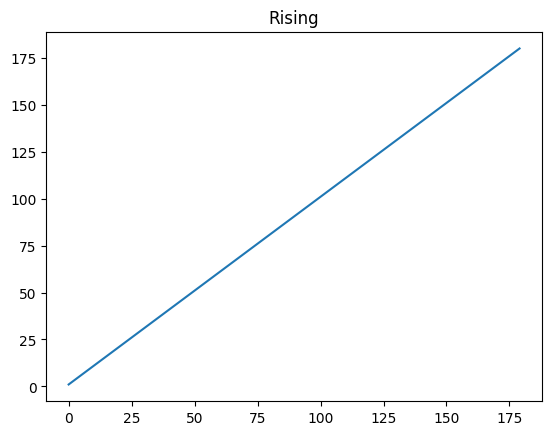

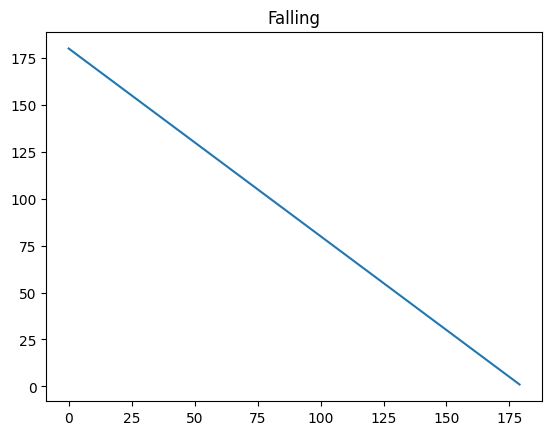

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-40-bb1eba1a8198>:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-40-bb1eba1a8198>:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*(torch.max(q_hats_next)),device=device)


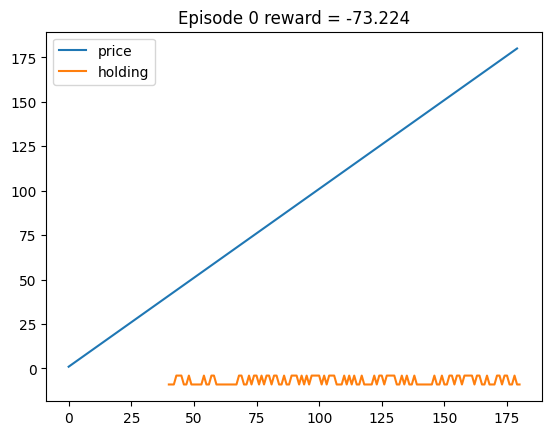

  2%|▎         | 1/40 [00:00<00:23,  1.68it/s]


episode_rewards[-1] = -73.224



 20%|██        | 8/40 [00:03<00:12,  2.62it/s]

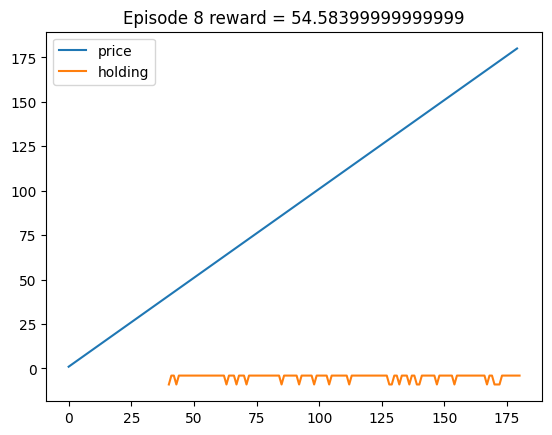

Mean 10 total rewards = -6.45, Grad norm: 0.03, mean_loss_delta (want +) = 0.0900, action_counts: [51, 10, 79]:  40%|████      | 16/40 [00:09<00:18,  1.30it/s] 

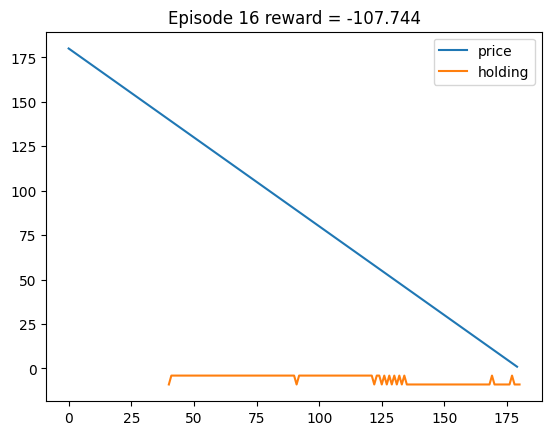

Mean 10 total rewards = 42.96, Grad norm: 0.12, mean_loss_delta (want +) = 0.0174, action_counts: [134, 6, 0]:  60%|██████    | 24/40 [00:17<00:16,  1.01s/it]  

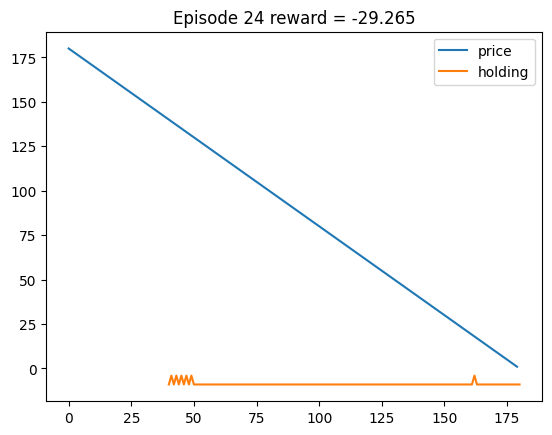

Mean 10 total rewards = 49.23, Grad norm: 0.26, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  80%|████████  | 32/40 [00:27<00:08,  1.06s/it]

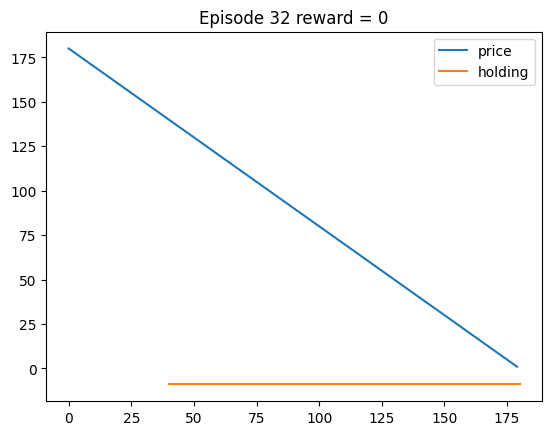

Mean 10 total rewards = 67.74, Grad norm: 0.26, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  98%|█████████▊| 39/40 [00:33<00:00,  1.01it/s]


episode_rewards[-1] = 0



Mean 10 total rewards = 67.74, Grad norm: 77.77, mean_loss_delta (want +) = 0.0000, action_counts: [1, 2, 137]: 100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


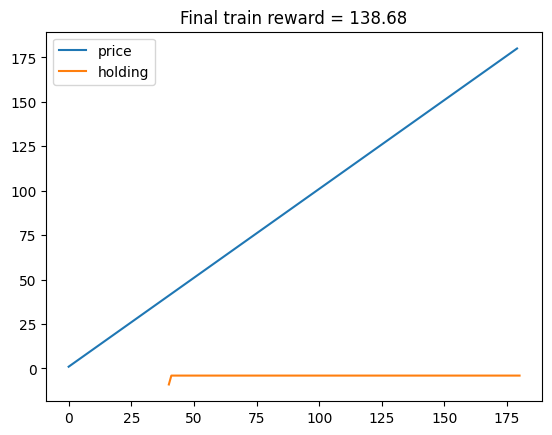

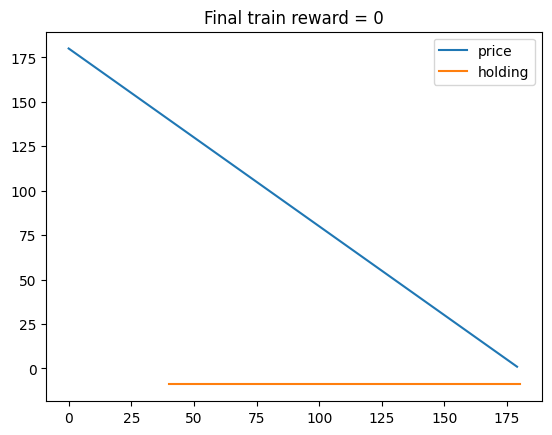

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 200, 200), 0.0003, 0.99, 40, 0.95, 0.0003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


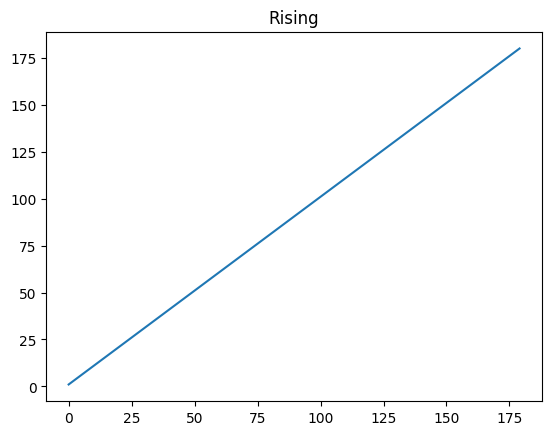

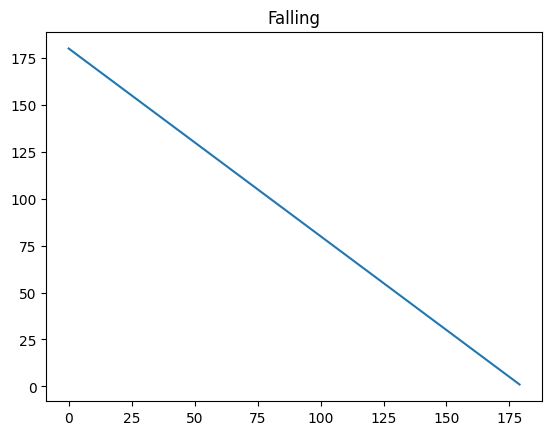

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-38-ac3f2566de0f>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-38-ac3f2566de0f>:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*q_hats_next[action_],device=device)


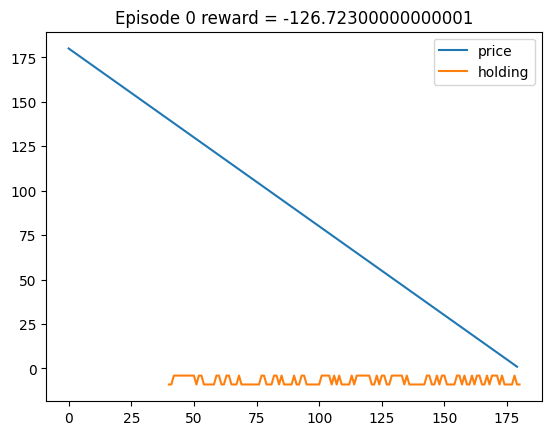

  2%|▎         | 1/40 [00:00<00:24,  1.61it/s]


episode_rewards[-1] = -126.72300000000001



 20%|██        | 8/40 [00:03<00:13,  2.39it/s]

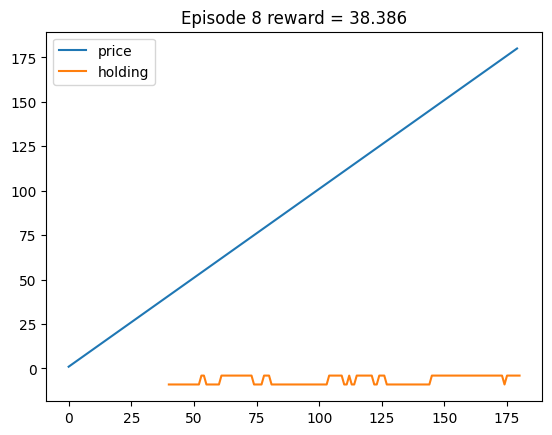

Mean 10 total rewards = -34.95, Grad norm: 0.04, mean_loss_delta (want +) = 0.0116, action_counts: [103, 2, 35]:  40%|████      | 16/40 [00:10<00:17,  1.35it/s]

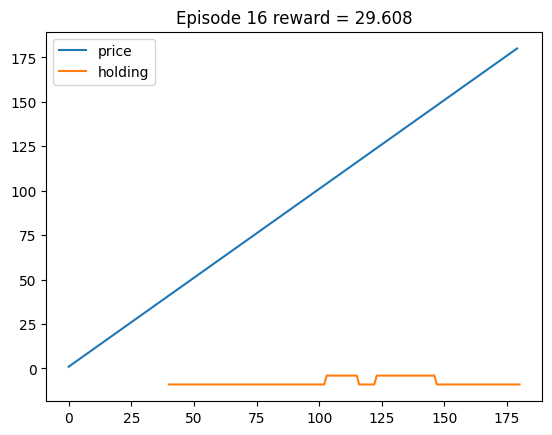

Mean 10 total rewards = -10.23, Grad norm: 0.04, mean_loss_delta (want +) = 0.0003, action_counts: [139, 1, 0]:  60%|██████    | 24/40 [00:17<00:13,  1.16it/s]

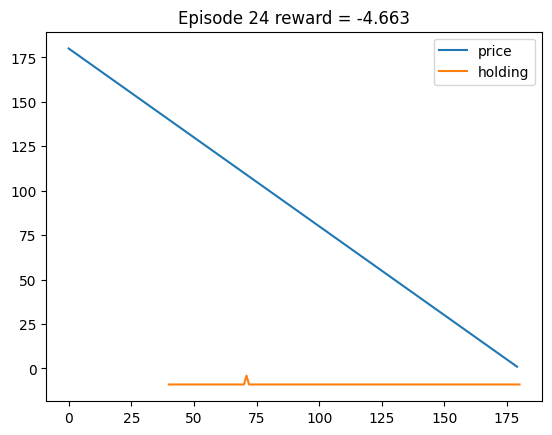

Mean 10 total rewards = 8.04, Grad norm: 0.00, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  80%|████████  | 32/40 [00:27<00:11,  1.38s/it]

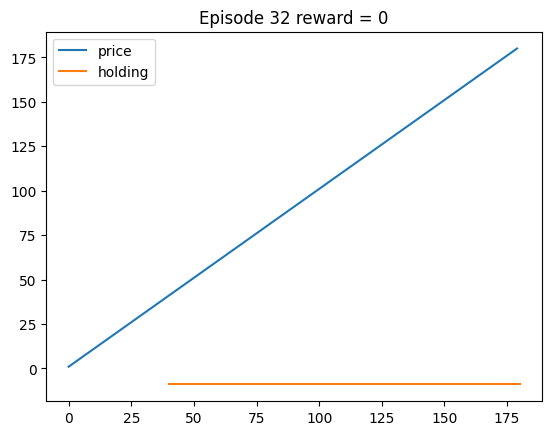

Mean 10 total rewards = 7.58, Grad norm: 0.00, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  98%|█████████▊| 39/40 [00:33<00:01,  1.01s/it]


episode_rewards[-1] = 0



Mean 10 total rewards = 7.58, Grad norm: 29.19, mean_loss_delta (want +) = 0.0000, action_counts: [64, 1, 75]: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


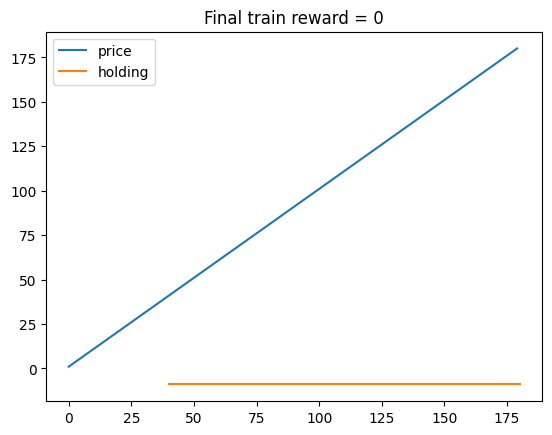

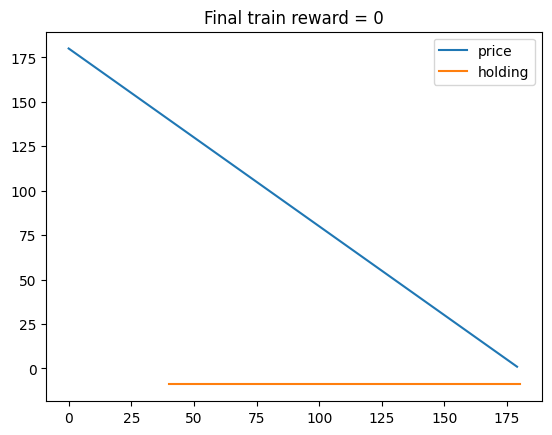

In [ ]:
sweep_settings = [((200,200,200), master_data6, 3e-04, 0.99, 40, 0.95, 0.0003,True,False)]
results_dict_q_6 = qlearn3_sweep_MLP(sweep_settings)
results_dict_s_6 = sarsa_sweep_MLP(sweep_settings)

Presumably these models learned to buy and hold when a stock is increasing, and sell and not buy when it is decreasing. Let's see what happens when we try testing them on more complex synthetic data and on real world data! As the coming cells will show, the models haven't learned very sophisticated policies, but they are at least broadly capable of following the ups and downs of unseen test data.

In [ ]:
key = ((200, 200, 200), 0.0003, 0.99, 40, 0.95, 0.0003)
selected_stock = np.random.choice(master_data2.columns) # There's actually only one column
data = (master_data2[selected_stock].values)

for results_dict in [results_dict_q_6,results_dict_s_6]:
  model = results_dict[key][2]
  total_reward,episode_holdings = eval_model_on_data(model,data,model_class=MLP)
  plt.plot(range(len(data)),data,label="price")
  plt.plot(range(40,len(episode_holdings)+40),episode_holdings,label="holding")
  plt.title(f"Test Reward = {total_reward:.2f}")
  plt.legend()
  plt.show()

In [ ]:
key = ((200, 200, 200), 0.0003, 0.99, 40, 0.95, 0.0003)
selected_stock = np.random.choice(master_data3.columns) # There's actually only one column
data = (master_data3[selected_stock].values)

for results_dict in [results_dict_q_6,results_dict_s_6]:
  model = results_dict[key][2]
  total_reward,episode_holdings = eval_model_on_data(model,data,model_class=MLP)
  plt.plot(range(len(data)),data,label="price")
  plt.plot(range(40,len(episode_holdings)+40),episode_holdings,label="holding")
  plt.title(f"Test Reward = {total_reward:.2f}")
  plt.legend()
  plt.show()

In [ ]:
key = ((200, 200, 200), 0.0003, 0.99, 40, 0.95, 0.0003)
for i in range(5):
  selected_stock = np.random.choice(master_data.columns)
  print(selected_stock)
  data = (master_data[selected_stock].values)

  for results_dict in [results_dict_q_6,results_dict_s_6]:
    model = results_dict[key][2]
    total_reward,episode_holdings = eval_model_on_data(model,data,model_class=MLP)
    plt.plot(range(len(data)),data,label="price")
    plt.plot(range(40,len(episode_holdings)+40),episode_holdings,label="holding")
    plt.title(f"Test Reward = {total_reward:.2f}")
    plt.legend()
    plt.show()

## Slightly less trivial again
Can the model learn a single stock's rises and falls?

In [ ]:
sweep_settings = [((200,300,200), master_data2, 3e-03, 0.99, 100, 0.95, 0.0003,True,False)]
results_dict_q_2 = qlearn3_sweep_MLP(sweep_settings)
results_dict_s_2 = sarsa_sweep_MLP(sweep_settings)

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.3, 0.99, 100, 0.95, 0.0003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


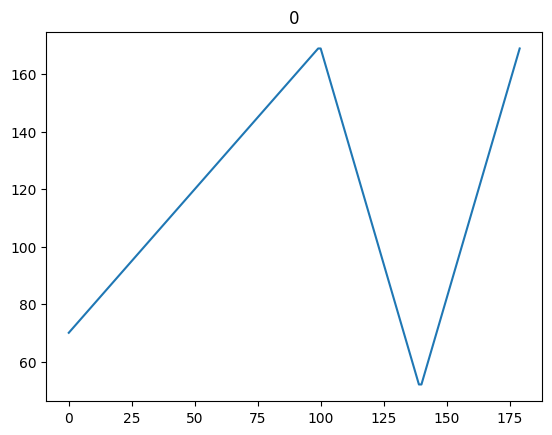

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-bb1eba1a8198>:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-40-bb1eba1a8198>:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*(torch.max(q_hats_next)),device=device)


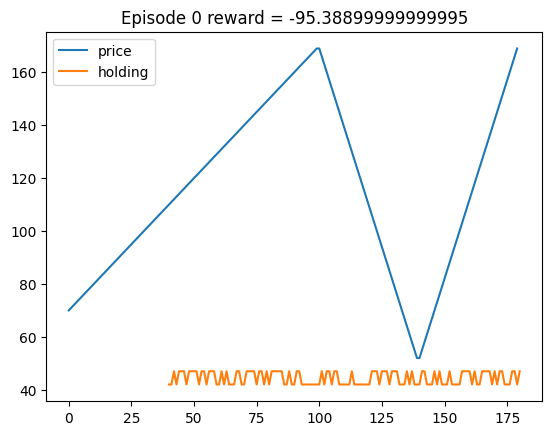

  1%|          | 1/100 [00:00<01:25,  1.16it/s]


episode_rewards[-1] = -95.38899999999995



Mean 10 total rewards = -80.41, Grad norm: 75145125888.00, mean_loss_delta (want +) = 33786479771648.0000, action_counts: [69, 27, 44]:  20%|██        | 20/100 [00:18<01:38,  1.23s/it]  

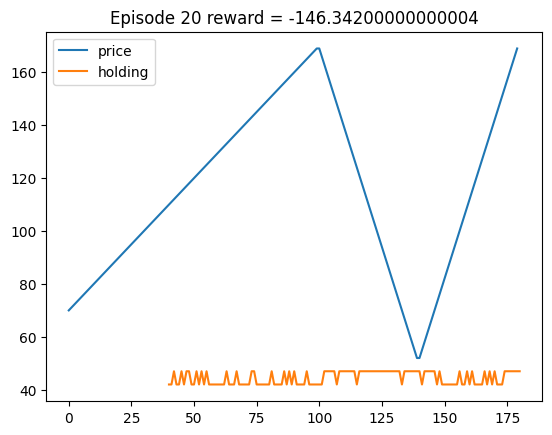

Mean 10 total rewards = -6.73, Grad norm: 118202441728.00, mean_loss_delta (want +) = 53130842603520.0000, action_counts: [6, 6, 128]:  40%|████      | 40/100 [00:42<01:10,  1.18s/it]

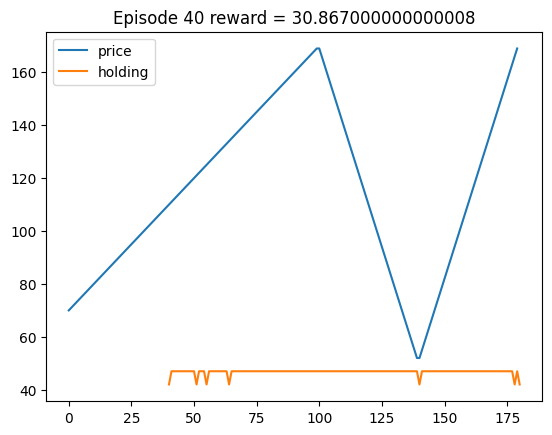

Mean 10 total rewards = 14.02, Grad norm: 1158833152.00, mean_loss_delta (want +) = 222558502912.0000, action_counts: [13, 6, 121]:  60%|██████    | 60/100 [01:06<00:47,  1.18s/it]  

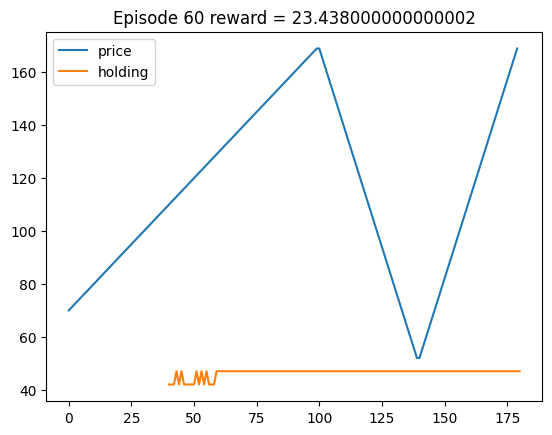

Mean 10 total rewards = 54.74, Grad norm: 132749928.00, mean_loss_delta (want +) = 35722092544.0000, action_counts: [0, 1, 139]:  80%|████████  | 80/100 [01:30<00:26,  1.32s/it]

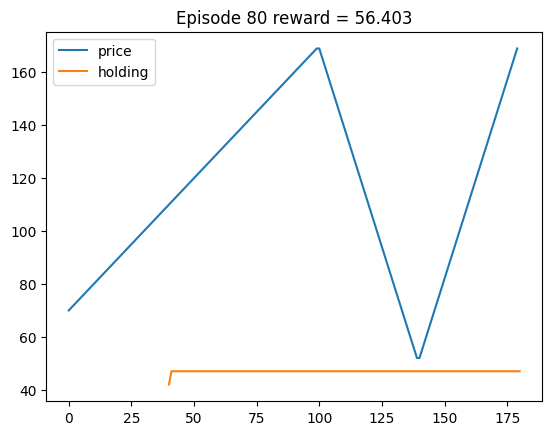

Mean 10 total rewards = 56.40, Grad norm: 6154837.50, mean_loss_delta (want +) = 715041920.0000, action_counts: [0, 1, 139]:  99%|█████████▉| 99/100 [01:57<00:01,  1.56s/it]


episode_rewards[-1] = 56.403



Mean 10 total rewards = 56.40, Grad norm: 6154837.50, mean_loss_delta (want +) = 715041920.0000, action_counts: [0, 1, 139]: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


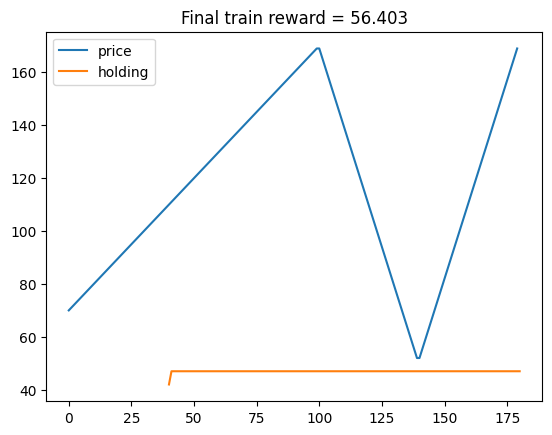

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.003, 0.99, 100, 0.95, 0.0003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


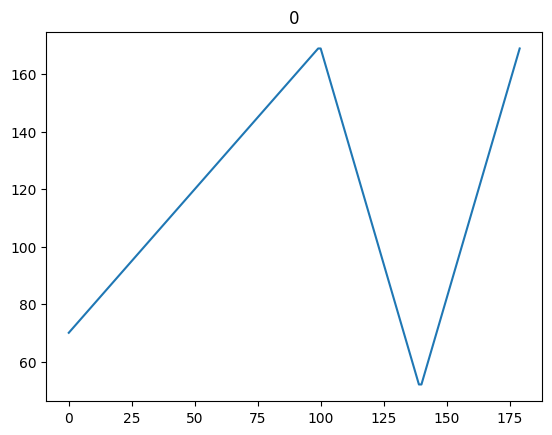

  0%|          | 0/100 [00:00<?, ?it/s]

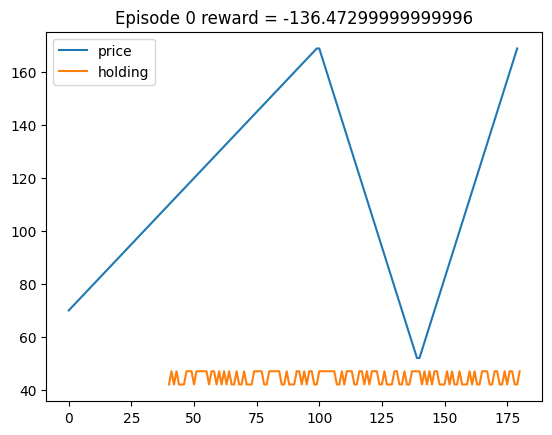

  1%|          | 1/100 [00:00<01:04,  1.53it/s]


episode_rewards[-1] = -136.47299999999996



Mean 10 total rewards = -60.07, Grad norm: 291.64, mean_loss_delta (want +) = 281.2634, action_counts: [96, 24, 20]:  20%|██        | 20/100 [00:24<01:47,  1.34s/it] 

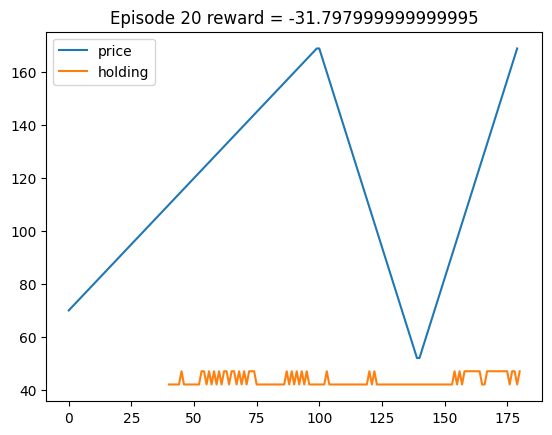

Mean 10 total rewards = 55.42, Grad norm: 117.65, mean_loss_delta (want +) = 6919.0874, action_counts: [105, 4, 31]:  40%|████      | 40/100 [00:49<01:15,  1.26s/it]

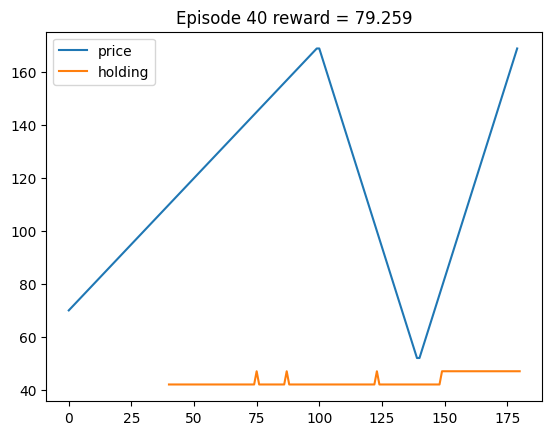

Mean 10 total rewards = 81.24, Grad norm: 0.03, mean_loss_delta (want +) = -100317.2422, action_counts: [107, 2, 31]:  60%|██████    | 60/100 [01:18<01:00,  1.51s/it]

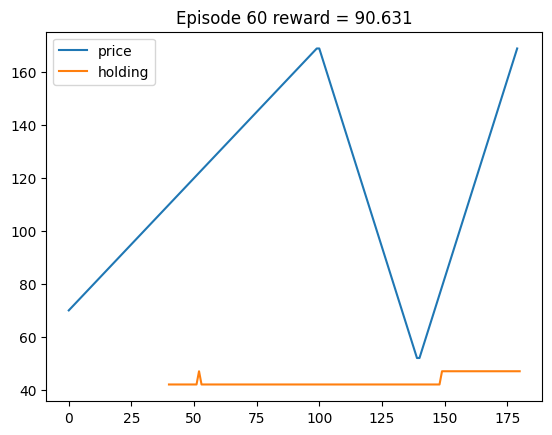

Mean 10 total rewards = 87.80, Grad norm: 13.31, mean_loss_delta (want +) = -66722.1328, action_counts: [108, 2, 30]:  80%|████████  | 80/100 [01:48<00:26,  1.34s/it]

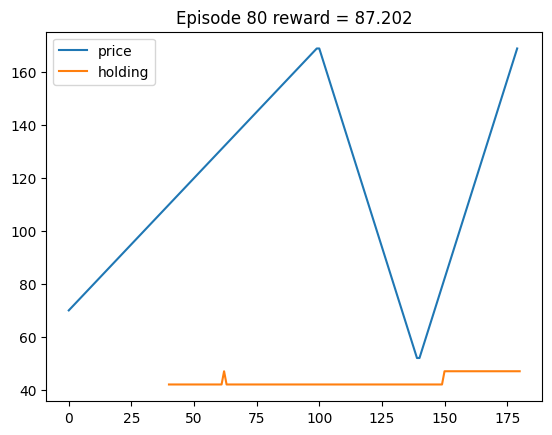

Mean 10 total rewards = 92.04, Grad norm: 0.01, mean_loss_delta (want +) = -703.0317, action_counts: [108, 1, 31]:  99%|█████████▉| 99/100 [02:13<00:01,  1.35s/it]


episode_rewards[-1] = 93.59100000000001



Mean 10 total rewards = 92.04, Grad norm: 0.01, mean_loss_delta (want +) = -703.0317, action_counts: [108, 1, 31]: 100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


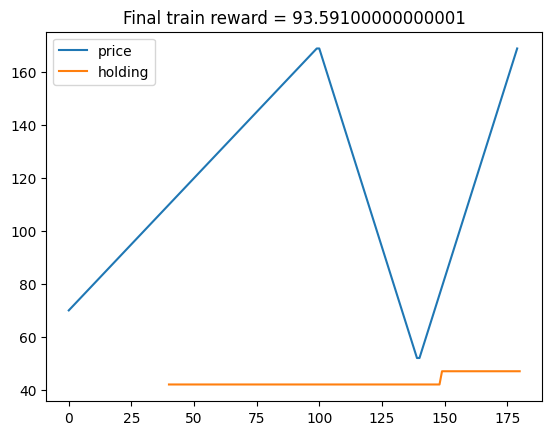

In [ ]:
sweep_settings = [((200,300,200), master_data3, 3e-01, 0.99, 100, 0.95, 0.0003,True,False),
                  ((200,300,200), master_data3, 3e-03, 0.99, 100, 0.95, 0.0003,True,False)]
                  # ,
                  # ((200,300,200), master_data3, 3e-05, 0.99, 40, 0.95, 0.0003,True,False),
                  # ((200,300,200), master_data3, 3e-07, 0.99, 40, 0.95, 0.0003,True,False),
                  # ((200,300,200), master_data3, 3e-01, 0.99, 40, 0.95, 0.03,True,False),
                  # ((200,300,200), master_data3, 3e-03, 0.99, 40, 0.95, 0.03,True,False),
                  # ((200,300,200), master_data3, 3e-05, 0.99, 40, 0.95, 0.03,True,False),
                  # ((200,300,200), master_data3, 3e-07, 0.99, 40, 0.95, 0.03,True,False)]
results_dict_q_3 = qlearn3_sweep_MLP(sweep_settings) 
# One run like this worked well and generated the plot I included in the submission, but I couldn't replicate it

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.003, 0.99, 40, 0.95, 3e-05, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


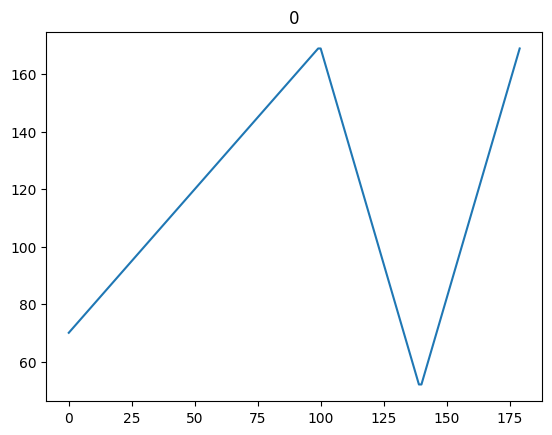

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-17-98e69936b2e8>:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-17-98e69936b2e8>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*(torch.max(q_hats_next)),device=device)


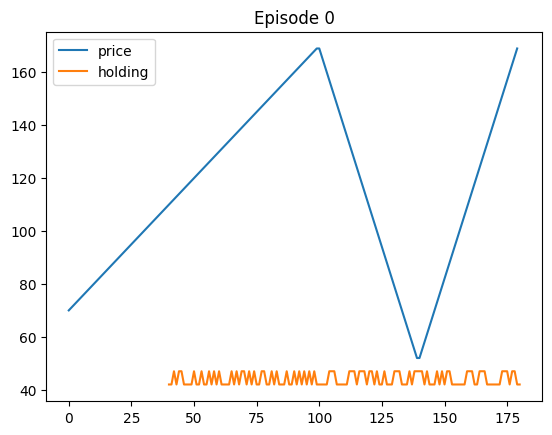

  2%|▎         | 1/40 [00:00<00:24,  1.62it/s]


episode_rewards[-1] = -142.86900000000006



 20%|██        | 8/40 [00:03<00:16,  1.93it/s]

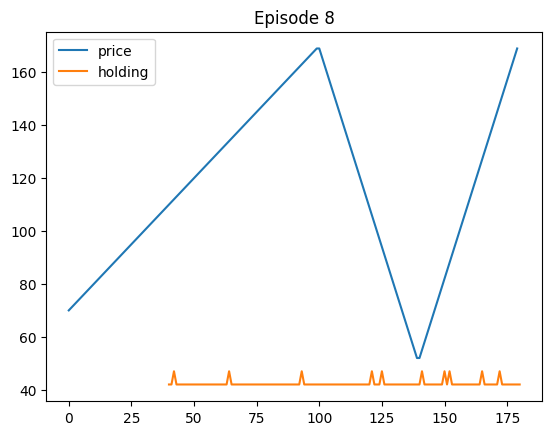

Mean 10 total rewards = -8.86, Grad norm: 11.79, mean_loss_delta (want +) = 7.2399, action_counts: [107, 4, 29]:  40%|████      | 16/40 [00:14<00:28,  1.17s/it]

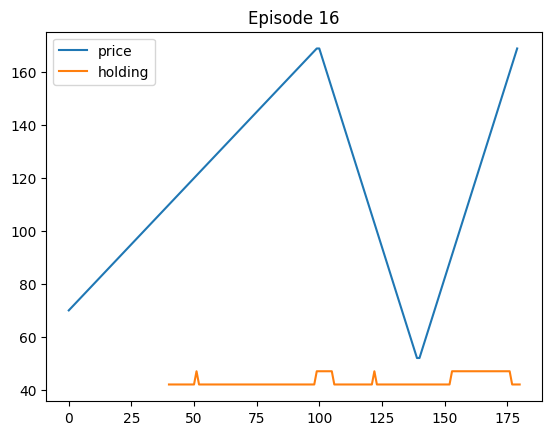

Mean 10 total rewards = 64.27, Grad norm: 102.80, mean_loss_delta (want +) = 29.4243, action_counts: [0, 1, 139]:  60%|██████    | 24/40 [00:27<00:23,  1.49s/it]

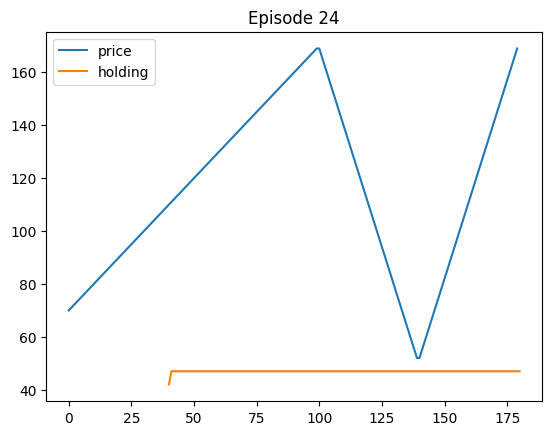

Mean 10 total rewards = 53.25, Grad norm: 61.85, mean_loss_delta (want +) = 27.9684, action_counts: [0, 1, 139]:  80%|████████  | 32/40 [00:39<00:11,  1.38s/it]

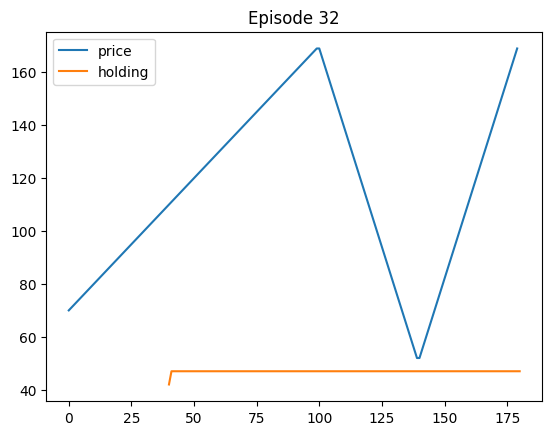

Mean 10 total rewards = 55.29, Grad norm: 35.94, mean_loss_delta (want +) = 2.1803, action_counts: [0, 1, 139]:  98%|█████████▊| 39/40 [00:47<00:01,  1.23s/it]


episode_rewards[-1] = 56.403



Mean 10 total rewards = 55.29, Grad norm: 35.81, mean_loss_delta (want +) = 0.0000, action_counts: [0, 1, 139]: 100%|██████████| 40/40 [00:48<00:00,  1.20s/it]


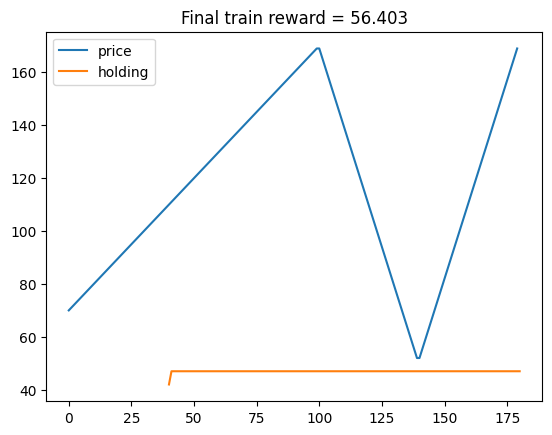

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.003, 0.99, 40, 0.95, 3e-05, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


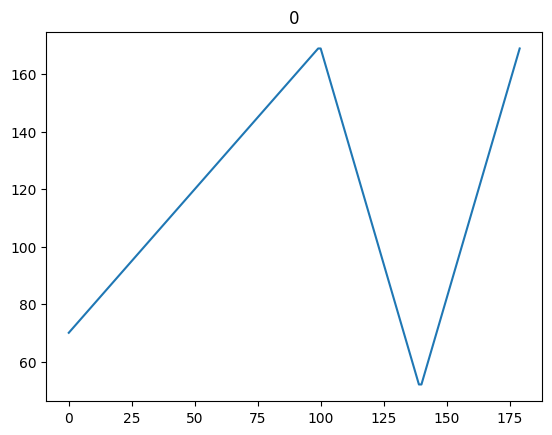

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-21-bbac604a4b35>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-21-bbac604a4b35>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*q_hats_next[action_],device=device)


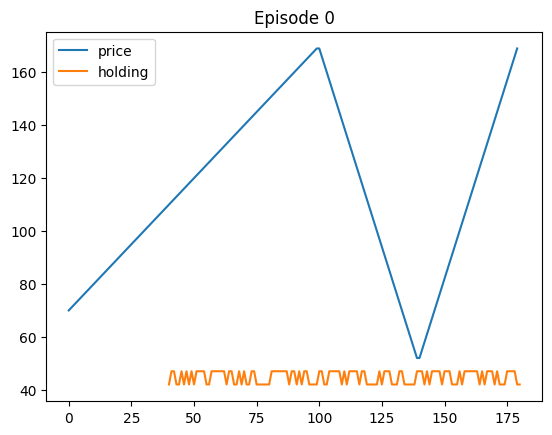

  2%|▎         | 1/40 [00:00<00:24,  1.57it/s]


episode_rewards[-1] = -81.80900000000003



 20%|██        | 8/40 [00:03<00:13,  2.33it/s]

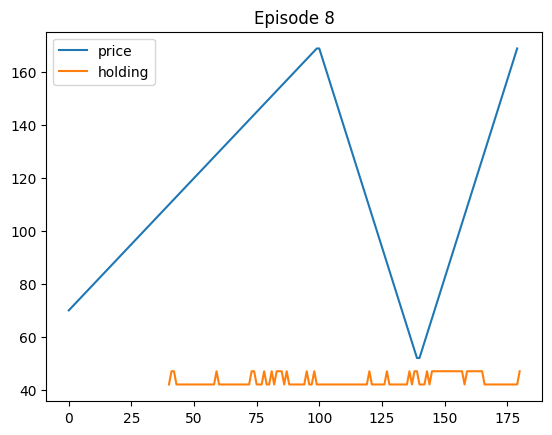

Mean 10 total rewards = 11.00, Grad norm: 24.53, mean_loss_delta (want +) = 2.8856, action_counts: [137, 3, 0]:  40%|████      | 16/40 [00:16<00:33,  1.39s/it] 

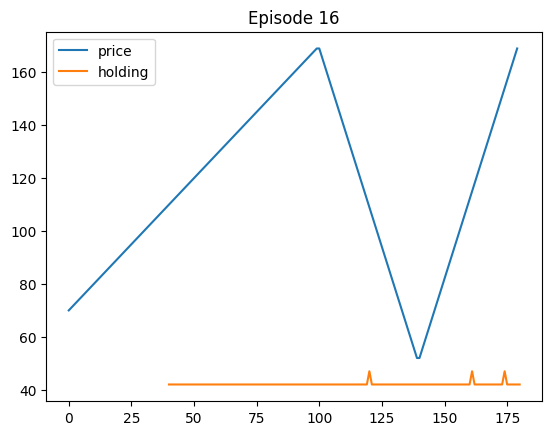

Mean 10 total rewards = 59.47, Grad norm: 6.90, mean_loss_delta (want +) = -2.4860, action_counts: [107, 4, 29]:  60%|██████    | 24/40 [00:30<00:24,  1.51s/it]

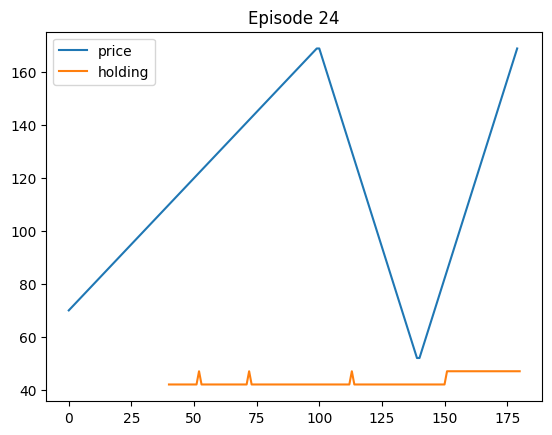

Mean 10 total rewards = 81.89, Grad norm: 75.54, mean_loss_delta (want +) = 3.8908, action_counts: [108, 2, 30]:  80%|████████  | 32/40 [00:40<00:09,  1.22s/it]

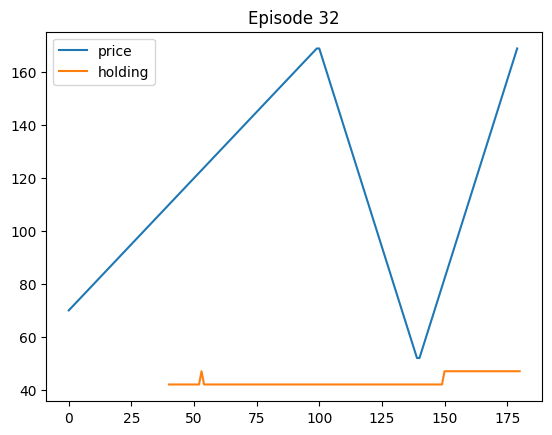

Mean 10 total rewards = 87.43, Grad norm: 107.03, mean_loss_delta (want +) = 0.4147, action_counts: [109, 1, 30]:  98%|█████████▊| 39/40 [00:48<00:01,  1.22s/it]


episode_rewards[-1] = 90.492



Mean 10 total rewards = 88.74, Grad norm: 107.12, mean_loss_delta (want +) = 0.0000, action_counts: [109, 1, 30]: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


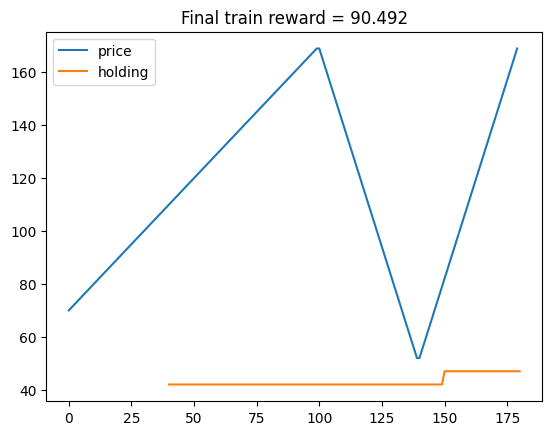

In [ ]:
sweep_settings = [((200,300,200), master_data3, 3e-03, 0.99, 40, 0.95, 0.0003,True,False)]
results_dict_q_3 = qlearn3_sweep_MLP(sweep_settings)
results_dict_s_3 = sarsa_sweep_MLP(sweep_settings)

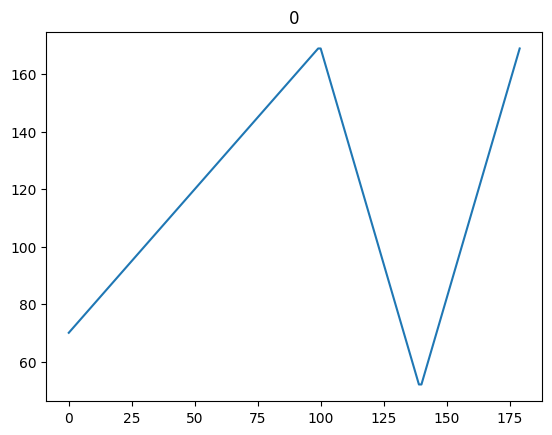

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-40-bb1eba1a8198>:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-40-bb1eba1a8198>:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*(torch.max(q_hats_next)),device=device)


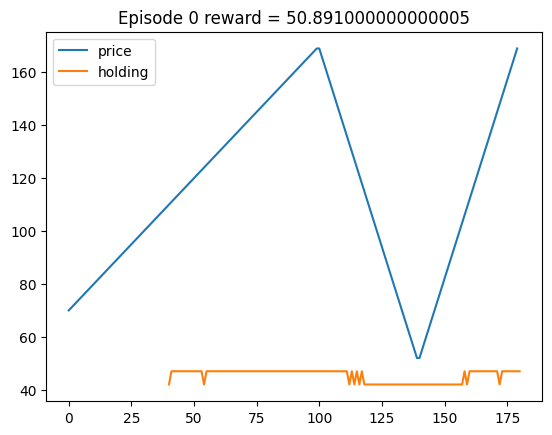

  2%|▎         | 1/40 [00:01<00:42,  1.08s/it]


episode_rewards[-1] = 50.891000000000005



 20%|██        | 8/40 [00:07<00:32,  1.00s/it]

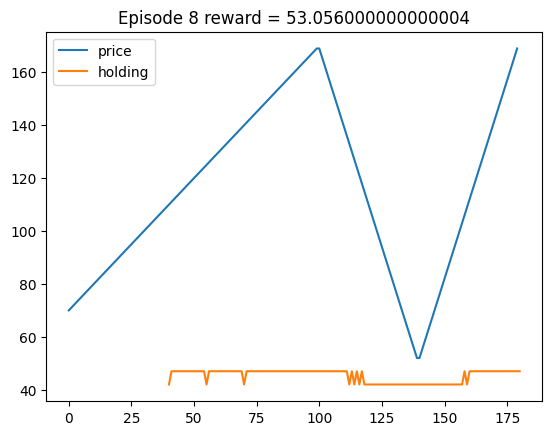

Mean 10 total rewards = 57.06, Grad norm: 318.88, mean_loss_delta (want +) = 0.0000, action_counts: [44, 6, 90]:  40%|████      | 16/40 [00:15<00:21,  1.11it/s]

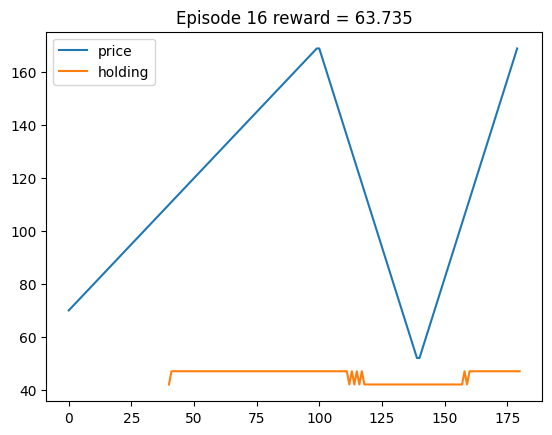

Mean 10 total rewards = 63.15, Grad norm: 318.52, mean_loss_delta (want +) = 0.0000, action_counts: [44, 7, 89]:  60%|██████    | 24/40 [00:23<00:15,  1.06it/s]

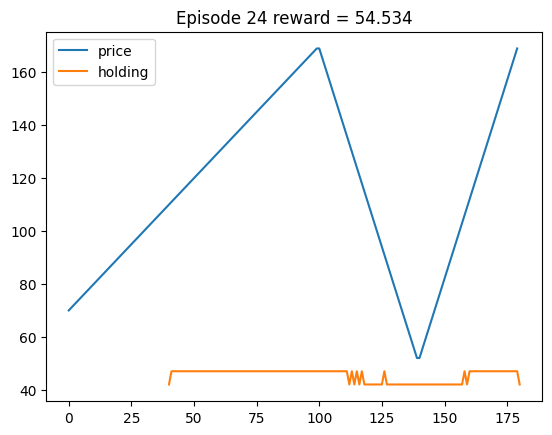

Mean 10 total rewards = 62.63, Grad norm: 318.39, mean_loss_delta (want +) = 0.0000, action_counts: [44, 6, 90]:  80%|████████  | 32/40 [00:31<00:07,  1.03it/s]

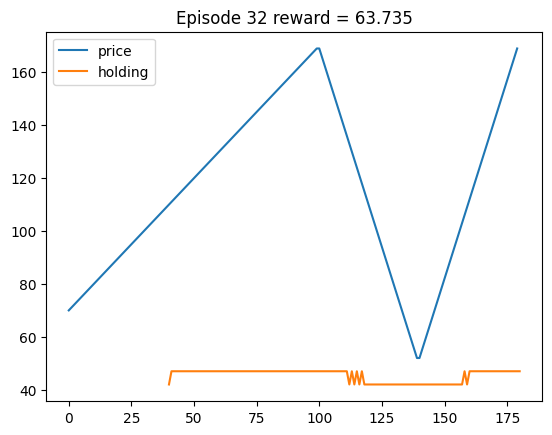

Mean 10 total rewards = 63.63, Grad norm: 318.37, mean_loss_delta (want +) = -0.0000, action_counts: [44, 6, 90]:  98%|█████████▊| 39/40 [00:37<00:00,  1.10it/s]


episode_rewards[-1] = 63.735



Mean 10 total rewards = 63.63, Grad norm: 318.37, mean_loss_delta (want +) = 0.0000, action_counts: [45, 6, 89]: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


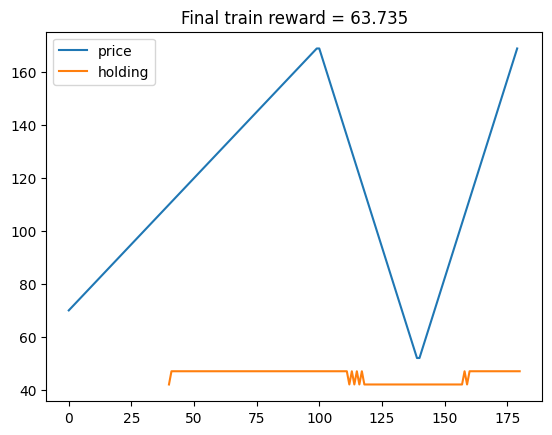

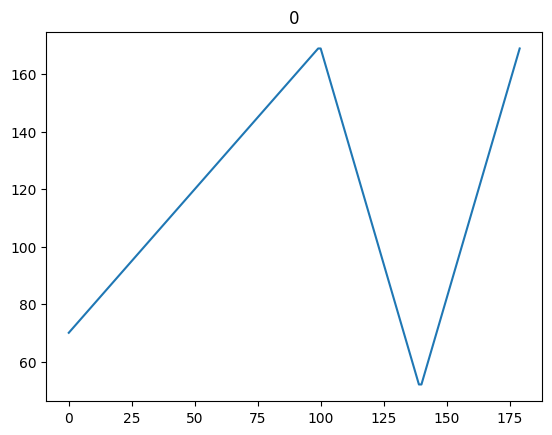

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-38-ac3f2566de0f>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-38-ac3f2566de0f>:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*q_hats_next[action_],device=device)


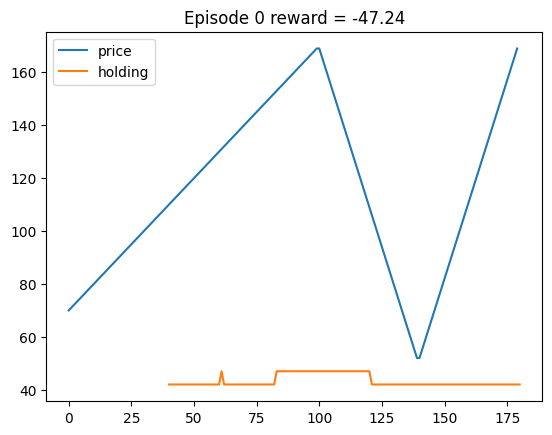

  2%|▎         | 1/40 [00:01<00:44,  1.14s/it]


episode_rewards[-1] = -47.24



 20%|██        | 8/40 [00:07<00:30,  1.06it/s]

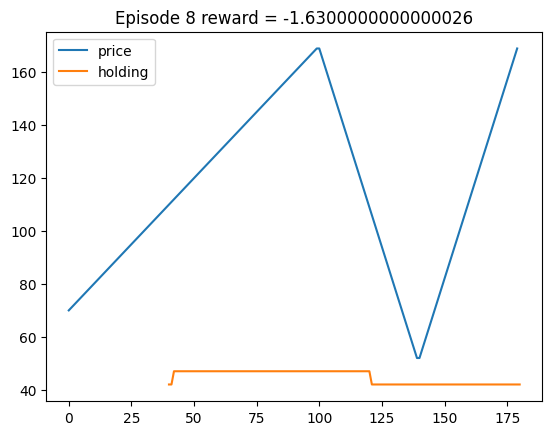

Mean 10 total rewards = 6.90, Grad norm: 0.10, mean_loss_delta (want +) = 0.0000, action_counts: [139, 1, 0]:  40%|████      | 16/40 [00:15<00:20,  1.14it/s]

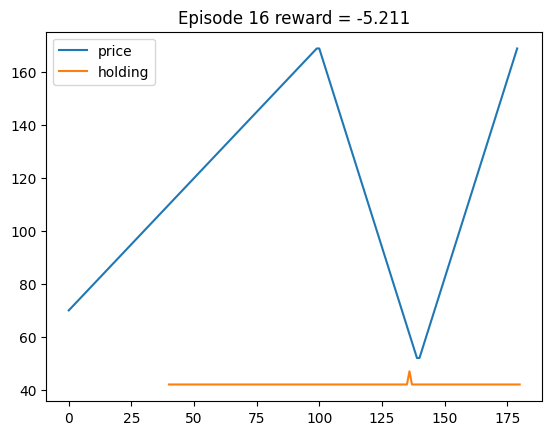

Mean 10 total rewards = -10.50, Grad norm: 108.59, mean_loss_delta (want +) = 0.0001, action_counts: [77, 2, 61]:  60%|██████    | 24/40 [00:24<00:16,  1.05s/it]

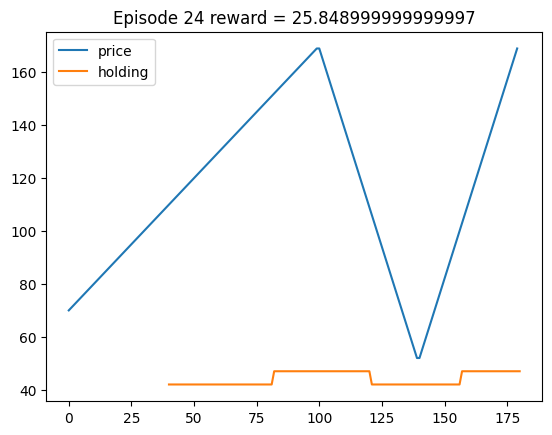

Mean 10 total rewards = -0.92, Grad norm: 0.10, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  80%|████████  | 32/40 [00:32<00:07,  1.00it/s]

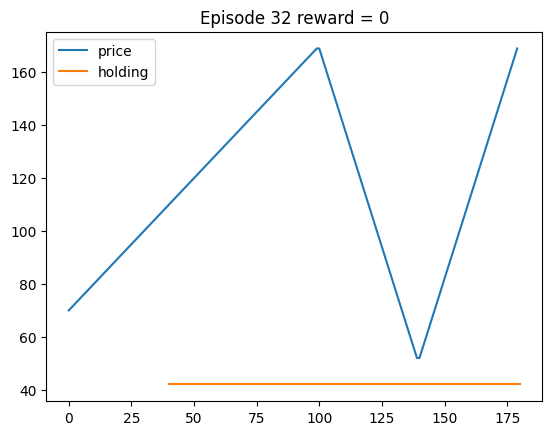

Mean 10 total rewards = 1.61, Grad norm: 0.10, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  98%|█████████▊| 39/40 [00:37<00:00,  1.10it/s]


episode_rewards[-1] = 0



Mean 10 total rewards = 0.00, Grad norm: 0.10, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]: 100%|██████████| 40/40 [00:38<00:00,  1.05it/s]


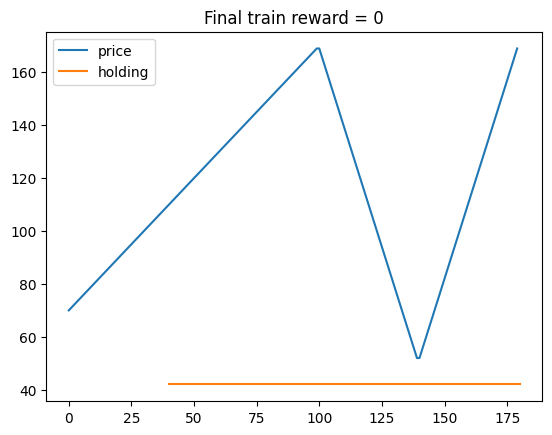

In [ ]:
# Try finetuning a model that already does something somewhat sensible 
hidden_sizes = (200,300,200)
dataset = master_data3
alpha = 3e-07 # Small since we are using a pretrained model
discount_rate = 0.99
num_episodes = 40
prev_key = ((200,200,200), 3e-04, 0.99, 40, 0.95, 0.0003)
load_model = copy.deepcopy(results_dict_q_6[prev_key][2])
epsilon = 0.05 # Small to start, since we are using a pretrained model
wd = 0.00003
proper = True
debug = False

finetune_key = (hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd)

sweep_settings = [(hidden_sizes,dataset,alpha,discount_rate,num_episodes,load_model,epsilon,wd,proper,debug)]

episode_rewards,episode_losses,model = qlearn_train3(MLP, mlp_config(hidden_sizes=hidden_sizes), dataset, alpha, discount_rate, num_episodes, 
                                                     load_model,epsilon,wd,proper,debug,visualize_final=True,
                                                     visualize_intermediate=5)
results_dict_q_3_finetune = {}
results_dict_q_3_finetune[finetune_key]=(episode_rewards,episode_losses,model)

load_model = copy.deepcopy(results_dict_s_6[prev_key][2])

episode_rewards,episode_losses,model = sarsa_train(MLP, mlp_config(hidden_sizes=hidden_sizes), dataset, alpha, discount_rate, num_episodes, 
                                                   load_model,epsilon,wd,proper,debug,visualize_final=True,
                                                   visualize_intermediate=5)
results_dict_s_3_finetune = {}
results_dict_s_3_finetune[finetune_key]=(episode_rewards,episode_losses,model)

In [ ]:
hidden_sizes = (200,300,200)
dataset = master_data3
alpha = 3e-07 # Small since we are using a pretrained model
discount_rate = 0.99
num_episodes = 40
prev_key = ((200,200,200), 3e-04, 0.99, 40, 0.95, 0.0003)
load_model = copy.deepcopy(results_dict_q_6[prev_key][2])
epsilon = 0.05 # Small to start, since we are using a pretrained model
wd = 0.00003
proper = True
debug = False

finetune_key = (hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd)

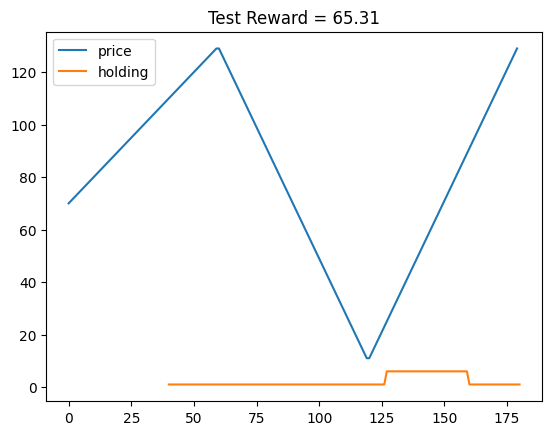

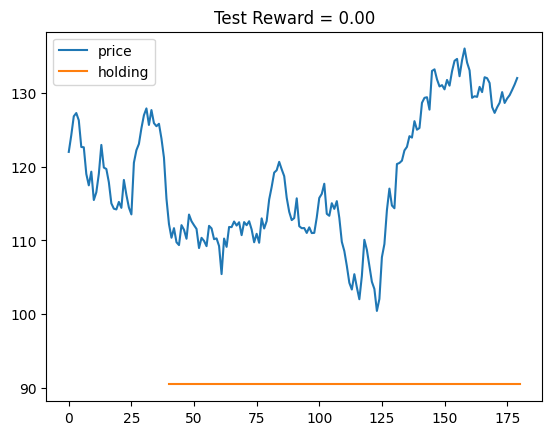

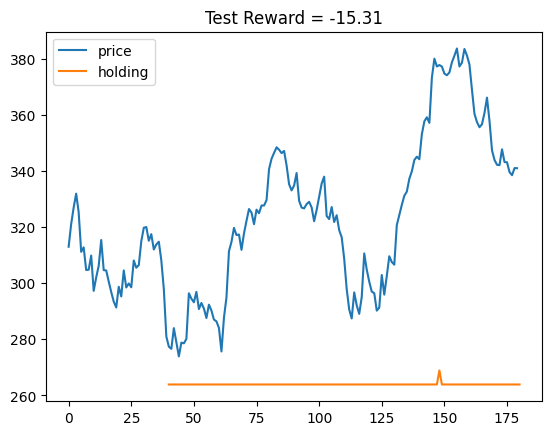

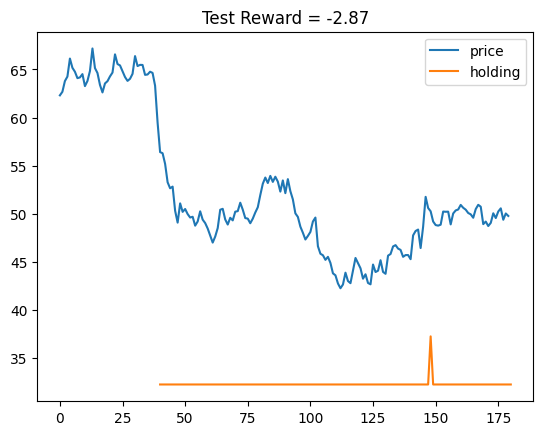

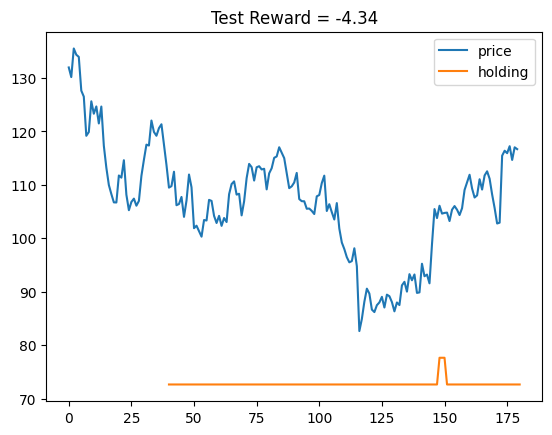

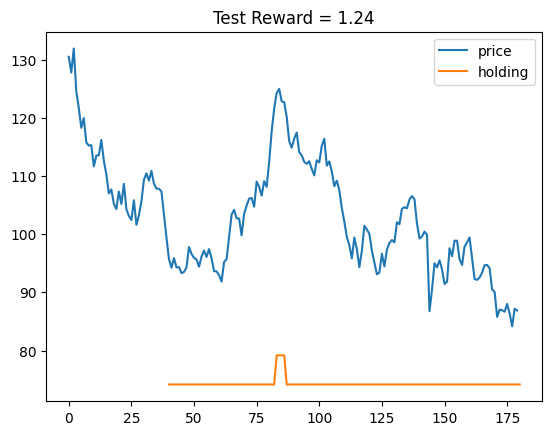

In [ ]:
key = ((200,300,200), 3e-03, 0.99, 100, 0.95, 0.0003)
selected_stock = np.random.choice(master_data2.columns) # There's actually only one column
data = (master_data2[selected_stock].values)

for results_dict in [results_dict_q_3]:
  model = results_dict[key][2]
  total_reward,episode_holdings = eval_model_on_data(model,data,model_class=MLP)
  plt.plot(range(len(data)),data,label="price")
  plt.plot(range(40,len(episode_holdings)+40),episode_holdings,label="holding")
  plt.title(f"Test Reward = {total_reward:.2f}")
  plt.legend()
  plt.show()

for _ in range(5):
  selected_stock = np.random.choice(master_data.columns) # There's actually only one column
  data = (master_data[selected_stock].values)

  for results_dict in [results_dict_q_3]:
    model = results_dict[key][2]
    total_reward,episode_holdings = eval_model_on_data(model,data,model_class=MLP)
    plt.plot(range(len(data)),data,label="price")
    plt.plot(range(40,len(episode_holdings)+40),episode_holdings,label="holding")
    plt.title(f"Test Reward = {total_reward:.2f}")
    plt.legend()
    plt.show()

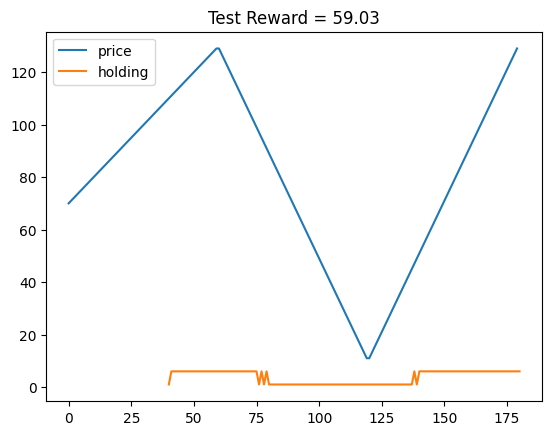

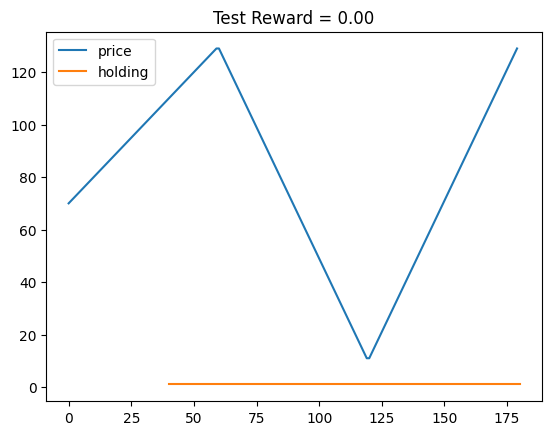

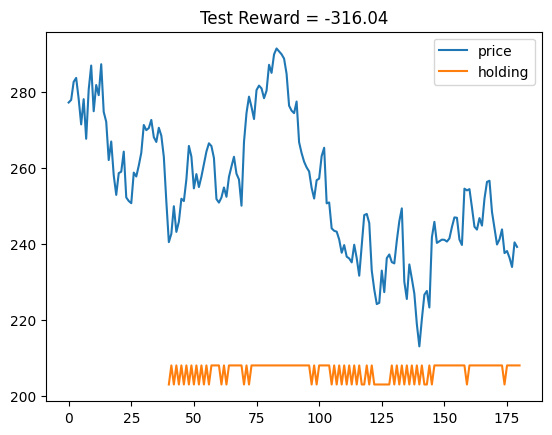

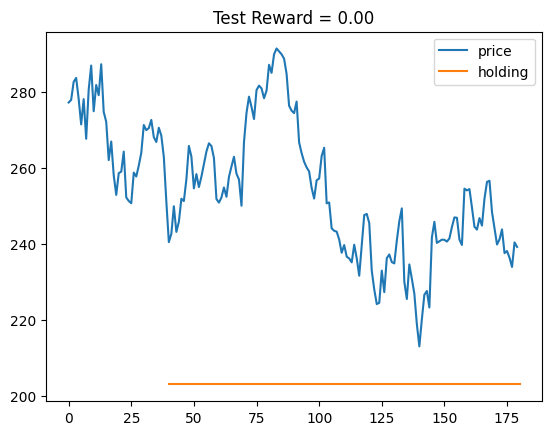

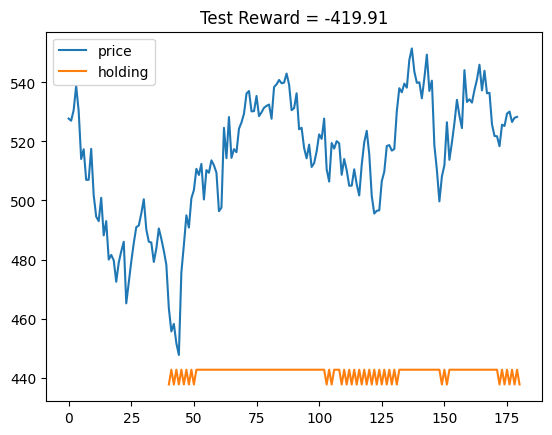

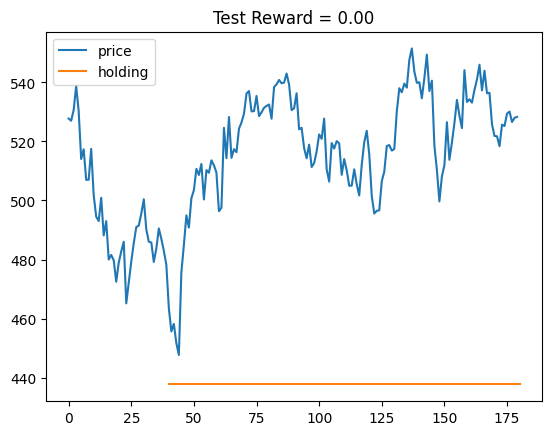

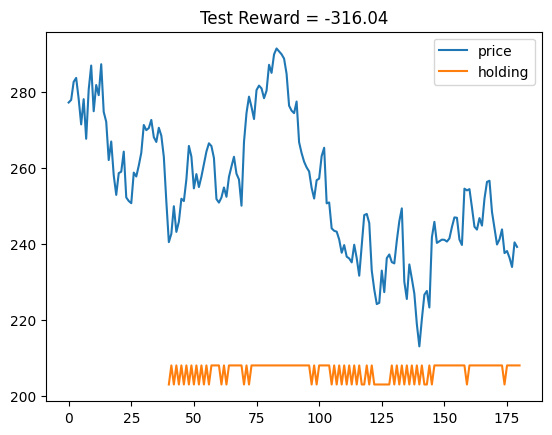

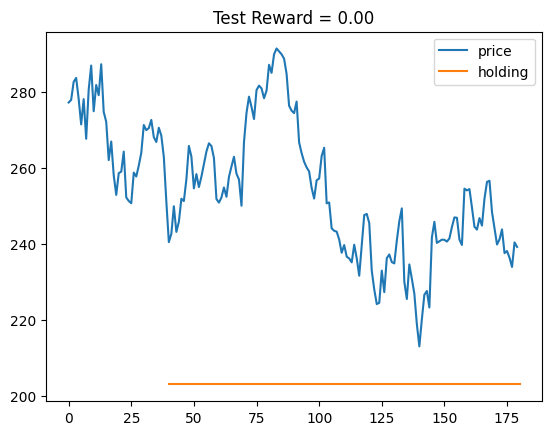

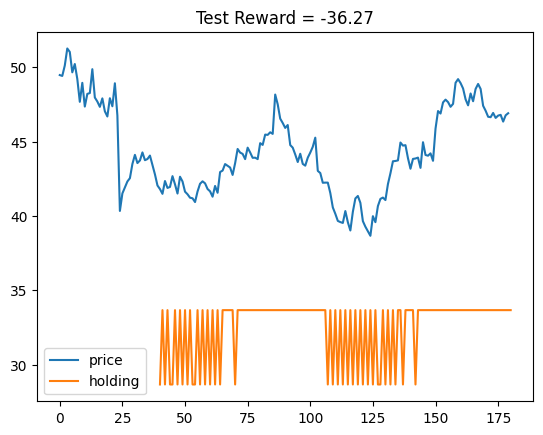

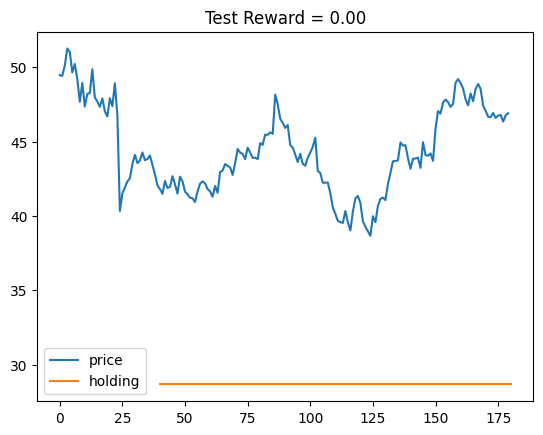

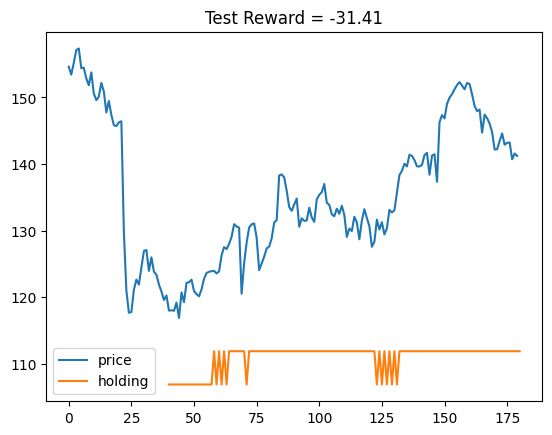

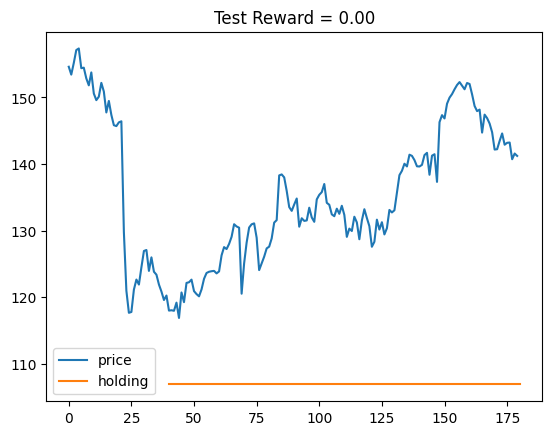

In [ ]:
key = finetune_key

for results_dict in [results_dict_q_3_finetune,results_dict_s_3_finetune]:

  model = results_dict[key][2]
  total_reward,episode_holdings = eval_model_on_data(model,data,model_class=MLP)
  plt.plot(range(len(data)),data,label="price")
  plt.plot(range(40,len(episode_holdings)+40),episode_holdings,label="holding")
  plt.title(f"Test Reward = {total_reward:.2f}")
  plt.legend()
  plt.show()

for _ in range(5):
  selected_stock = np.random.choice(master_data.columns) # There's actually only one column
  data = (master_data[selected_stock].values)

  for results_dict in [results_dict_q_3_finetune,results_dict_s_3_finetune]:
    model = results_dict[key][2]
    total_reward,episode_holdings = eval_model_on_data(model,data,model_class=MLP)
    plt.plot(range(len(data)),data,label="price")
    plt.plot(range(40,len(episode_holdings)+40),episode_holdings,label="holding")
    plt.title(f"Test Reward = {total_reward:.2f}")
    plt.legend()
    plt.show()

## Training on one real stock
Let's try to fit one real data example well.

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.003, 0.99, 40, 0.95, 0.0003, False, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


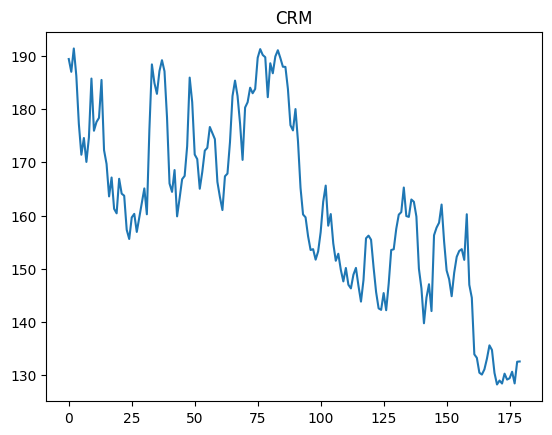

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-40-bb1eba1a8198>:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-40-bb1eba1a8198>:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*(torch.max(q_hats_next)),device=device)


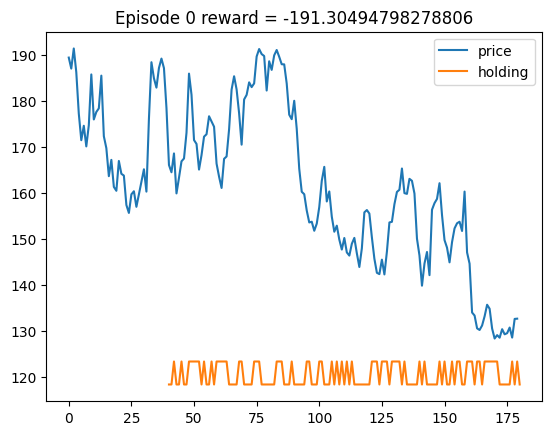

  2%|▎         | 1/40 [00:00<00:26,  1.50it/s]


episode_rewards[-1] = -191.30494798278806



 20%|██        | 8/40 [00:04<00:18,  1.76it/s]

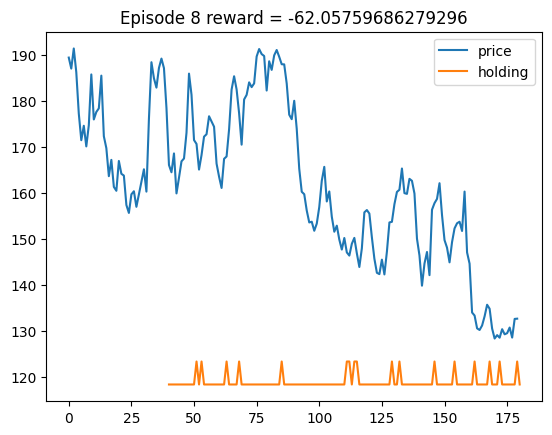

Mean 10 total rewards = -46.78, Grad norm: 0.00, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  40%|████      | 16/40 [00:18<00:41,  1.74s/it]

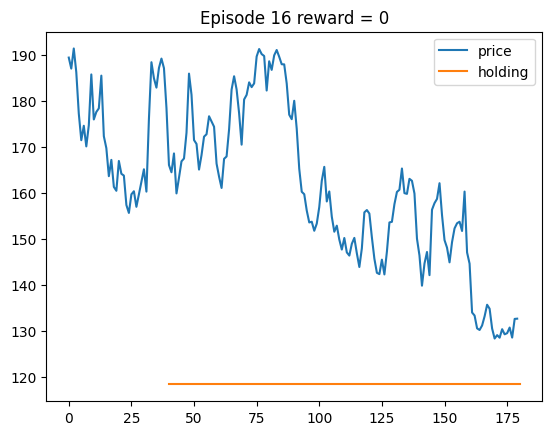

Mean 10 total rewards = -11.45, Grad norm: 0.01, mean_loss_delta (want +) = -0.0000, action_counts: [140, 0, 0]:  60%|██████    | 24/40 [00:29<00:22,  1.40s/it]

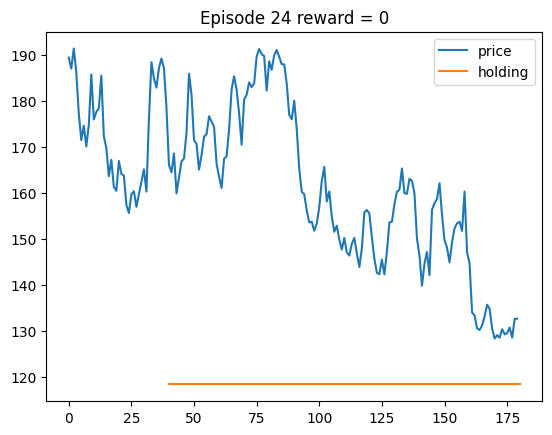

Mean 10 total rewards = -4.05, Grad norm: 0.01, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  80%|████████  | 32/40 [00:40<00:10,  1.32s/it]

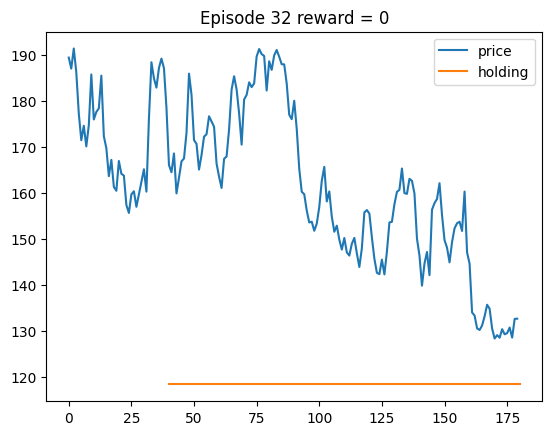

Mean 10 total rewards = -2.97, Grad norm: 0.01, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  98%|█████████▊| 39/40 [00:48<00:01,  1.33s/it]


episode_rewards[-1] = 0



Mean 10 total rewards = -2.97, Grad norm: 0.01, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


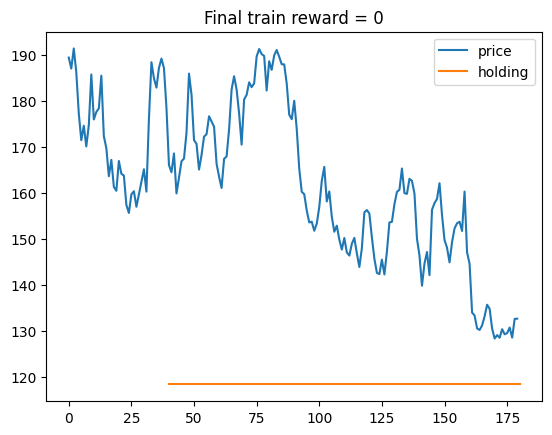

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.3, 0.99, 40, 0.95, 0.003, False, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


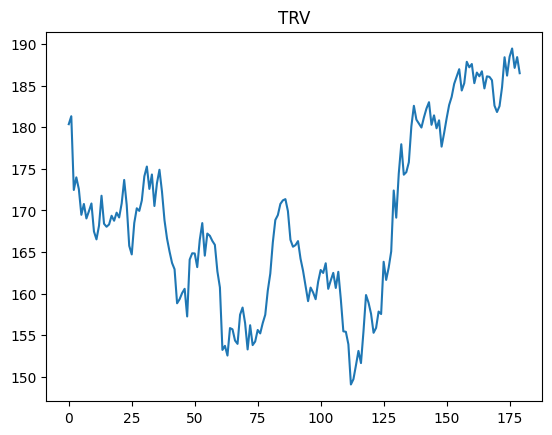

  0%|          | 0/40 [00:00<?, ?it/s]

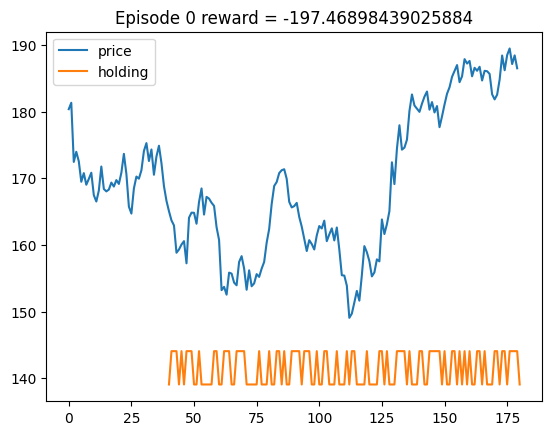

  2%|▎         | 1/40 [00:00<00:24,  1.60it/s]


episode_rewards[-1] = -197.46898439025884



 20%|██        | 8/40 [00:04<00:18,  1.74it/s]

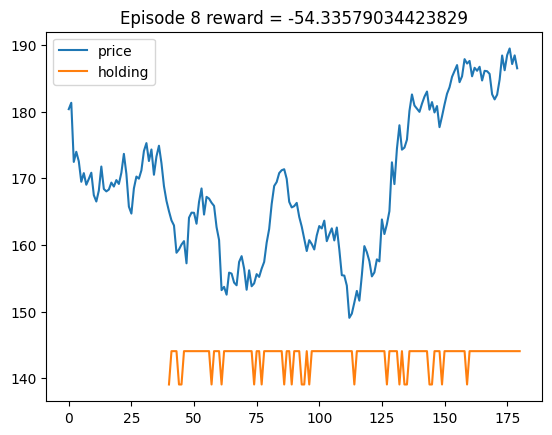

Mean 10 total rewards = -53.35, Grad norm: 12964558.00, mean_loss_delta (want +) = -1102141.8750, action_counts: [3, 4, 133]:  40%|████      | 16/40 [00:14<00:29,  1.23s/it]

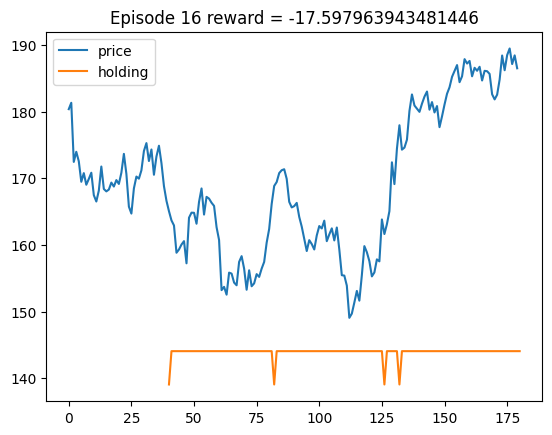

Mean 10 total rewards = -7.53, Grad norm: 2.74, mean_loss_delta (want +) = 14.0179, action_counts: [1, 2, 137]:  60%|██████    | 24/40 [00:25<00:20,  1.28s/it] 

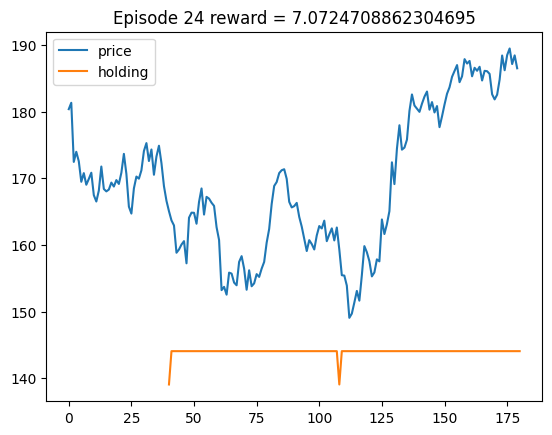

Mean 10 total rewards = 11.84, Grad norm: 2.74, mean_loss_delta (want +) = 618.9184, action_counts: [0, 1, 139]:  80%|████████  | 32/40 [00:35<00:10,  1.32s/it]

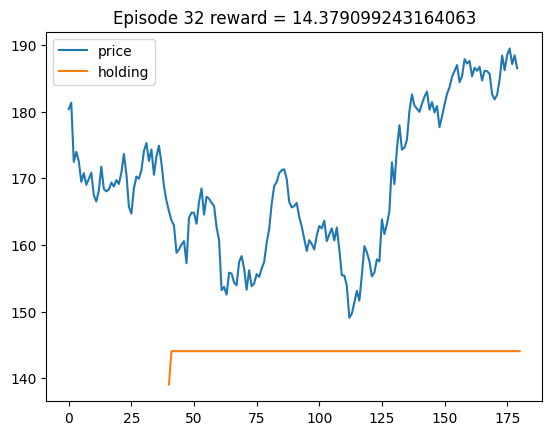

Mean 10 total rewards = 13.52, Grad norm: 2.74, mean_loss_delta (want +) = 0.0448, action_counts: [0, 1, 139]:  98%|█████████▊| 39/40 [00:44<00:01,  1.36s/it]


episode_rewards[-1] = 14.379099243164063



Mean 10 total rewards = 13.52, Grad norm: 2.74, mean_loss_delta (want +) = 0.0000, action_counts: [0, 1, 139]: 100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


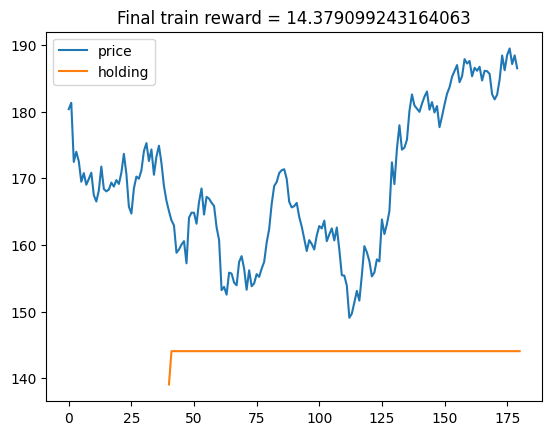

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 3e-07, 0.99, 100, 0.95, 0.0003, False, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


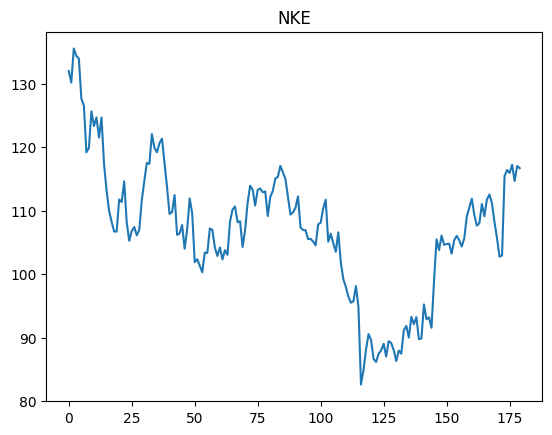

  0%|          | 0/100 [00:00<?, ?it/s]

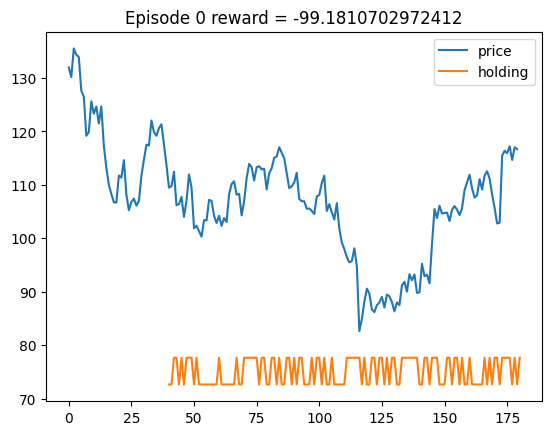

  1%|          | 1/100 [00:00<01:37,  1.01it/s]


episode_rewards[-1] = -99.1810702972412



Mean 10 total rewards = -67.23, Grad norm: 9.39, mean_loss_delta (want +) = 0.0000, action_counts: [18, 15, 107]:  20%|██        | 20/100 [00:10<00:38,  2.08it/s]

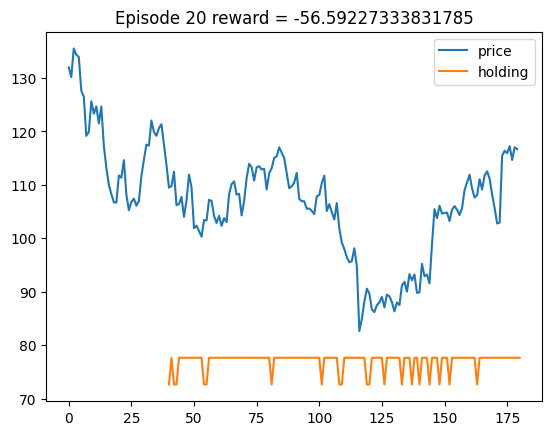

Mean 10 total rewards = -20.50, Grad norm: 9.43, mean_loss_delta (want +) = 0.0000, action_counts: [5, 6, 129]:  40%|████      | 40/100 [00:19<00:25,  2.32it/s]

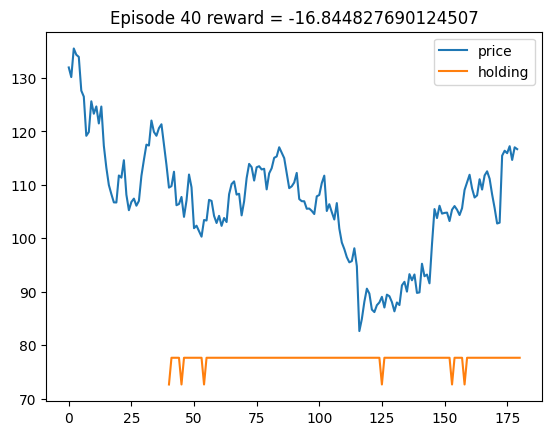

Mean 10 total rewards = -2.95, Grad norm: 9.43, mean_loss_delta (want +) = 0.0000, action_counts: [0, 1, 139]:  60%|██████    | 60/100 [00:28<00:16,  2.36it/s]

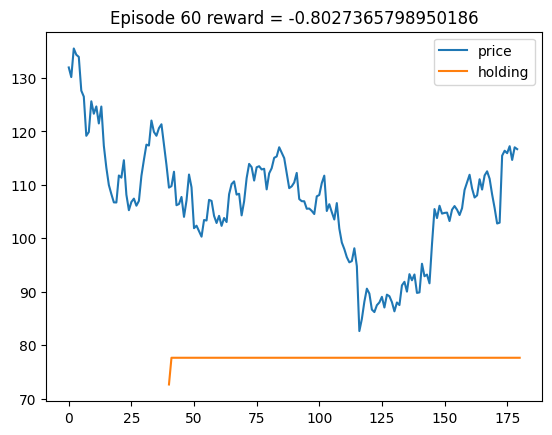

Mean 10 total rewards = -4.88, Grad norm: 9.43, mean_loss_delta (want +) = 0.0000, action_counts: [0, 1, 139]:  80%|████████  | 80/100 [00:37<00:08,  2.28it/s]

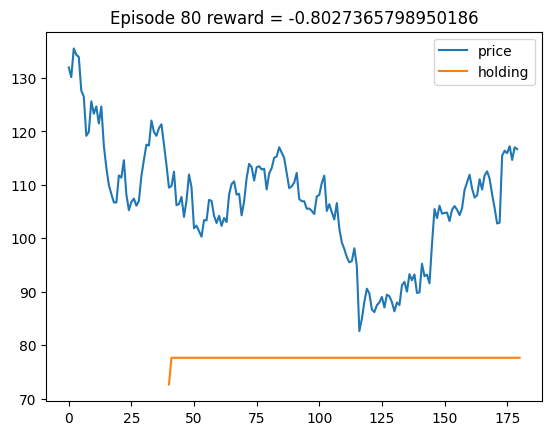

Mean 10 total rewards = -1.69, Grad norm: 9.43, mean_loss_delta (want +) = 0.0000, action_counts: [1, 2, 137]:  99%|█████████▉| 99/100 [00:46<00:00,  1.92it/s]


episode_rewards[-1] = -4.784603256225587



Mean 10 total rewards = -1.69, Grad norm: 9.43, mean_loss_delta (want +) = 0.0000, action_counts: [1, 2, 137]: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


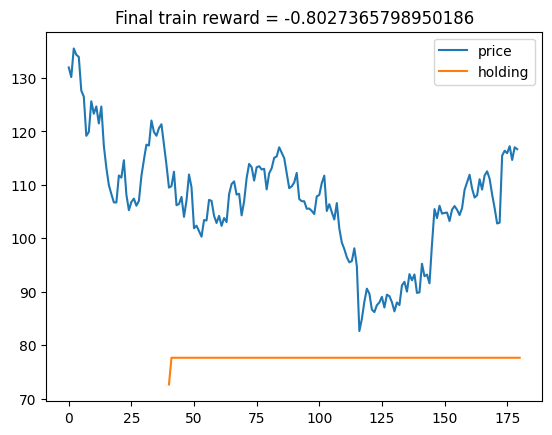

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.003, 0.99, 40, 0.95, 0.0003, False, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


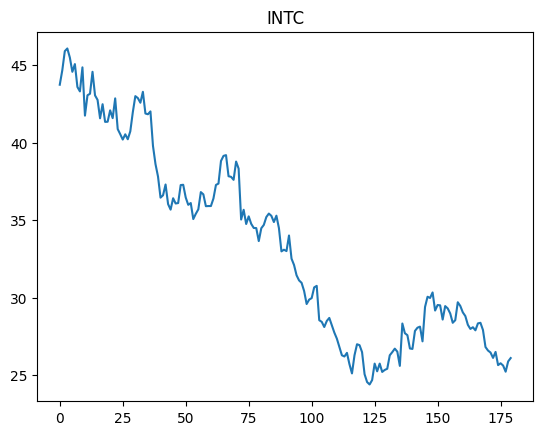

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-38-ac3f2566de0f>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-38-ac3f2566de0f>:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*q_hats_next[action_],device=device)


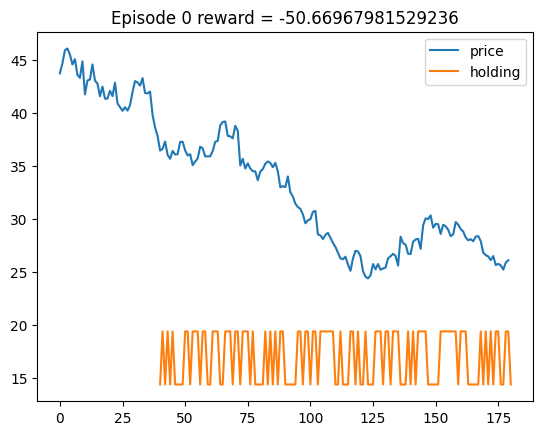

  2%|▎         | 1/40 [00:00<00:27,  1.44it/s]


episode_rewards[-1] = -50.66967981529236



 20%|██        | 8/40 [00:03<00:14,  2.20it/s]

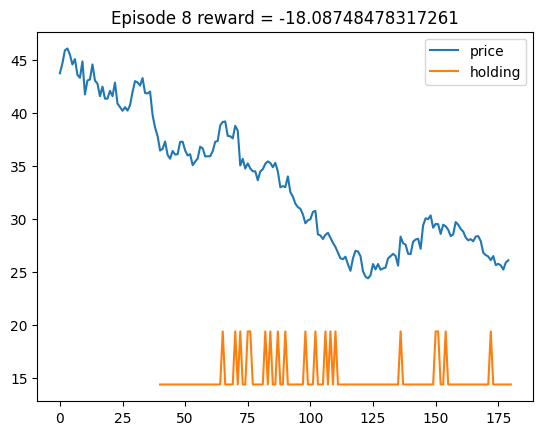

Mean 10 total rewards = -12.94, Grad norm: 0.14, mean_loss_delta (want +) = 0.0014, action_counts: [133, 7, 0]:  40%|████      | 16/40 [00:14<00:30,  1.27s/it]

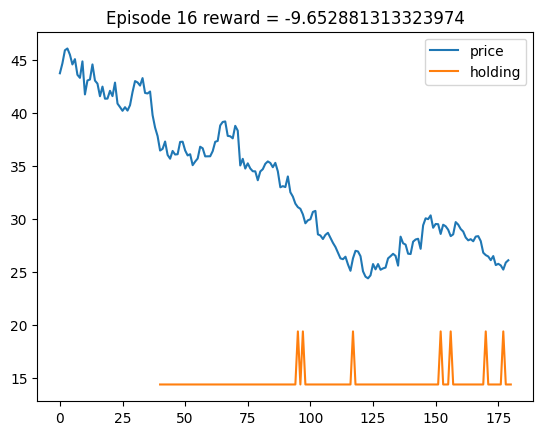

Mean 10 total rewards = -4.13, Grad norm: 0.06, mean_loss_delta (want +) = 0.0004, action_counts: [139, 1, 0]:  60%|██████    | 24/40 [00:25<00:22,  1.42s/it]

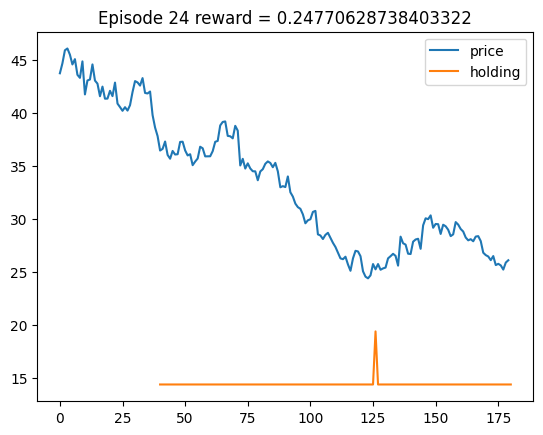

Mean 10 total rewards = -0.83, Grad norm: 0.04, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  80%|████████  | 32/40 [00:37<00:11,  1.46s/it]

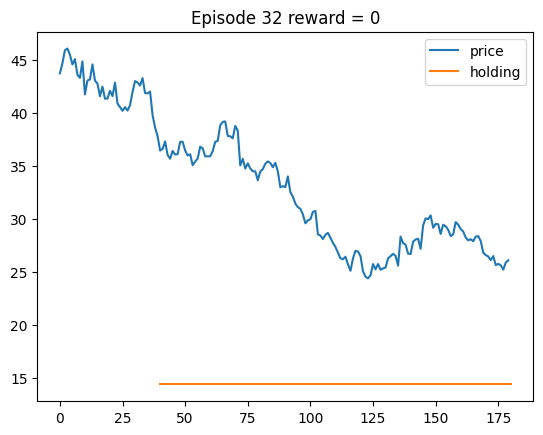

Mean 10 total rewards = -0.38, Grad norm: 0.05, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  98%|█████████▊| 39/40 [00:45<00:01,  1.34s/it]


episode_rewards[-1] = 0



Mean 10 total rewards = -0.38, Grad norm: 0.05, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]: 100%|██████████| 40/40 [00:46<00:00,  1.15s/it]


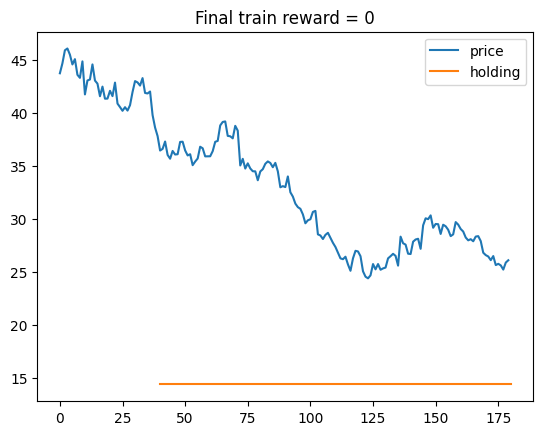

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.3, 0.99, 40, 0.95, 0.003, False, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


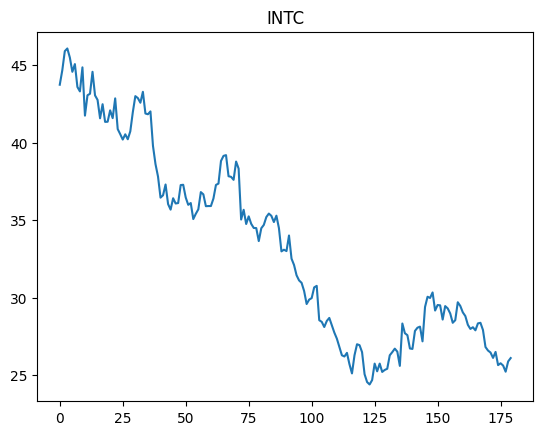

  0%|          | 0/40 [00:00<?, ?it/s]

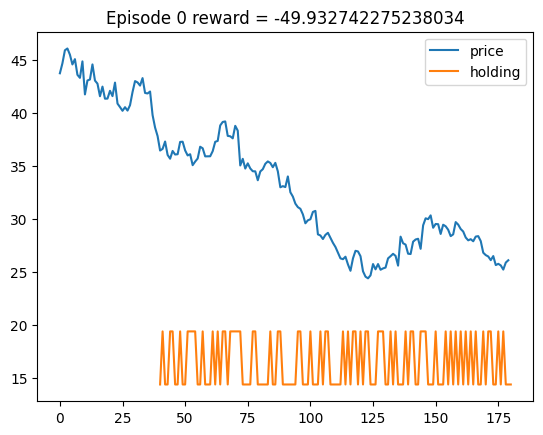

  2%|▎         | 1/40 [00:00<00:33,  1.18it/s]


episode_rewards[-1] = -49.932742275238034



 20%|██        | 8/40 [00:03<00:14,  2.23it/s]

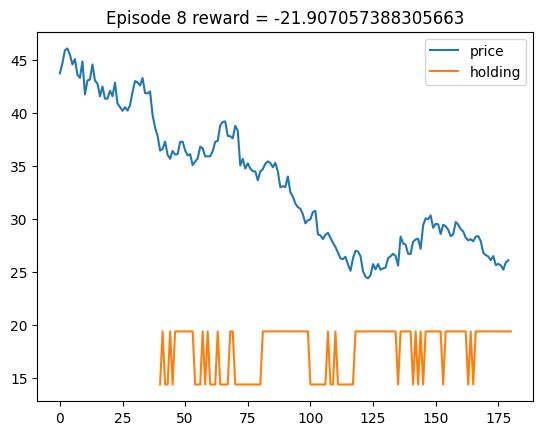

Mean 10 total rewards = -18.74, Grad norm: 30.24, mean_loss_delta (want +) = 219.3942, action_counts: [4, 4, 132]:  40%|████      | 16/40 [00:14<00:31,  1.30s/it]     

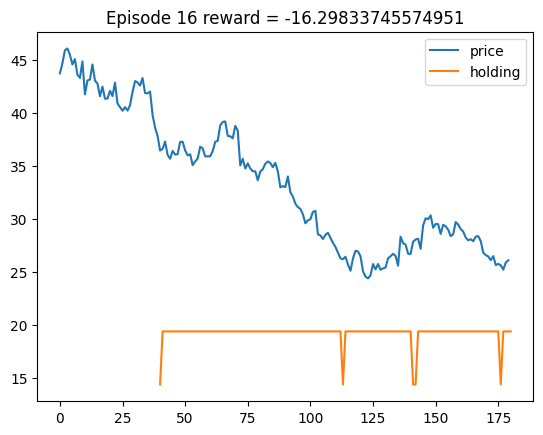

Mean 10 total rewards = -19.05, Grad norm: 54.39, mean_loss_delta (want +) = 47.8470, action_counts: [25, 21, 94]:  60%|██████    | 24/40 [00:25<00:20,  1.28s/it]

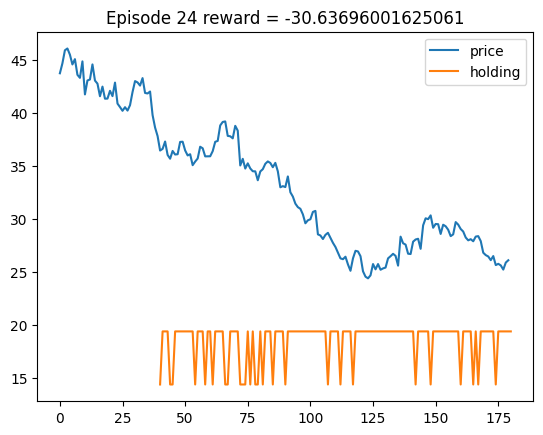

Mean 10 total rewards = -23.48, Grad norm: 54.96, mean_loss_delta (want +) = 20.8552, action_counts: [11, 12, 117]:  80%|████████  | 32/40 [00:37<00:10,  1.36s/it]

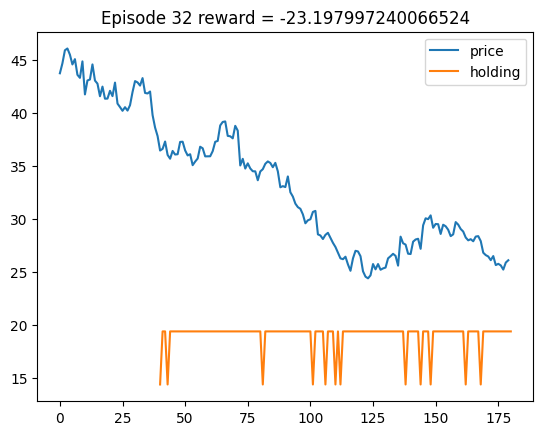

Mean 10 total rewards = -23.06, Grad norm: 54.94, mean_loss_delta (want +) = 0.3817, action_counts: [15, 14, 111]:  98%|█████████▊| 39/40 [00:44<00:01,  1.20s/it]


episode_rewards[-1] = -23.506335140228273



Mean 10 total rewards = -23.67, Grad norm: 54.94, mean_loss_delta (want +) = 0.0000, action_counts: [13, 12, 115]: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


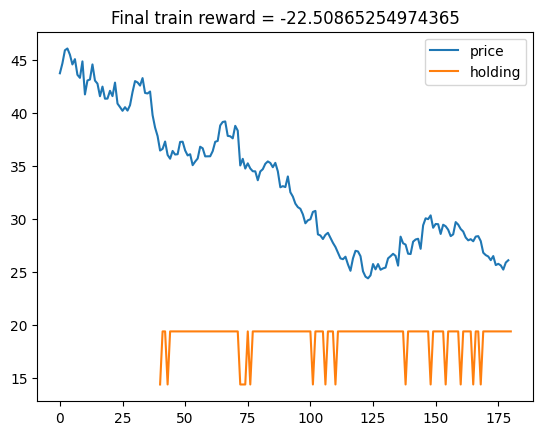

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 3e-07, 0.99, 100, 0.95, 0.0003, False, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


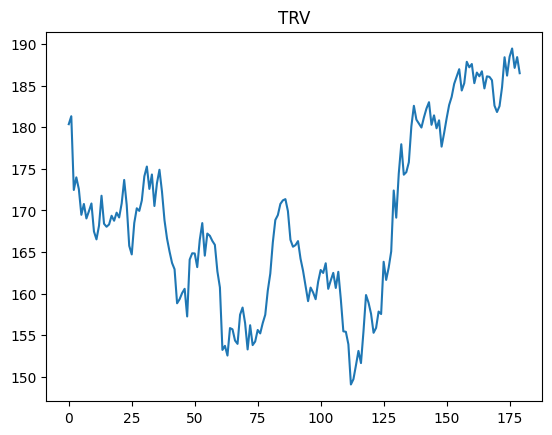

  0%|          | 0/100 [00:00<?, ?it/s]

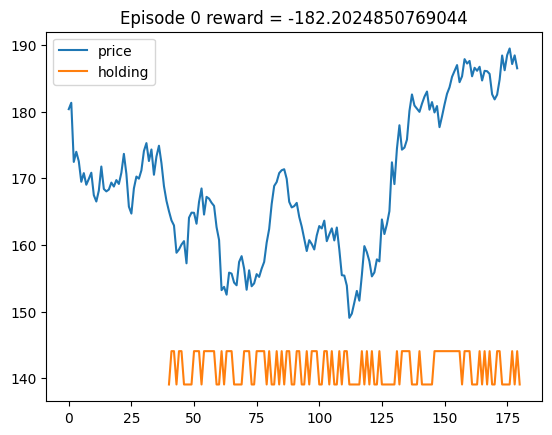

  1%|          | 1/100 [00:00<01:05,  1.51it/s]


episode_rewards[-1] = -182.2024850769044



Mean 10 total rewards = -106.55, Grad norm: 0.02, mean_loss_delta (want +) = 0.0000, action_counts: [120, 15, 5]:  20%|██        | 20/100 [00:10<00:35,  2.25it/s]

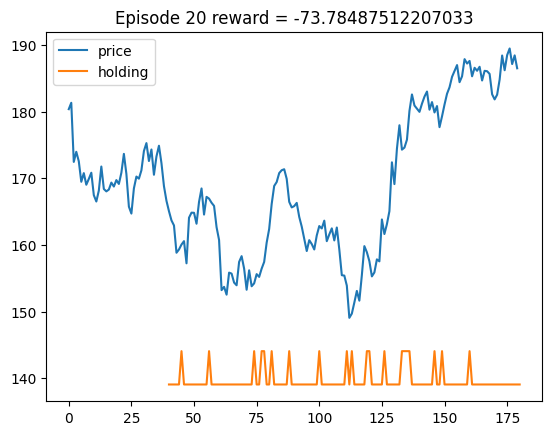

Mean 10 total rewards = -34.91, Grad norm: 0.02, mean_loss_delta (want +) = 0.0000, action_counts: [135, 5, 0]:  40%|████      | 40/100 [00:20<00:28,  2.12it/s]

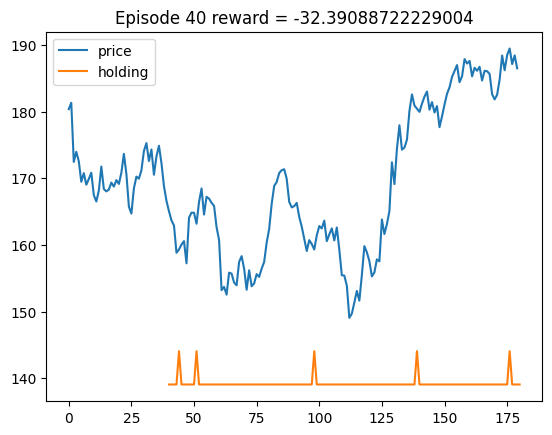

Mean 10 total rewards = -9.89, Grad norm: 0.02, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  60%|██████    | 60/100 [00:29<00:22,  1.75it/s] 

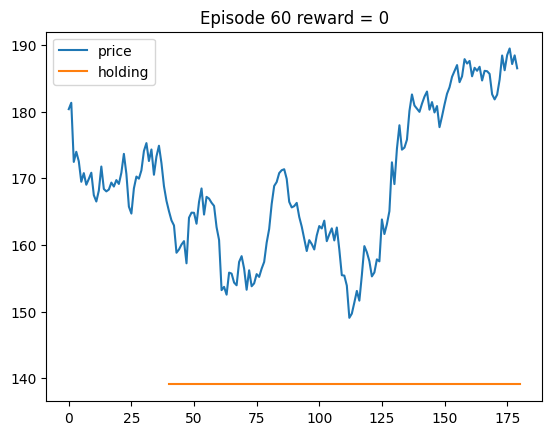

Mean 10 total rewards = -3.45, Grad norm: 0.02, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  80%|████████  | 80/100 [00:39<00:08,  2.24it/s]

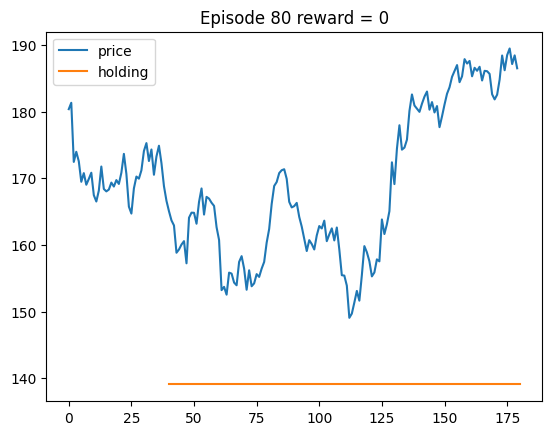

Mean 10 total rewards = 0.00, Grad norm: 0.02, mean_loss_delta (want +) = -0.0000, action_counts: [140, 0, 0]:  99%|█████████▉| 99/100 [00:48<00:00,  2.21it/s]


episode_rewards[-1] = 0



Mean 10 total rewards = 0.00, Grad norm: 0.02, mean_loss_delta (want +) = -0.0000, action_counts: [140, 0, 0]: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


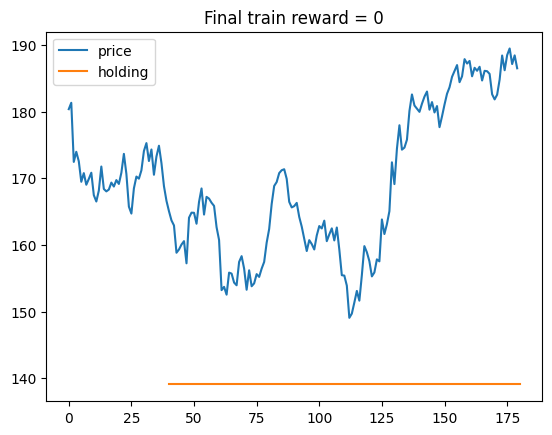

In [ ]:
sweep_settings = [((200,300,200), master_data, 3e-03, 0.99, 40, 0.95, 0.0003,False,False),
                  ((200,300,200), master_data, 3e-01, 0.99, 40, 0.95, 0.003,False,False),
                  ((200,300,200), master_data, 3e-07, 0.99, 100, 0.95, 0.0003,False,False)]
results_dict_q_1 = qlearn3_sweep_MLP(sweep_settings)
results_dict_s_1 = sarsa_sweep_MLP(sweep_settings)

## Training fully on real data
Finally, the thing we actually want: training on a varied mix of real stocks, with the goal of generalizing to unseen stocks and time periods.

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.003, 0.99, 40, 0.95, 0.0003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


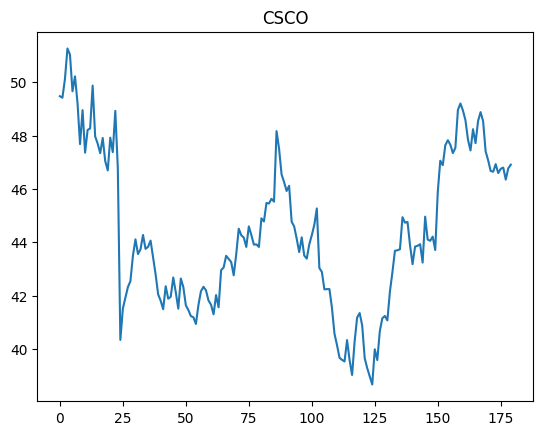

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-40-bb1eba1a8198>:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-40-bb1eba1a8198>:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*(torch.max(q_hats_next)),device=device)


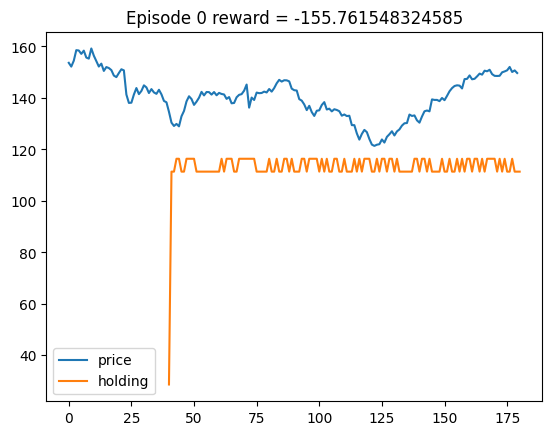

  2%|▎         | 1/40 [00:00<00:33,  1.17it/s]


episode_rewards[-1] = -155.761548324585



 20%|██        | 8/40 [00:04<00:14,  2.17it/s]

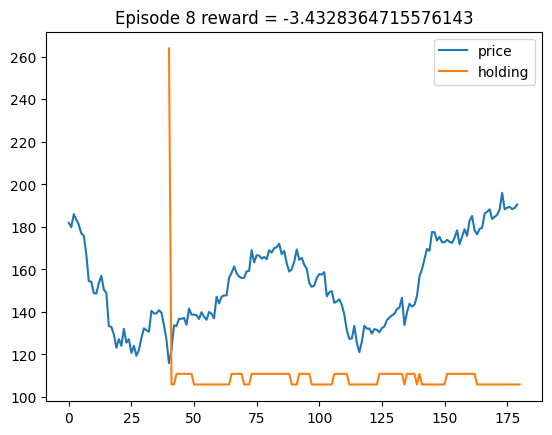

Mean 10 total rewards = -28.53, Grad norm: 6.20, mean_loss_delta (want +) = 0.0092, action_counts: [75, 3, 62]:  40%|████      | 16/40 [00:17<00:35,  1.46s/it] 

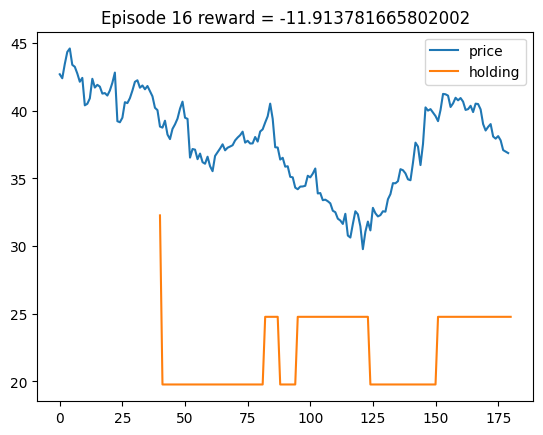

Mean 10 total rewards = -7.91, Grad norm: 0.08, mean_loss_delta (want +) = 0.0030, action_counts: [100, 1, 39]:  60%|██████    | 24/40 [00:27<00:21,  1.37s/it] 

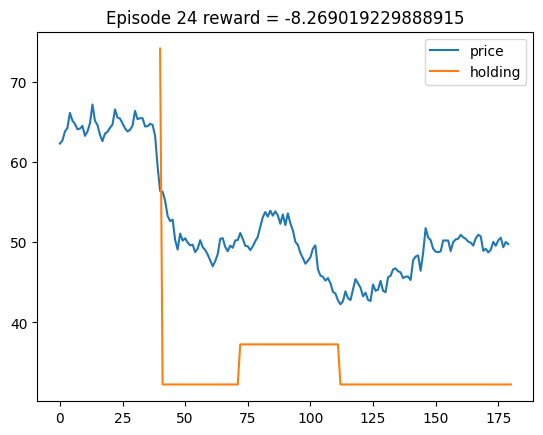

Mean 10 total rewards = -2.44, Grad norm: 0.02, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  80%|████████  | 32/40 [00:38<00:10,  1.30s/it]

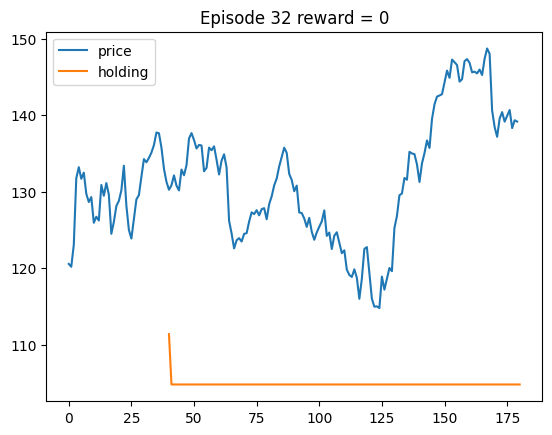

Mean 10 total rewards = -0.34, Grad norm: 0.03, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  98%|█████████▊| 39/40 [00:46<00:01,  1.27s/it]


episode_rewards[-1] = 0



Mean 10 total rewards = -0.34, Grad norm: 0.03, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


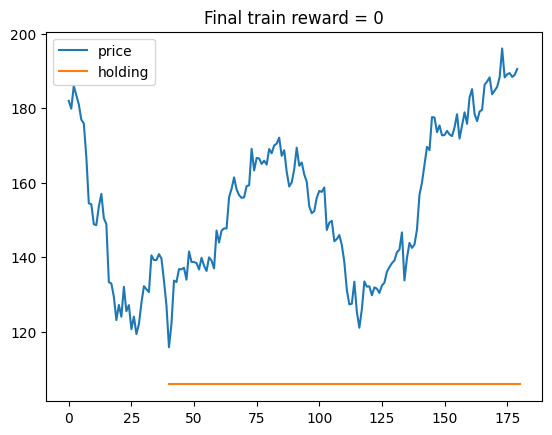

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.3, 0.99, 40, 0.95, 0.003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


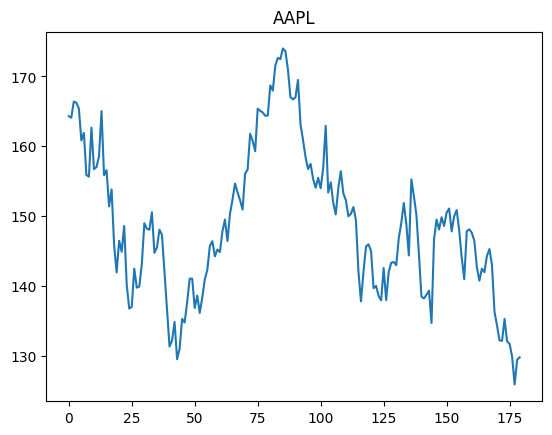

  0%|          | 0/40 [00:00<?, ?it/s]

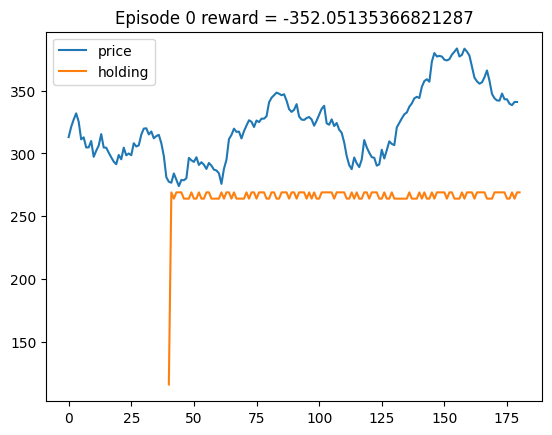

  2%|▎         | 1/40 [00:00<00:24,  1.57it/s]


episode_rewards[-1] = -352.05135366821287



 20%|██        | 8/40 [00:04<00:16,  1.92it/s]

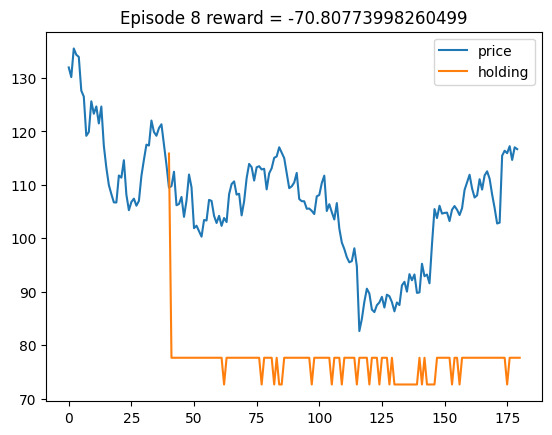

Mean 10 total rewards = -93.50, Grad norm: 28784.98, mean_loss_delta (want +) = 20046636.0000, action_counts: [130, 10, 0]:  40%|████      | 16/40 [00:14<00:26,  1.10s/it]

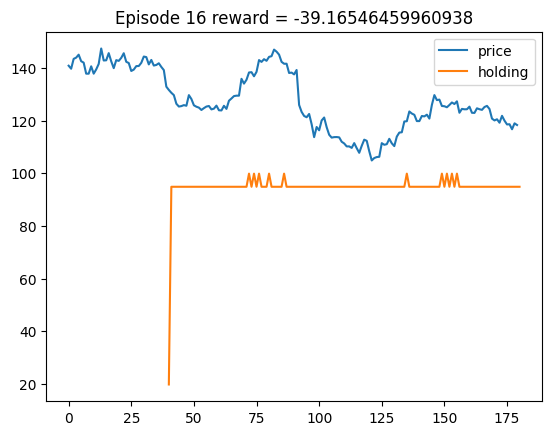

Mean 10 total rewards = -38.23, Grad norm: 11731.17, mean_loss_delta (want +) = 3699493888.0000, action_counts: [109, 26, 5]:  60%|██████    | 24/40 [00:23<00:18,  1.16s/it]

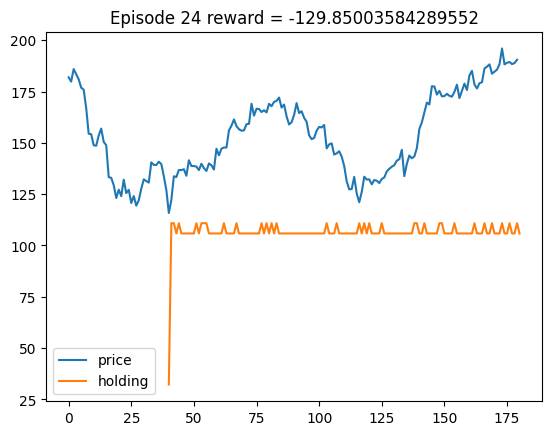

Mean 10 total rewards = -49.85, Grad norm: 2338.61, mean_loss_delta (want +) = 51682896.0000, action_counts: [130, 10, 0]:  80%|████████  | 32/40 [00:33<00:09,  1.16s/it]   

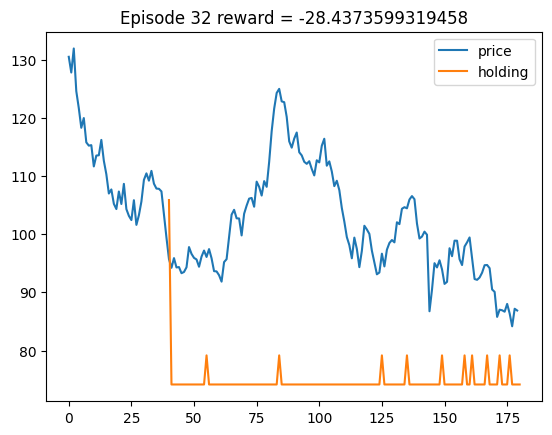

Mean 10 total rewards = -29.09, Grad norm: 3736.36, mean_loss_delta (want +) = 0.1616, action_counts: [139, 1, 0]:  98%|█████████▊| 39/40 [00:40<00:01,  1.17s/it]


episode_rewards[-1] = -5.336992340087891



Mean 10 total rewards = -29.24, Grad norm: 25034.51, mean_loss_delta (want +) = 0.0000, action_counts: [128, 11, 1]: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


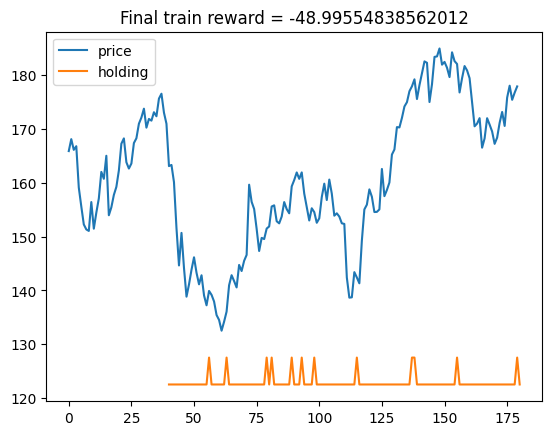

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 3e-07, 0.99, 100, 0.95, 0.0003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


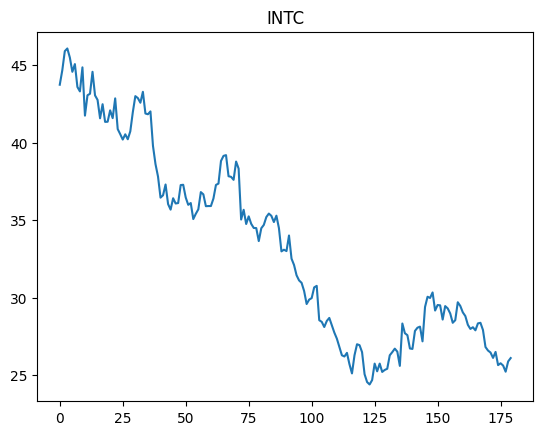

  0%|          | 0/100 [00:00<?, ?it/s]

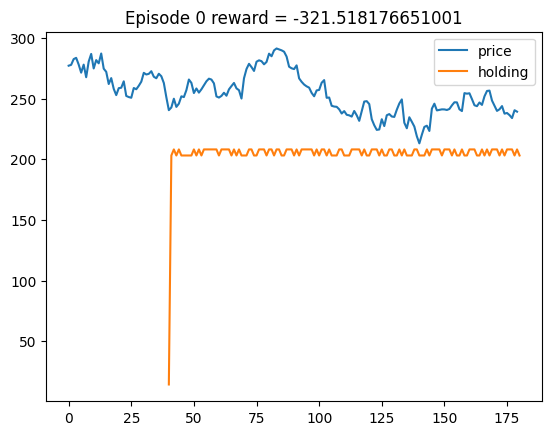

  1%|          | 1/100 [00:00<01:02,  1.59it/s]


episode_rewards[-1] = -321.518176651001



Mean 10 total rewards = -88.79, Grad norm: 13.85, mean_loss_delta (want +) = 0.0000, action_counts: [19, 15, 106]:  20%|██        | 20/100 [00:12<00:54,  1.48it/s]

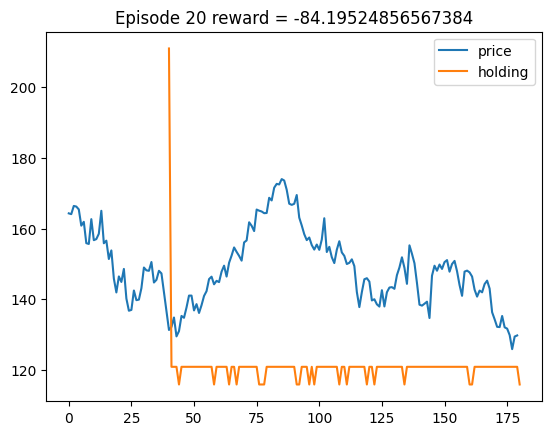

Mean 10 total rewards = -23.58, Grad norm: 14.08, mean_loss_delta (want +) = 0.0000, action_counts: [3, 4, 133]:  40%|████      | 40/100 [00:21<00:26,  2.28it/s]

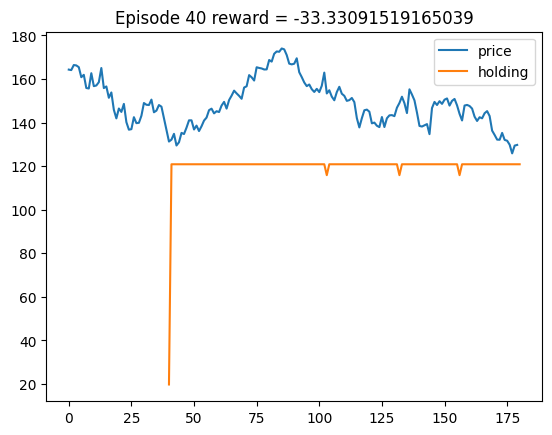

Mean 10 total rewards = 3.18, Grad norm: 11.61, mean_loss_delta (want +) = 0.0000, action_counts: [1, 2, 137]:  60%|██████    | 60/100 [00:31<00:17,  2.33it/s]

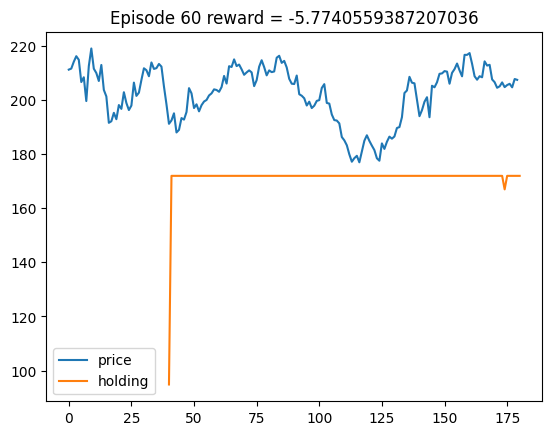

Mean 10 total rewards = 3.01, Grad norm: 1.66, mean_loss_delta (want +) = 0.0000, action_counts: [0, 1, 139]:  80%|████████  | 80/100 [00:41<00:09,  2.19it/s] 

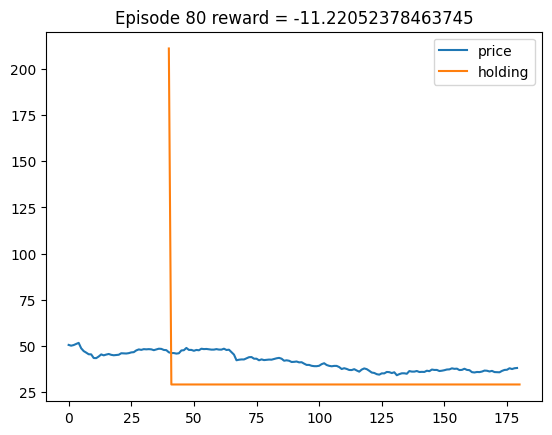

Mean 10 total rewards = 22.82, Grad norm: 3.95, mean_loss_delta (want +) = -0.0000, action_counts: [0, 1, 139]:  99%|█████████▉| 99/100 [00:53<00:00,  2.08it/s]


episode_rewards[-1] = 3.549550109863283



Mean 10 total rewards = 22.82, Grad norm: 3.95, mean_loss_delta (want +) = -0.0000, action_counts: [0, 1, 139]: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


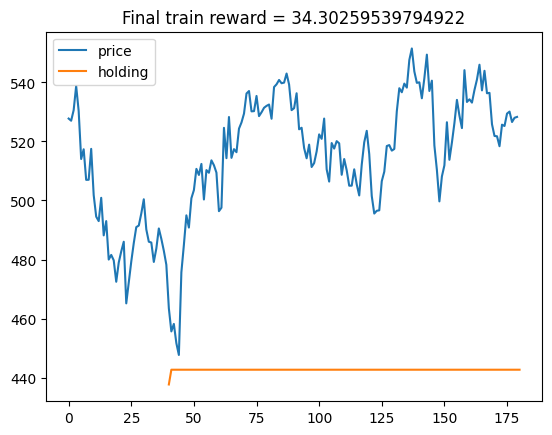

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.003, 0.99, 40, 0.95, 0.0003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


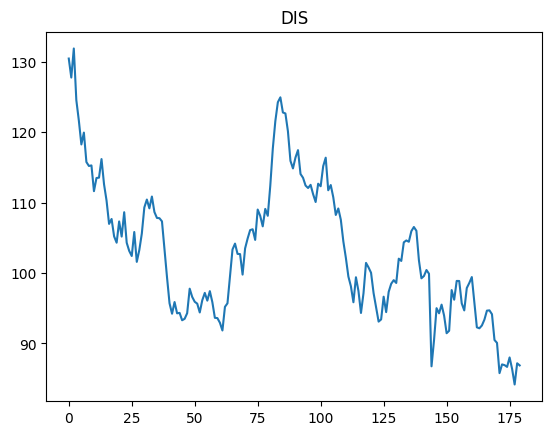

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-38-ac3f2566de0f>:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_hats_next = model(torch.tensor(state_))
<ipython-input-38-ac3f2566de0f>:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_star = torch.tensor(reward + discount_rate*q_hats_next[action_],device=device)


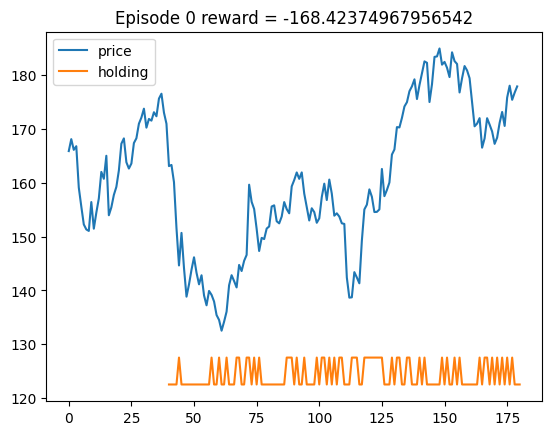

  2%|▎         | 1/40 [00:00<00:25,  1.51it/s]


episode_rewards[-1] = -168.42374967956542



 20%|██        | 8/40 [00:03<00:14,  2.17it/s]

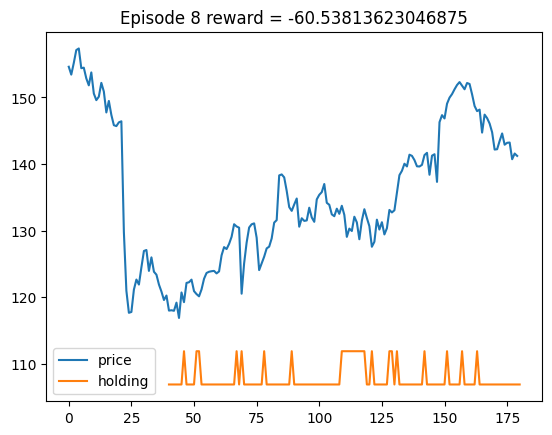

Mean 10 total rewards = -39.47, Grad norm: 0.19, mean_loss_delta (want +) = 0.0097, action_counts: [136, 4, 0]:  40%|████      | 16/40 [00:15<00:32,  1.34s/it]

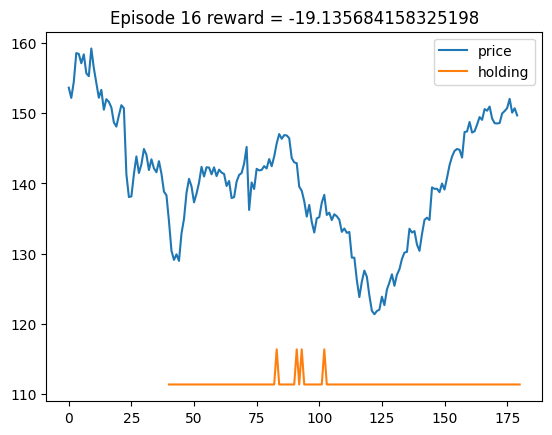

Mean 10 total rewards = -11.92, Grad norm: 0.19, mean_loss_delta (want +) = 0.0024, action_counts: [139, 1, 0]:  60%|██████    | 24/40 [00:28<00:26,  1.63s/it]

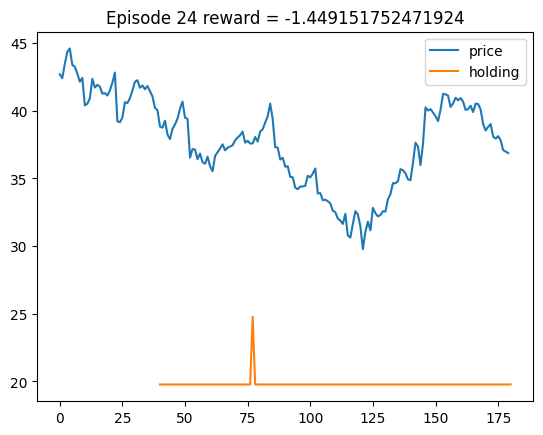

Mean 10 total rewards = -2.65, Grad norm: 0.01, mean_loss_delta (want +) = 0.0002, action_counts: [140, 0, 0]:  80%|████████  | 32/40 [00:41<00:11,  1.44s/it]

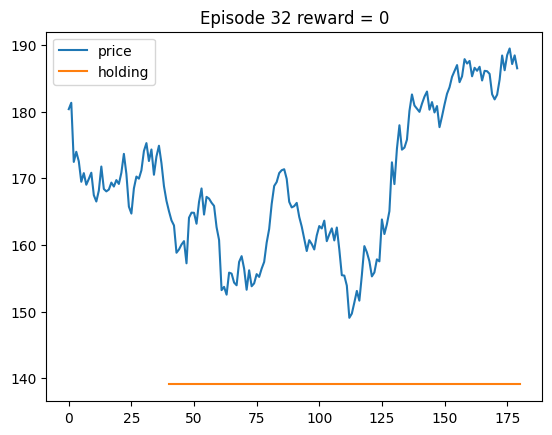

Mean 10 total rewards = -1.29, Grad norm: 0.03, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]:  98%|█████████▊| 39/40 [00:50<00:01,  1.38s/it]


episode_rewards[-1] = 0



Mean 10 total rewards = -1.29, Grad norm: 0.04, mean_loss_delta (want +) = 0.0000, action_counts: [140, 0, 0]: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


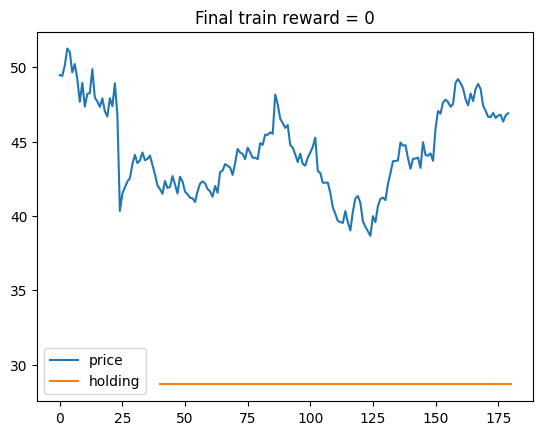

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 0.3, 0.99, 40, 0.95, 0.003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


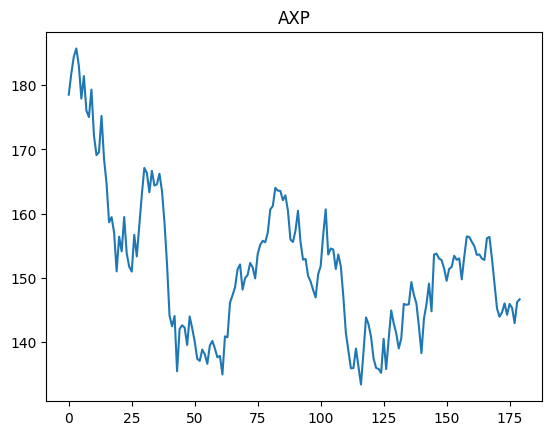

  0%|          | 0/40 [00:00<?, ?it/s]

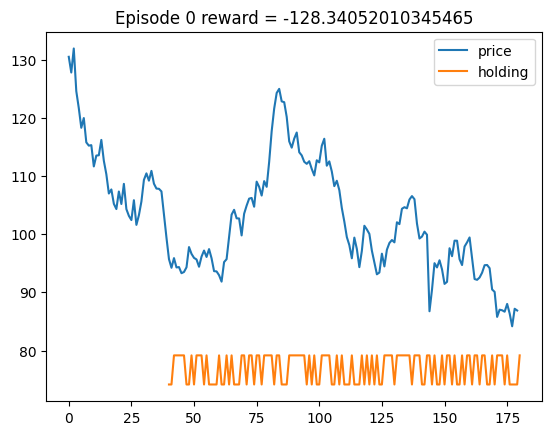

  2%|▎         | 1/40 [00:00<00:26,  1.49it/s]


episode_rewards[-1] = -128.34052010345465



 20%|██        | 8/40 [00:03<00:15,  2.11it/s]

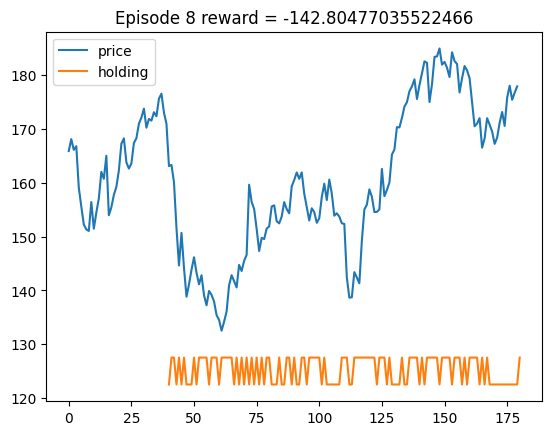

Mean 10 total rewards = -106.97, Grad norm: 279656.38, mean_loss_delta (want +) = 386899840.0000, action_counts: [84, 32, 24]:  40%|████      | 16/40 [00:13<00:27,  1.16s/it]

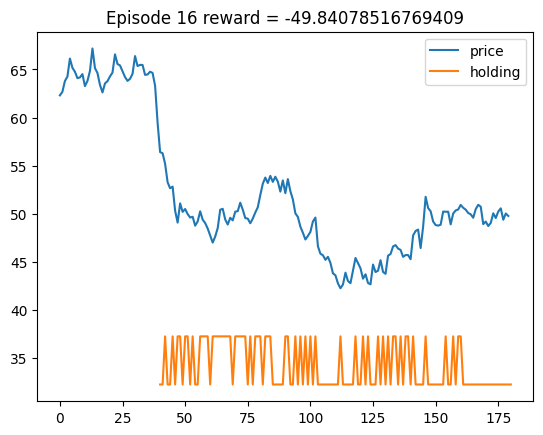

Mean 10 total rewards = -200.45, Grad norm: 12170670.00, mean_loss_delta (want +) = 13948392.0000, action_counts: [69, 69, 2]:  60%|██████    | 24/40 [00:24<00:20,  1.25s/it]

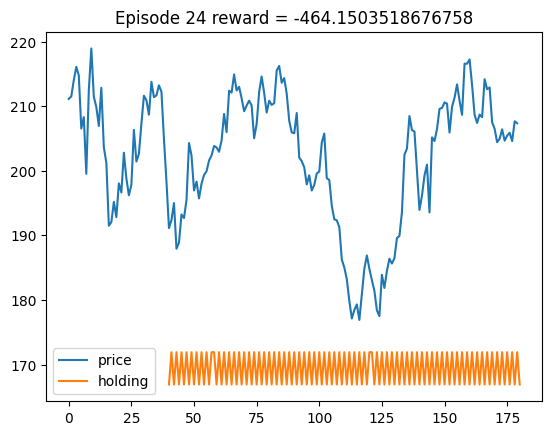

Mean 10 total rewards = -400.85, Grad norm: 8.64, mean_loss_delta (want +) = 38499256.0000, action_counts: [66, 66, 8]:  80%|████████  | 32/40 [00:34<00:10,  1.28s/it]

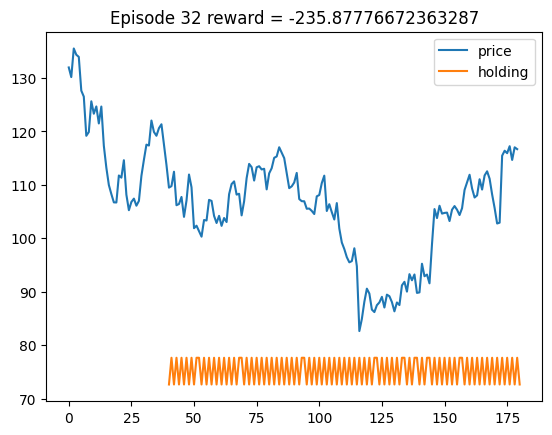

Mean 10 total rewards = -331.87, Grad norm: 5.55, mean_loss_delta (want +) = 202.8544, action_counts: [69, 70, 1]:  98%|█████████▊| 39/40 [00:42<00:01,  1.25s/it]


episode_rewards[-1] = -139.65770637130734



Mean 10 total rewards = -336.14, Grad norm: 5.55, mean_loss_delta (want +) = 0.0000, action_counts: [69, 70, 1]: 100%|██████████| 40/40 [00:42<00:00,  1.07s/it]


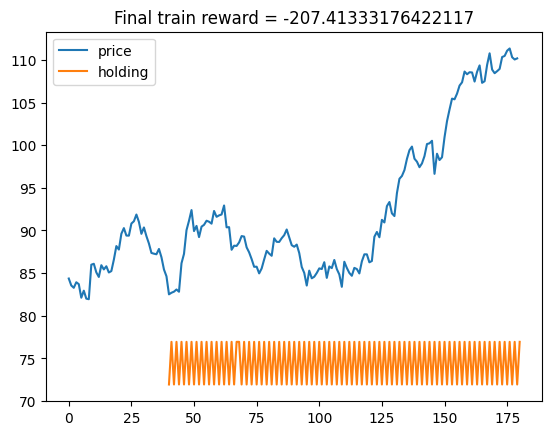

hidden_sizes,alpha,discount_rate,num_episodes,epsilon,wd,proper,debug = ((200, 300, 200), 3e-07, 0.99, 100, 0.95, 0.0003, True, False)
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=39, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=3, bias=True)
  )
)


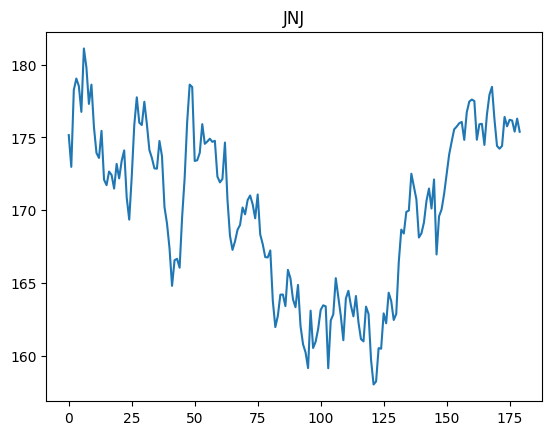

  0%|          | 0/100 [00:00<?, ?it/s]

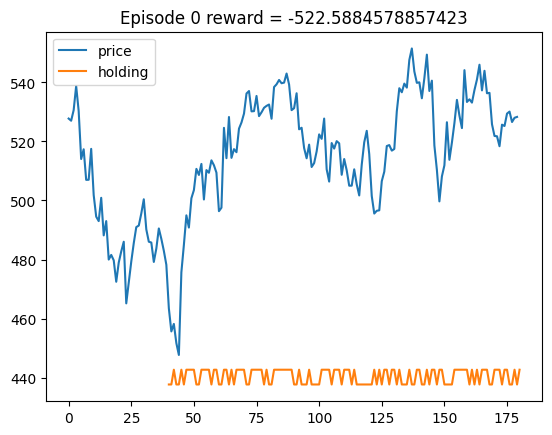

  1%|          | 1/100 [00:00<01:06,  1.50it/s]


episode_rewards[-1] = -522.5884578857423



Mean 10 total rewards = -95.94, Grad norm: 13.56, mean_loss_delta (want +) = 0.0000, action_counts: [14, 13, 113]:  20%|██        | 20/100 [00:09<00:36,  2.17it/s] 

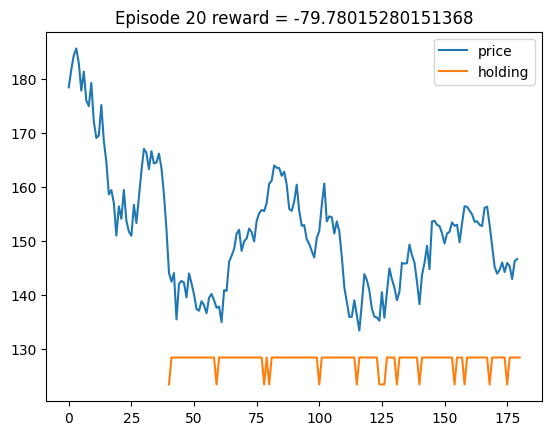

Mean 10 total rewards = -32.59, Grad norm: 5.43, mean_loss_delta (want +) = 0.0000, action_counts: [1, 2, 137]:  40%|████      | 40/100 [00:19<00:26,  2.25it/s]

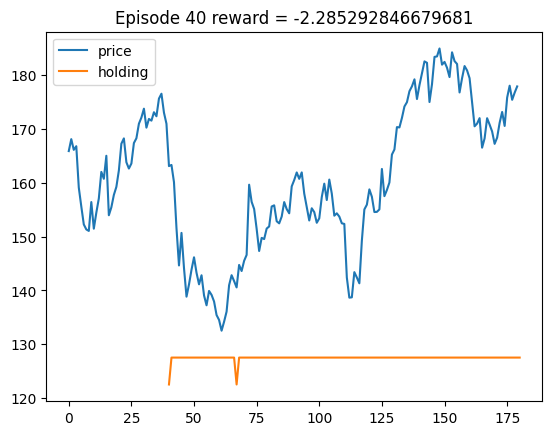

Mean 10 total rewards = 5.74, Grad norm: 4.22, mean_loss_delta (want +) = 0.0000, action_counts: [2, 3, 135]:  60%|██████    | 60/100 [00:29<00:18,  2.21it/s]

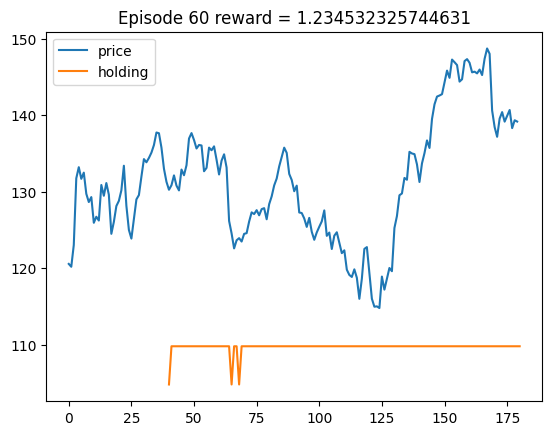

Mean 10 total rewards = 8.97, Grad norm: 5.43, mean_loss_delta (want +) = 0.0000, action_counts: [0, 1, 139]:  80%|████████  | 80/100 [00:39<00:09,  2.04it/s] 

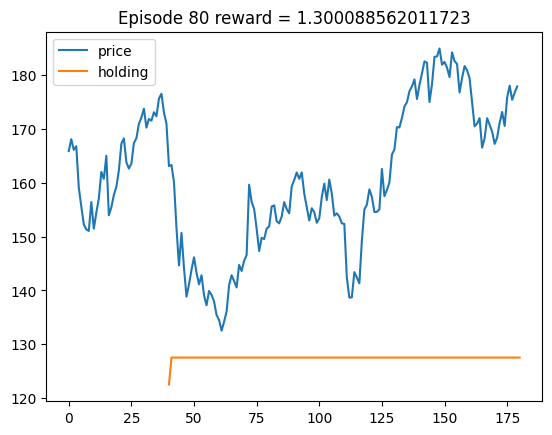

Mean 10 total rewards = 0.85, Grad norm: 1.72, mean_loss_delta (want +) = -0.0000, action_counts: [0, 1, 139]:  99%|█████████▉| 99/100 [00:47<00:00,  2.23it/s]


episode_rewards[-1] = 3.4713178253173824



Mean 10 total rewards = 0.85, Grad norm: 1.72, mean_loss_delta (want +) = -0.0000, action_counts: [0, 1, 139]: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


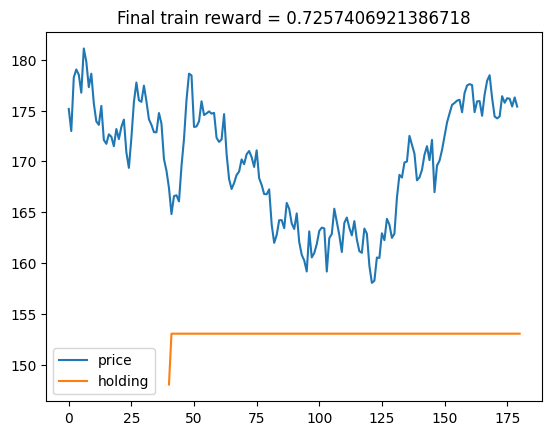

In [ ]:
sweep_settings = [((200,300,200), master_data, 3e-03, 0.99, 40, 0.95, 0.0003,True,False),
                  ((200,300,200), master_data, 3e-01, 0.99, 40, 0.95, 0.003,True,False),
                  ((200,300,200), master_data, 3e-07, 0.99, 100, 0.95, 0.0003,True,False)]

proper_keys = [((200,300,200),3e-03,0.99,40,0.95,0.0003),((200,300,200),3e-01,0.99,40,0.95,0.003),((200,300,200),3e-07,0.99,100,0.95,0.0003)]

results_dict_q_1_proper = qlearn3_sweep_MLP(sweep_settings)
results_dict_s_1_proper = sarsa_sweep_MLP(sweep_settings)

In [ ]:
tickers = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(days=180)
# Fewer than 40 days of this is included in the training data (I checked), so none of the models trained above have seen the test data
master_data_test = yf.download(tickers, start=start_date, end = end_date)
master_data_test = master_data_test['Adj Close']
# master_data_test

[*********************100%***********************]  30 of 30 completed


KO


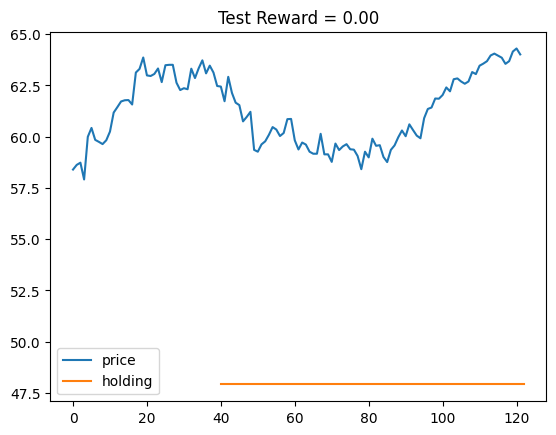

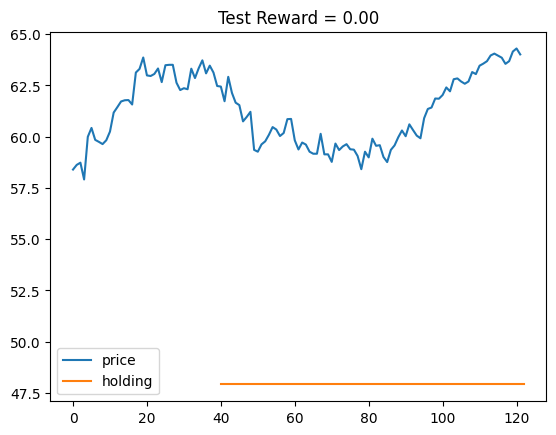

UNH


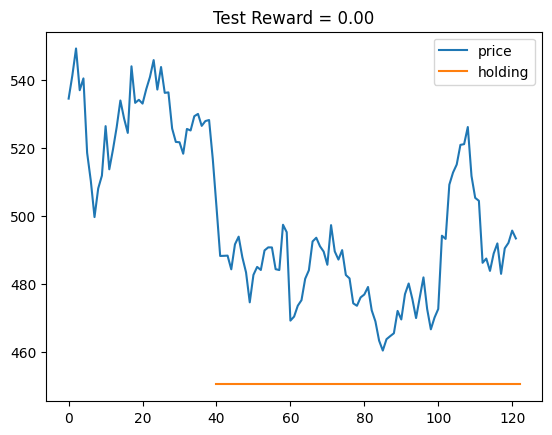

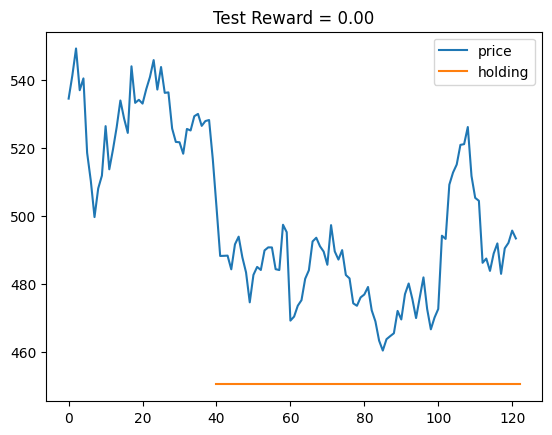

CVX


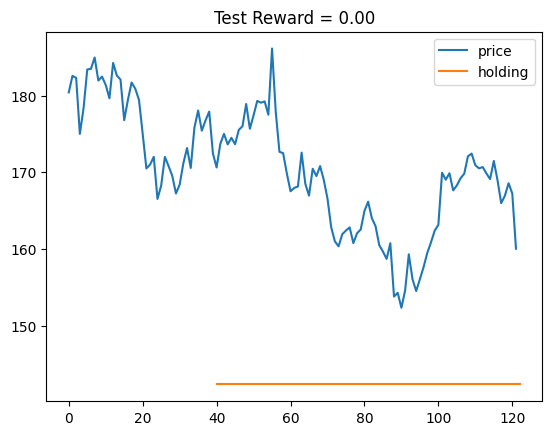

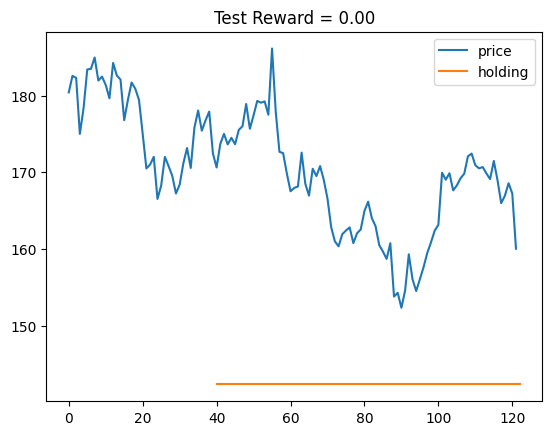

MCD


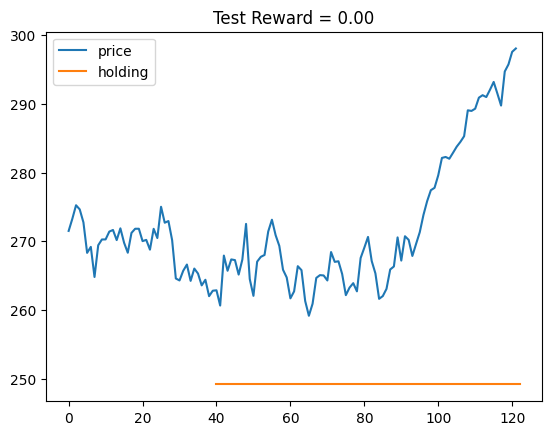

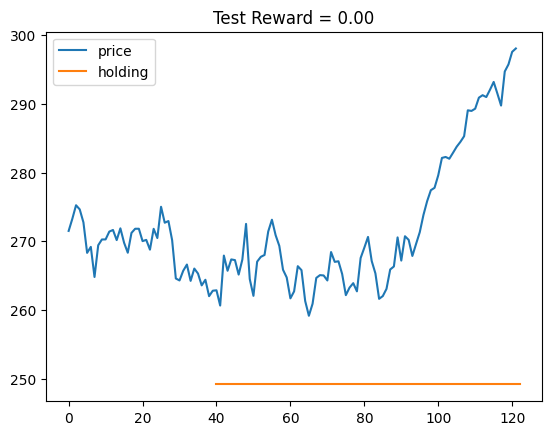

MCD


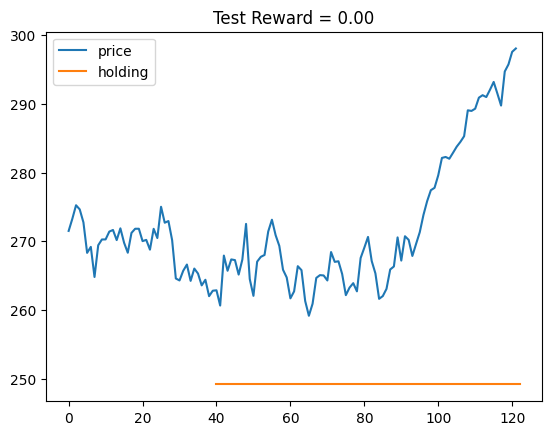

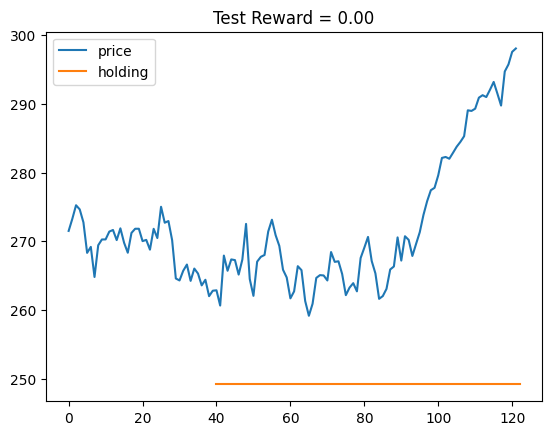

AAPL


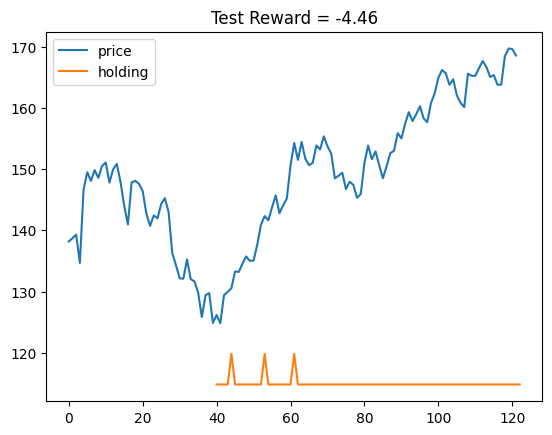

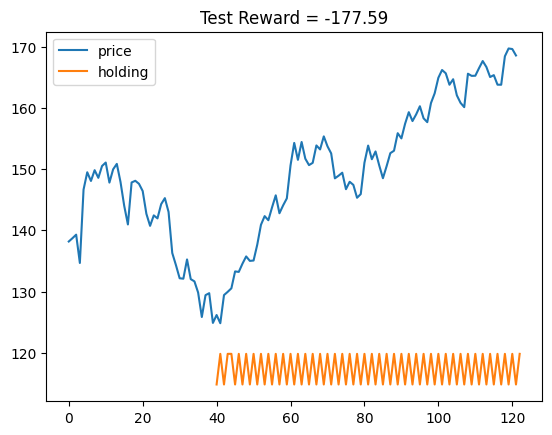

V


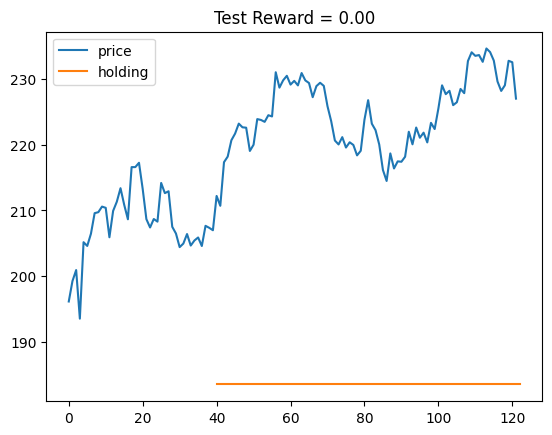

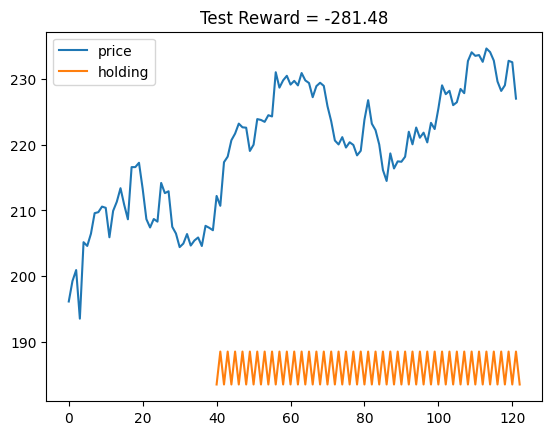

CSCO


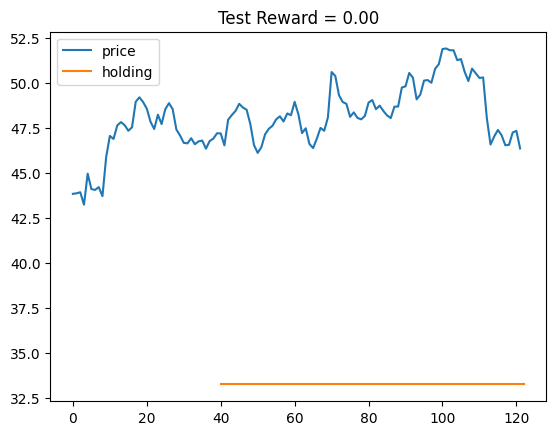

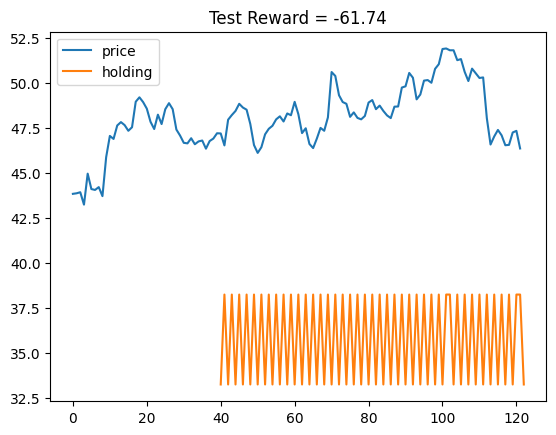

VZ


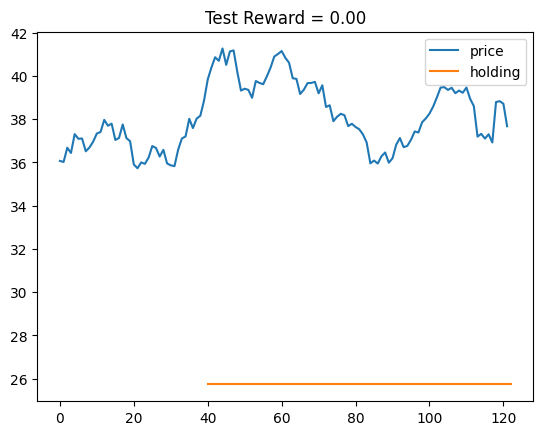

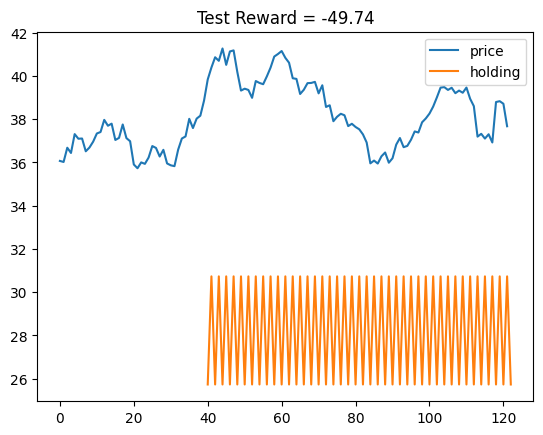

INTC


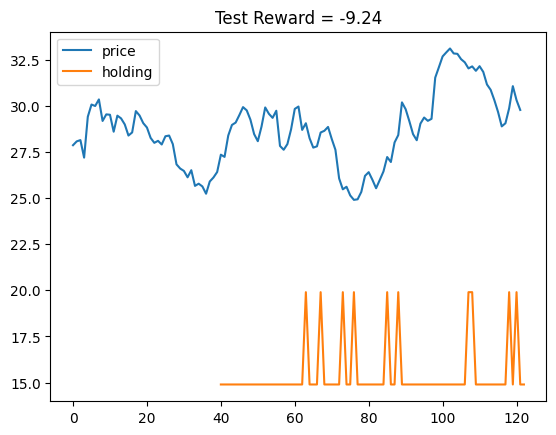

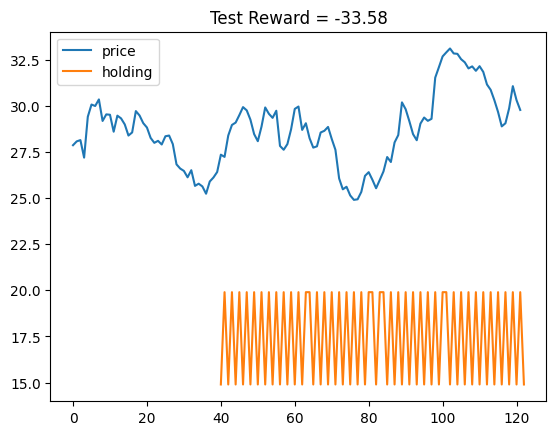

V


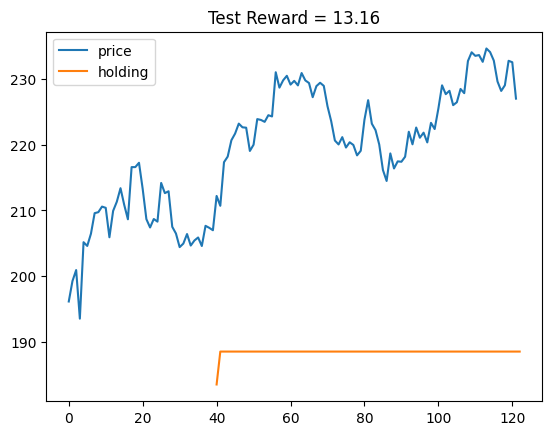

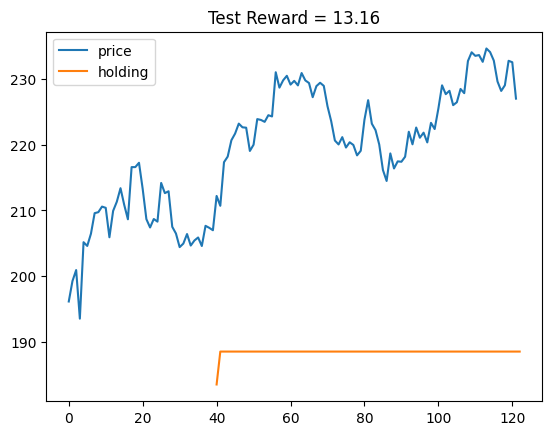

IBM


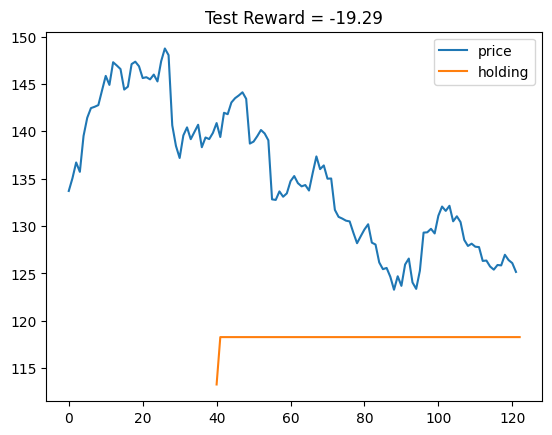

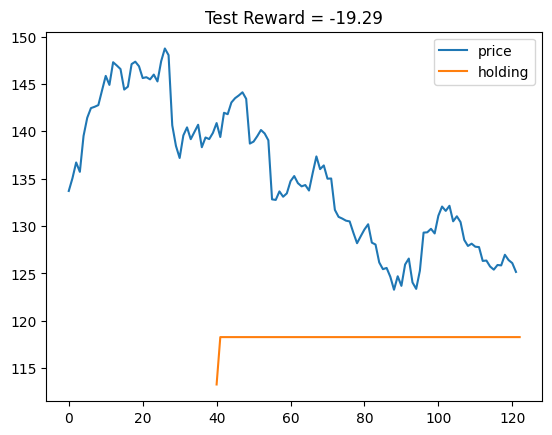

HON


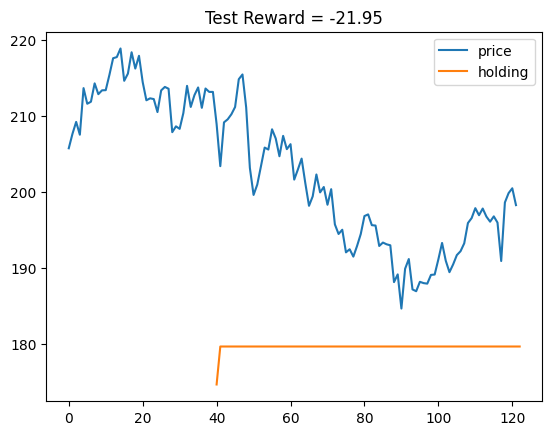

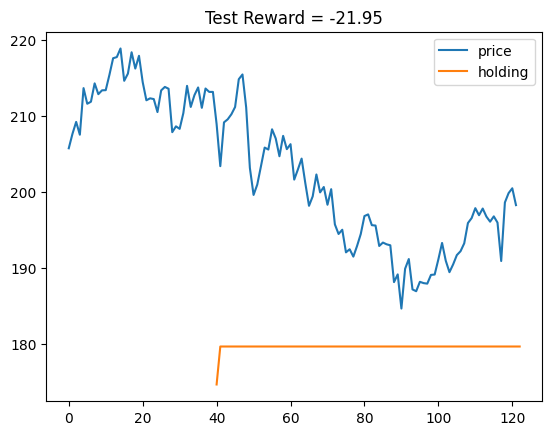

INTC


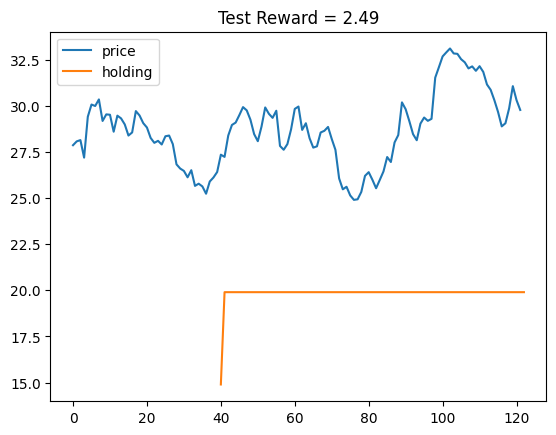

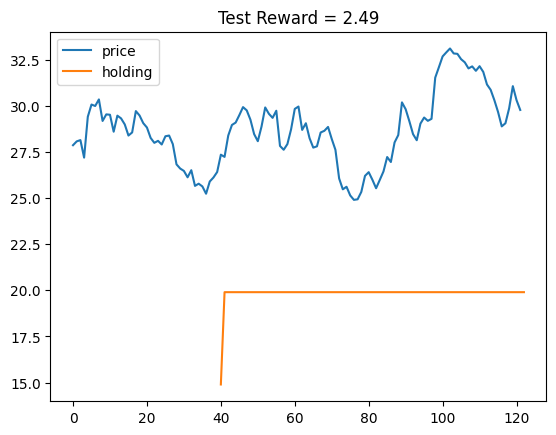

UNH


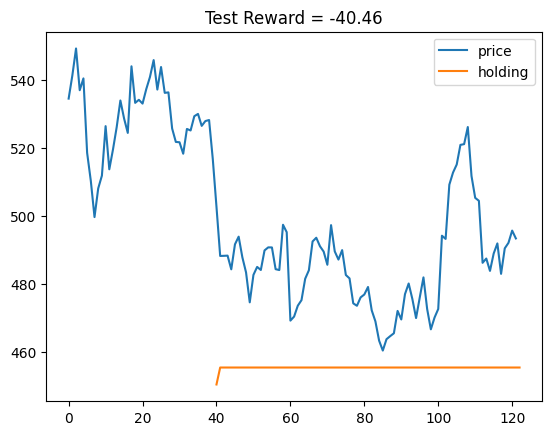

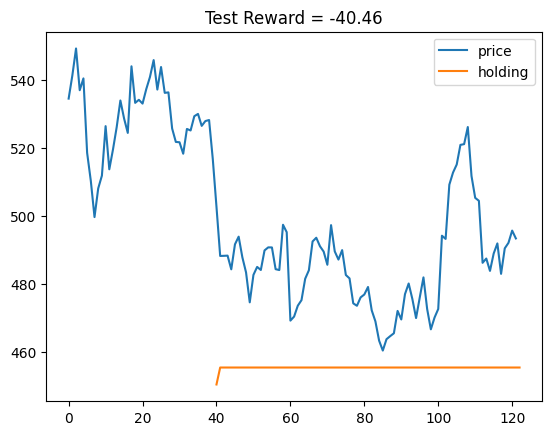

In [ ]:
for key in proper_keys:
  for i in range(5):
    selected_stock = np.random.choice(master_data_test.columns)
    print(selected_stock)
    data = (master_data_test[selected_stock].values)

    for results_dict in [results_dict_q_1_proper,results_dict_s_1_proper]:
      model = results_dict[key][2]
      total_reward,episode_holdings = eval_model_on_data(model,data,model_class=MLP)
      plt.plot(range(len(data)),data,label="price")
      plt.plot(range(40,len(episode_holdings)+40),episode_holdings,label="holding")
      plt.title(f"Test Reward = {total_reward:.2f}")
      plt.legend()
      plt.show()

## Next

# Todo: TD(n)

In [ ]:
sweep_settings = [((200,200,200,), master_data, 3e-03, 0.99, 100, 0.95, 0.003,False,False),
                  ((200,200,200,), master_data2, 3e-03, 0.99, 100, 0.95, 0.003,False,False)]
results_dict_q = qlearn3_sweep_MLP(sweep_settings)
results_dict_s = sarsa_sweep_MLP(sweep_settings)

In [ ]:
# Do GRU's?
# sweep_settings = [((200,200,200,), master_data, 3e-03, 0.99, 100, 0.95, 0.003,False,False),
#                   ((200,200,200,), master_data2, 3e-03, 0.99, 100, 0.95, 0.003,False,False)]
# results_dict_q = qlearn3_sweep_MLP(sweep_settings)
# results_dict_s = sarsa_sweep_MLP(sweep_settings)

# Results to copy and paste into submission notebook

Next, I tried training on more up-and-down, though still quite simple, synthetic data. It was more difficult to train models to fit this data, but the following plot shows one successful run using Q learning.

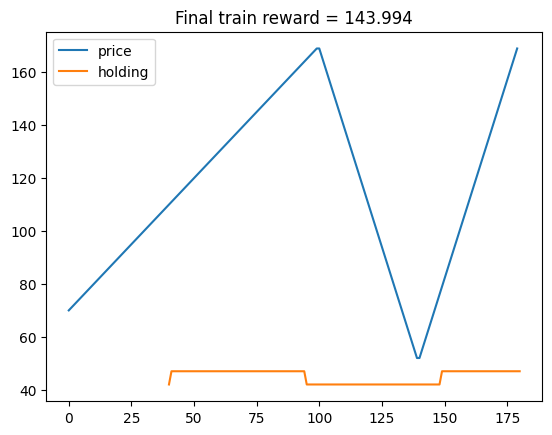

I also tried using the models trained on the simplest data as a starting point and finetuning them to this more complex task. This didn't work very well: I tried lowering the learning rate and starting epsilon values, but either a lot more hyperparameter tuning is required, or the "pretrained" models just aren't a good starting point for this. The plots below show the start and end of the finetuning process, first for Q learning and then for SARSA.

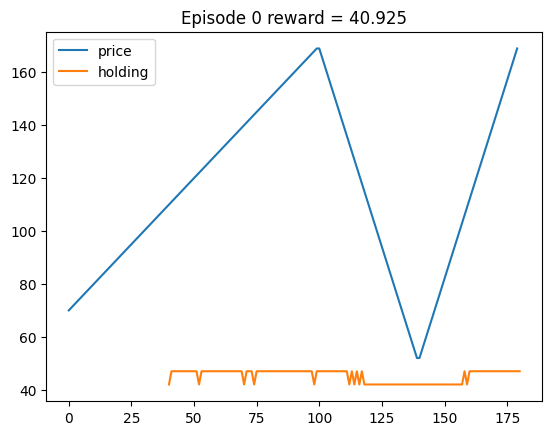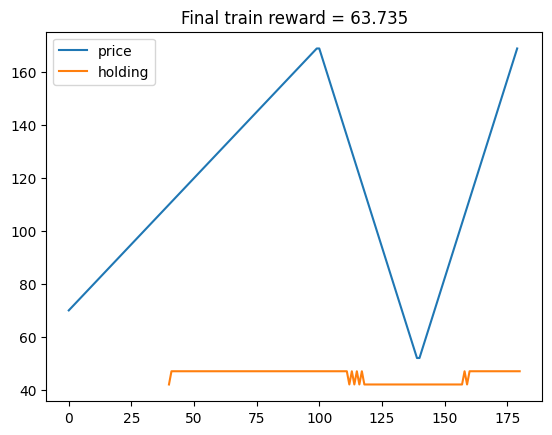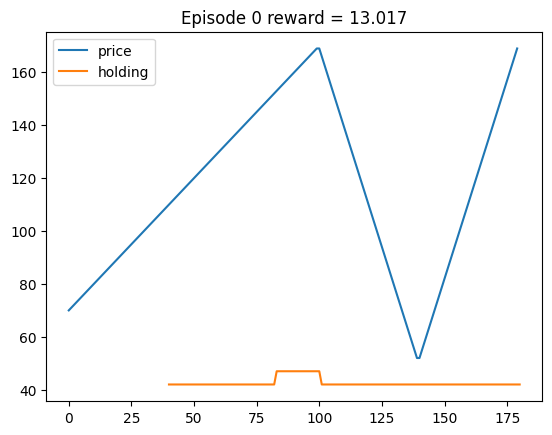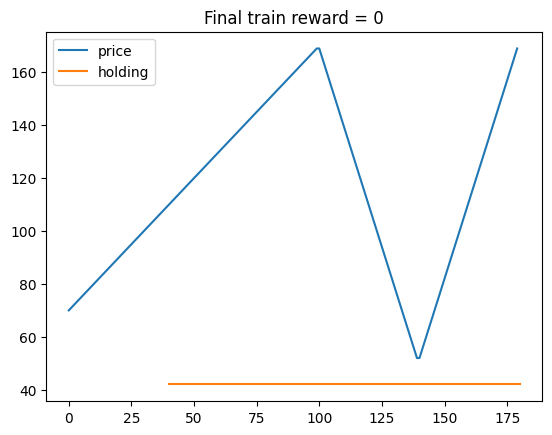